## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [5]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [44]:
yy = X_val[0:1]
print (yy.dtype)
print (yy.shape)
print (yy)
#b.astype
print ('astype')
zz = yy.astype(np.float32)
print (zz.dtype)
print (zz.shape)
print (zz)

float64
(1, 32, 32, 3)
[[[[ 40.35810204  51.01826531  81.52608163]
   [ 38.94430612  51.65195918  82.24597959]
   [ 37.03944898  50.85671429  81.52363265]
   ..., 
   [ 52.08416327  57.82467347  79.70193878]
   [ 49.74489796  54.4197551   77.1307551 ]
   [ 50.94502041  56.63465306  78.21483673]]

  [[ 39.97585714  48.78316327  79.72267347]
   [ 38.73944898  49.63691837  79.63771429]
   [ 36.86344898  49.91895918  79.00018367]
   ..., 
   [ 56.07028571  54.96422449  79.21777551]
   [ 52.7807551   54.544       77.61238776]
   [ 50.94636735  55.70804082  78.64302041]]

  [[ 41.33663265  50.41510204  80.81738776]
   [ 39.34353061  50.57302041  80.05812245]
   [ 38.58165306  51.01312245  80.59912245]
   ..., 
   [ 52.87120408  55.11087755  79.79559184]
   [ 51.48989796  54.52940816  78.02171429]
   [ 50.48187755  56.50165306  78.84563265]]

  ..., 
  [[-13.53626531   7.06446939  34.86355102]
   [ -9.56961224  11.28759184  39.22930612]
   [ -6.90812245  14.21993878  42.274     ]
   ..., 
   

## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 7.33 and accuracy of 0.17
Iteration 100: with minibatch training loss = 1.15 and accuracy of 0.17
Iteration 200: with minibatch training loss = 0.795 and accuracy of 0.27
Iteration 300: with minibatch training loss = 0.588 and accuracy of 0.33
Iteration 400: with minibatch training loss = 0.505 and accuracy of 0.36
Iteration 500: with minibatch training loss = 0.435 and accuracy of 0.39
Iteration 600: with minibatch training loss = 0.505 and accuracy of 0.28
Iteration 700: with minibatch training loss = 0.439 and accuracy of 0.34
Epoch 1, Overall loss = 0.745 and accuracy of 0.312


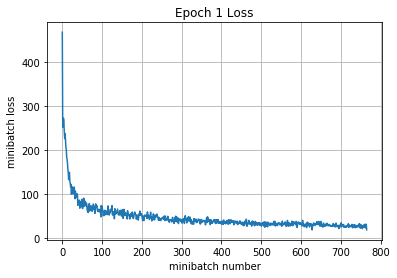

Validation
Epoch 1, Overall loss = 0.443 and accuracy of 0.39


In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [5]:
from math import ceil
from tensorflow.python.training.moving_averages import assign_moving_average

# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def compute_conv_outshape(in_height, in_width, filter_height, filter_width, strides, mode):
    out_height, out_width = 0, 0
    if mode == 'SAME':
        out_height = ceil(float(in_height) / float(strides[1]))
        out_width  = ceil(float(in_width) / float(strides[2]))
    elif mode == 'VALID':
        out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
        out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))
    else:
        raise ValueError('Invalid padding mode  "%s"' % mode)
    return out_height, out_width

def compute_max_pool_outshape(in_height, in_width, ksize, strides, mode):
    out_height, out_width = 0, 0
    if mode == 'SAME':
        out_height = ceil(float(in_height) / float(strides[1]))
        out_width  = ceil(float(in_width) / float(strides[2]))
    elif mode == 'VALID':
        out_height = ceil(float(in_height - ksize[1] + 1) / float(strides[1]))
        out_width  = ceil(float(in_width - ksize[2] + 1) / float(strides[2]))
    else:
        raise ValueError('Invalid padding mode  "%s"' % mode)
    return out_height, out_width

def batch_norm(x, train, eps = 1e-5, momentum = 0.9, affine = True, name = None):
    with  tf.variable_scope(name, default_name='BatchNorm2d'):
        params_shape = x.shape[-1:]
        axises = list(range(len(x.shape) - 1))
        moving_mean = tf.get_variable('moving_mean', shape=params_shape,
                                      initializer=tf.zeros_initializer,
                                      trainable=False)
        moving_variance = tf.get_variable('moving_variance', shape=params_shape,
                                          initializer=tf.ones_initializer,
                                          trainable=False)
        def mean_var_with_update():
            mean, variance = tf.nn.moments(x, axises, name='moments')
            with tf.control_dependencies([assign_moving_average(moving_mean, mean, momentum),
                                          assign_moving_average(moving_variance, variance, momentum)]):
                return tf.identity(mean), tf.identity(variance)
        mean, variance = tf.cond(train, mean_var_with_update, lambda: (moving_mean, moving_variance))
        if affine:
            beta = tf.get_variable('beta', params_shape,
                                   initializer=tf.zeros_initializer)
            gamma = tf.get_variable('gamma', params_shape,
                                    initializer=tf.ones_initializer)
            x = tf.nn.batch_normalization(x, mean, variance, beta, gamma, eps)
        else:
            x = tf.nn.batch_normalization(x, mean, variance, None, None, eps)
        return x
        

# define model
def complex_model(X,y,is_training):
    
    in_height = 32
    in_width = 32
    rgb = 3
    filter_height = 7
    filter_width = 7
    filters_num = 32
    strides=[1,1,1,1]
    mode = 'VALID'
    
    # 7x7 Convolutional Layer with 32 filters and stride of 1
    Wconv1 = tf.get_variable("Wconv1", shape=[filter_height, filter_width, rgb, filters_num])
    bconv1 = tf.get_variable("bconv1", shape=[filters_num])
    # Compute Output shape (N, conv_out_height,  conv_out_width,filters_num )
    conv_out_height, conv_out_width = compute_conv_outshape(in_height, in_width, filter_height, filter_width, strides, mode)
    
    # ReLU Activation Layer
    # Compute Output shape (N, conv_out_height,  conv_out_width,filters_num )
    
    # Batch Normalization Layer 
    # gamma1 = tf.get_variable("gamma1", shape=[filters_num])
    # beta1 = tf.get_variable("beta1", shape=[filters_num])
    # Compute Output shape (N, conv_out_height,  conv_out_width,filters_num )
    
    # 2x2 Max Pooling layer with a stride of 2
    ksize = [1,2,2,1]
    maxpool_strides = [1,2,2,1]
    maxpool_out_height, maxpool_out_width = compute_max_pool_outshape(conv_out_height, conv_out_width, ksize, maxpool_strides, mode)
    # Compute Output shape (N, maxpool_out_height,  maxpool_out_width, filters_num )

    # Affine layer with 1024 output units
    affine_output_units1 = 1024
    W1 = tf.get_variable("W1", shape=[(maxpool_out_height * maxpool_out_width * filters_num)  , affine_output_units1])
    b1 = tf.get_variable("b1", shape=[affine_output_units1])
    # Compute Output shape (N,  affine_output_units1 )

    # ReLU Activation Layer
    # Compute Output shape (N,  affine_output_units1 )
    
    #Affine layer from 1024 input units to 10 outputs
    affine_output_units2 = 10
    W2 = tf.get_variable("W2", shape=[affine_output_units1, affine_output_units2])
    b2 = tf.get_variable("b2", shape=[affine_output_units2])
    
    
    # define our graph 
    # 7x7 Convolutional Layer with 32 filters and stride of 1
    a1 = tf.nn.conv2d(X, Wconv1, strides=strides, padding=mode) + bconv1
    print (a1.shape) 
    # ReLU Activation Layer
    h1 = tf.nn.relu(a1)
    print (h1.shape)
    # Batch Normalization Layer 
    bn1 = batch_norm(h1, train = is_training)
    print (bn1.shape)
    # 2x2 Max Pooling layer with a stride of 2
    mp1 = tf.nn.max_pool(bn1, ksize, maxpool_strides,mode)
    print (mp1.shape)
    #Affine layer with 1024 output units
    mp1_reshape = tf.reshape(mp1,[-1,(maxpool_out_height * maxpool_out_width * filters_num)])
    print (mp1_reshape.shape)
    af1 = tf.matmul(mp1_reshape,W1) + b1
    print (af1.shape)
    # ReLU Activation Layer
    h2 = tf.nn.relu(af1)
    print (h2.shape)
    #Affine layer from 1024 input units to 10 outputs
    #h2_reshape = tf.reshape(h2,[-1,affine_output_units1])
    #print (h2_reshape.shape)
    y_out = tf.matmul(h2,W2) + b2
    print (y_out.shape)
    
    return y_out
    

y_out = complex_model(X,y,is_training)

(?, 26, 26, 32)
(?, 26, 26, 32)
(?, 26, 26, 32)
(?, 13, 13, 32)
(?, 5408)
(?, 1024)
(?, 1024)
(?, 10)


To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [6]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

99.9 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [7]:
try:
    with tf.Session() as sess:
        with tf.device("/cpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

97.1 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [8]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10), logits=y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
pass

In [9]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [10]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 3.07 and accuracy of 0.11
Iteration 100: with minibatch training loss = 1.43 and accuracy of 0.42
Iteration 200: with minibatch training loss = 1.13 and accuracy of 0.64
Iteration 300: with minibatch training loss = 1.2 and accuracy of 0.56
Iteration 400: with minibatch training loss = 1.44 and accuracy of 0.59
Iteration 500: with minibatch training loss = 1.11 and accuracy of 0.59
Iteration 600: with minibatch training loss = 1.01 and accuracy of 0.62
Iteration 700: with minibatch training loss = 1.22 and accuracy of 0.58
Epoch 1, Overall loss = 1.46 and accuracy of 0.516


(1.456844262200959, 0.51644897959183678)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [11]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.15 and accuracy of 0.604


(1.150823652267456, 0.60399999999999998)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [12]:
from cs231n.my_model import *

tf.reset_default_graph()

params = dict()
classifier =  tf.estimator.Estimator(model_fn=cnn_fn, params = params)

# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)


# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train.astype(np.float32)},
    y=y_train,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\FANGXI~1\\AppData\\Local\\Temp\\tmpvfa5txwp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000001AC557F0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:probabilities = [[ 0.          0.07560147  0.92437929  0.00000001  0.          0.          0.
   0.00001924  0.          0.        ]
 [ 0.          0.99999726  0.          0.          0.          0.          0.
 

INFO:tensorflow:loss = 24.5043, step = 1
INFO:tensorflow:probabilities = [[ 0.05794816  0.0991387   0.08518577  0.1061395   0.12246583  0.1406306
   0.12235191  0.08919982  0.09274532  0.08419445]
 [ 0.04782221  0.07007257  0.06387305  0.14529012  0.11377619  0.23710109
   0.13456683  0.07535296  0.06279477  0.04935022]
 [ 0.05519171  0.08002299  0.06737386  0.1195505   0.12186235  0.20670712
   0.12557237  0.08582836  0.05947293  0.07841787]
 [ 0.07972582  0.13049853  0.09047853  0.08449662  0.14109625  0.11132504
   0.1090006   0.08192643  0.08834527  0.08310696]
 [ 0.17541461  0.10028543  0.09082422  0.05943759  0.06700663  0.03583276
   0.06773379  0.12405192  0.11230393  0.16710915]
 [ 0.17346174  0.08887171  0.08504322  0.07426961  0.09399344  0.0674506
   0.09074831  0.10859332  0.10750627  0.11006185]
 [ 0.082605    0.0861053   0.08570434  0.13656981  0.1151361   0.14960174
   0.11525136  0.08650118  0.07732987  0.06519521]
 [ 0.06313426  0.0781187   0.07843659  0.12184765  0.1

INFO:tensorflow:global_step/sec: 0.793643
INFO:tensorflow:probabilities = [[ 0.03175372  0.49557915  0.03467501  0.01984079  0.01174418  0.02393097
   0.00948831  0.02342494  0.10888327  0.24067955]
 [ 0.0224724   0.22191904  0.10599666  0.24174042  0.06457362  0.09458949
   0.09040331  0.04661043  0.0683594   0.04333522]
 [ 0.08286344  0.06393048  0.1167969   0.06335003  0.03339896  0.03188449
   0.04744364  0.10848192  0.15876469  0.29308546]
 [ 0.07195457  0.03966751  0.08025985  0.05450679  0.05975713  0.02638138
   0.12511528  0.05276953  0.16535611  0.32423189]
 [ 0.01406615  0.19340587  0.06415199  0.26033485  0.106847    0.09556735
   0.11289559  0.06756071  0.02269284  0.06247764]
 [ 0.01094672  0.06321248  0.13754168  0.1219935   0.12214989  0.13122517
   0.20446302  0.17180525  0.01558523  0.02107706]
 [ 0.00099512  0.01601033  0.09507726  0.00913594  0.20342529  0.00929799
   0.0670756   0.59683537  0.00054763  0.00159942]
 [ 0.01149408  0.04095624  0.11119469  0.21926746  

INFO:tensorflow:loss = 1.80078, step = 101 (126.058 sec)
INFO:tensorflow:probabilities = [[ 0.09359381  0.01666112  0.02841164  0.00188989  0.00465808  0.00381252
   0.00034202  0.00610503  0.83917868  0.00534724]
 [ 0.07565626  0.11717808  0.11674921  0.09377336  0.11739186  0.13230903
   0.14410876  0.0827505   0.05721116  0.06287172]
 [ 0.09282674  0.46832293  0.03873196  0.05293035  0.03592639  0.08683997
   0.01393765  0.02959815  0.04923522  0.13165058]
 [ 0.00759373  0.0462125   0.02240247  0.11616119  0.04115213  0.11957751
   0.15420984  0.31227788  0.00615248  0.17426032]
 [ 0.04441408  0.09844273  0.1075526   0.13988505  0.0972344   0.17757702
   0.07364112  0.13797042  0.03342801  0.08985453]
 [ 0.05305907  0.08727496  0.02344005  0.04211384  0.00651498  0.0158025
   0.01764222  0.00734586  0.58646345  0.16034307]
 [ 0.16575786  0.09583518  0.09281237  0.11054169  0.07864236  0.06390372
   0.07490908  0.06634667  0.10844295  0.14280809]
 [ 0.15629026  0.01330683  0.01037257

INFO:tensorflow:global_step/sec: 0.79531
INFO:tensorflow:probabilities = [[ 0.1066547   0.29767838  0.06408794  0.04353138  0.07258227  0.02787677
   0.01651412  0.11455901  0.13910748  0.11740796]
 [ 0.00879351  0.09153858  0.00784877  0.04747405  0.04714199  0.05679098
   0.08554996  0.11474444  0.00908279  0.53103495]
 [ 0.00461441  0.00027455  0.06670375  0.09559917  0.05904515  0.01225087
   0.72761035  0.02971664  0.00016927  0.00401581]
 [ 0.02650147  0.07981495  0.04730983  0.18368168  0.0431708   0.05336842
   0.04533893  0.04645528  0.04406276  0.43029597]
 [ 0.10135745  0.30540922  0.04050718  0.00444698  0.01420822  0.01098178
   0.02045585  0.00401752  0.01993385  0.47868183]
 [ 0.03386958  0.52157342  0.00809647  0.05820382  0.03903221  0.04553127
   0.01983665  0.01649325  0.1146519   0.14271136]
 [ 0.03059538  0.04120712  0.17739485  0.06498762  0.14522159  0.12630449
   0.27141404  0.12414499  0.0078691   0.01086079]
 [ 0.25865847  0.01085365  0.24154964  0.03769053  0

INFO:tensorflow:loss = 1.63247, step = 201 (125.737 sec)
INFO:tensorflow:probabilities = [[ 0.08517992  0.01396158  0.18135668  0.19069876  0.12807108  0.07080505
   0.13220653  0.10171013  0.07784887  0.01816137]
 [ 0.00589003  0.36848575  0.02700145  0.09391383  0.04627337  0.01850182
   0.19381338  0.01632652  0.01808007  0.21171387]
 [ 0.0005086   0.04972     0.00380318  0.56226945  0.01744862  0.06866489
   0.01259341  0.24291997  0.00026348  0.04180846]
 [ 0.05531454  0.01587146  0.19962634  0.06752274  0.15355827  0.1045515
   0.16369624  0.18907835  0.01372527  0.03705524]
 [ 0.05844969  0.56080967  0.00745612  0.00449485  0.01240864  0.01219381
   0.00571756  0.00579706  0.20400798  0.12866469]
 [ 0.05610709  0.00363157  0.21433392  0.28755647  0.03098972  0.04300044
   0.01001479  0.09639533  0.24604195  0.01192869]
 [ 0.00195121  0.00081413  0.05335901  0.41830832  0.03131517  0.36172879
   0.00433945  0.12433006  0.00116764  0.00268614]
 [ 0.00523453  0.0063208   0.04861679

INFO:tensorflow:global_step/sec: 0.811339
INFO:tensorflow:probabilities = [[ 0.28402057  0.05383347  0.20519117  0.07926842  0.06574252  0.04896414
   0.14359848  0.04877685  0.03789717  0.03270723]
 [ 0.00951754  0.03343583  0.03383547  0.20154648  0.08660588  0.17290151
   0.13162963  0.30849391  0.01020965  0.01182406]
 [ 0.08562312  0.29967499  0.00423231  0.00090674  0.0041543   0.00289658
   0.00096179  0.00243204  0.44368812  0.15543002]
 [ 0.0010409   0.0097812   0.07645217  0.51000631  0.02458496  0.23455043
   0.03358398  0.0886573   0.00237082  0.01897195]
 [ 0.04693881  0.23178962  0.14467537  0.09976067  0.04757766  0.0683381
   0.03699785  0.06887728  0.01766109  0.23738353]
 [ 0.0089312   0.01051805  0.2259059   0.08632311  0.28900391  0.09130451
   0.21240954  0.06760302  0.00232029  0.00568048]
 [ 0.02008893  0.12814113  0.09654841  0.17652796  0.13682093  0.15965752
   0.04595084  0.17537604  0.01514761  0.04574056]
 [ 0.01070806  0.00554439  0.03368349  0.12273395  0

INFO:tensorflow:loss = 1.58006, step = 301 (123.250 sec)
INFO:tensorflow:probabilities = [[ 0.06604332  0.08742325  0.03397828  0.15412207  0.04873535  0.0490064
   0.03618391  0.08798414  0.19307421  0.24344906]
 [ 0.02100353  0.01822855  0.26002312  0.12660016  0.17954083  0.13157481
   0.21447477  0.03150701  0.00604076  0.01100646]
 [ 0.1388972   0.22352728  0.11393774  0.07069559  0.04230556  0.01285106
   0.01198471  0.05009464  0.28856564  0.04714058]
 [ 0.00285098  0.02809307  0.08219603  0.08276223  0.36909291  0.13432521
   0.10845601  0.17944936  0.00256489  0.01020921]
 [ 0.15095024  0.09135674  0.1004871   0.02039193  0.05810818  0.0168293
   0.01107539  0.05271349  0.4053582   0.09272946]
 [ 0.00506013  0.0023971   0.14366871  0.01792384  0.38438568  0.07359838
   0.14752996  0.22174218  0.00213977  0.0015541 ]
 [ 0.01465927  0.03617292  0.088778    0.07182965  0.14682212  0.32867539
   0.12566473  0.16934712  0.00341001  0.01464081]
 [ 0.60315686  0.04644781  0.05528896 

INFO:tensorflow:global_step/sec: 0.796831
INFO:tensorflow:probabilities = [[ 0.00506482  0.07283967  0.01757313  0.03610133  0.03852673  0.01843695
   0.05802255  0.65841126  0.00430832  0.09071524]
 [ 0.3706519   0.17865163  0.01477843  0.00891227  0.01876278  0.00625163
   0.00151473  0.00487566  0.34698001  0.04862095]
 [ 0.14766069  0.04219259  0.02193307  0.05093521  0.0040889   0.0290106
   0.02416466  0.01912196  0.16730873  0.49358359]
 [ 0.01940311  0.02341837  0.21038109  0.15643483  0.28533581  0.1266486
   0.08643951  0.06690367  0.01165179  0.01338315]
 [ 0.03430708  0.06146223  0.02725647  0.35681912  0.03090034  0.22399645
   0.01220798  0.08648519  0.06418318  0.10238199]
 [ 0.53845769  0.0099655   0.00119667  0.0001336   0.00129665  0.00004498
   0.00007252  0.00060977  0.02973649  0.41848612]
 [ 0.33830392  0.00039483  0.35420641  0.09887916  0.13793871  0.0060237
   0.02873091  0.02100044  0.00665182  0.00787012]
 [ 0.00357879  0.00265197  0.09900965  0.25004414  0.0

INFO:tensorflow:loss = 1.54316, step = 401 (125.502 sec)
INFO:tensorflow:probabilities = [[ 0.19351105  0.05298931  0.06402364  0.01916489  0.26816323  0.00740478
   0.00344538  0.02339913  0.35752651  0.01037202]
 [ 0.00611856  0.00380843  0.05283618  0.40512124  0.13734809  0.3008005
   0.05085346  0.04072704  0.0007297   0.00165687]
 [ 0.07041907  0.21800499  0.11620586  0.08988331  0.04843586  0.0686642
   0.01373262  0.16767074  0.01044375  0.19653958]
 [ 0.05242319  0.02949111  0.13182484  0.36343408  0.19481812  0.04835541
   0.00899547  0.08247823  0.02986668  0.0583129 ]
 [ 0.56714088  0.00762951  0.08914536  0.13235871  0.04195574  0.04040717
   0.03203994  0.00721468  0.07037812  0.01173   ]
 [ 0.41134974  0.02109583  0.00150238  0.00021268  0.00143501  0.00018495
   0.0000247   0.00014854  0.55910599  0.00494019]
 [ 0.05102653  0.04652234  0.08263834  0.21742584  0.09263098  0.19939588
   0.15882309  0.06613494  0.04915944  0.03624254]
 [ 0.00520593  0.00451342  0.15481448 

INFO:tensorflow:Saving checkpoints for 474 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.749757
INFO:tensorflow:probabilities = [[ 0.10653543  0.09911726  0.00620196  0.01232852  0.00562322  0.00234436
   0.00241873  0.00328614  0.57584763  0.18629673]
 [ 0.00319651  0.00119576  0.14025262  0.0371399   0.07029539  0.10519946
   0.00373533  0.63735628  0.00023996  0.00138883]
 [ 0.01398664  0.00047354  0.26301721  0.27285725  0.1788771   0.07283331
   0.18462212  0.01049457  0.00208687  0.00075146]
 [ 0.26126051  0.17201854  0.01844652  0.023891    0.05328613  0.0085256
   0.00642555  0.01247776  0.16923514  0.27443328]
 [ 0.05967022  0.00336257  0.34518817  0.16520634  0.20870836  0.0645181
   0.04884494  0.06850912  0.01220159  0.02379068]
 [ 0.01192586  0.00008728  0.16080578  0.01006224  0.038342    0.01854523
   0.00024713  0.75742024  0.00071716  0.00184707]
 [ 0.00320215  0.88720179  0.00141819  0.00443382  0.00111085  0.0005

INFO:tensorflow:loss = 1.38469, step = 501 (133.419 sec)
INFO:tensorflow:probabilities = [[ 0.0241028   0.00326031  0.14065503  0.42176408  0.05687021  0.31161135
   0.0076936   0.02711919  0.00541681  0.00150669]
 [ 0.00001579  0.00000066  0.02465055  0.00758209  0.0072153   0.00078888
   0.95447439  0.00526382  0.0000005   0.00000811]
 [ 0.00445548  0.01743682  0.08007227  0.06564427  0.21267493  0.05607656
   0.38923225  0.13602987  0.00172196  0.03665566]
 [ 0.01777959  0.00874357  0.09057175  0.09613278  0.09725224  0.38838986
   0.04325467  0.18361108  0.05789899  0.01636559]
 [ 0.448266    0.0527149   0.15142393  0.01402783  0.05137746  0.02034209
   0.06134077  0.03759026  0.07558091  0.08733581]
 [ 0.00518625  0.00161714  0.24426307  0.00472818  0.67187947  0.02241706
   0.04391344  0.00555414  0.00031921  0.0001221 ]
 [ 0.0462124   0.01175172  0.10196066  0.31717905  0.12835473  0.28449792
   0.02100264  0.05920229  0.02253547  0.00730308]
 [ 0.05101246  0.01355532  0.1462911

INFO:tensorflow:global_step/sec: 0.795715
INFO:tensorflow:probabilities = [[ 0.00205405  0.02569585  0.03247461  0.48119557  0.04664086  0.27550706
   0.08220381  0.02693622  0.00367383  0.02361822]
 [ 0.00007452  0.00021286  0.33679453  0.06726486  0.00645912  0.57892942
   0.00030419  0.00993347  0.00000652  0.00002051]
 [ 0.00892075  0.00060424  0.15946946  0.3082597   0.01459974  0.23110417
   0.00851222  0.24332017  0.00861312  0.0165964 ]
 [ 0.35761866  0.03861197  0.00443106  0.00057121  0.00319947  0.00043202
   0.00062011  0.00453396  0.16000356  0.42997801]
 [ 0.14643353  0.02333486  0.02035504  0.01031745  0.06663952  0.02635041
   0.00384076  0.20984766  0.02832623  0.46455449]
 [ 0.01372501  0.00134589  0.07004608  0.22278902  0.04458126  0.22647339
   0.02610639  0.38216284  0.01174873  0.00102142]
 [ 0.00286419  0.00055289  0.09488168  0.08237673  0.46626121  0.11051808
   0.22896215  0.01329574  0.00013152  0.00015583]
 [ 0.08424567  0.32953542  0.00041762  0.0008468   

INFO:tensorflow:loss = 1.18992, step = 601 (125.648 sec)
INFO:tensorflow:probabilities = [[ 0.00633284  0.00000958  0.31927851  0.00628102  0.30007058  0.00170647
   0.36510038  0.00119437  0.0000138   0.00001239]
 [ 0.79859108  0.01877379  0.01342358  0.04012603  0.04085985  0.03518371
   0.0180312   0.00551287  0.01921707  0.01028089]
 [ 0.54553425  0.16457063  0.00351889  0.00003567  0.00035038  0.00000993
   0.0000008   0.00001613  0.28371665  0.00224652]
 [ 0.06136021  0.10009661  0.10919169  0.10580709  0.04122411  0.0364062
   0.09939835  0.05835161  0.03151453  0.35664961]
 [ 0.00766102  0.02976037  0.0006715   0.00116123  0.00068818  0.00071354
   0.00037228  0.00020283  0.95405608  0.00471293]
 [ 0.03327965  0.12033055  0.1008134   0.24797232  0.02800774  0.21172349
   0.00430069  0.04257094  0.03033909  0.18066214]
 [ 0.00014319  0.0000177   0.00008829  0.00056835  0.00028208  0.00005122
   0.00000159  0.99883431  0.0000006   0.00001273]
 [ 0.00895616  0.01595153  0.22017263

INFO:tensorflow:global_step/sec: 0.832661
INFO:tensorflow:probabilities = [[ 0.00241913  0.00220762  0.06280176  0.11708719  0.0448025   0.02256467
   0.74393624  0.00164251  0.00115615  0.00138213]
 [ 0.00051611  0.00022639  0.00733908  0.00103433  0.0034599   0.00008045
   0.98719949  0.0000347   0.00008246  0.00002705]
 [ 0.01201186  0.00207995  0.01876479  0.01310194  0.00983452  0.01313258
   0.92650163  0.00145231  0.00108603  0.00203447]
 [ 0.00364757  0.03705467  0.01834668  0.06194899  0.00551834  0.00809598
   0.02801807  0.02689632  0.01398899  0.79648441]
 [ 0.10207676  0.12331116  0.038248    0.03333847  0.04702883  0.10626471
   0.00916652  0.12996055  0.27686727  0.1337377 ]
 [ 0.00002474  0.00016285  0.0280216   0.11607244  0.00371732  0.00092313
   0.85078323  0.00023378  0.00000768  0.00005314]
 [ 0.18050289  0.05944145  0.14340943  0.09392724  0.08464988  0.02023696
   0.05278007  0.02011205  0.23970248  0.1052375 ]
 [ 0.01456754  0.0068567   0.27006784  0.02956418  

INFO:tensorflow:loss = 1.29442, step = 701 (120.055 sec)
INFO:tensorflow:probabilities = [[ 0.07398126  0.14677925  0.05318109  0.07362889  0.11680282  0.0303171
   0.02038372  0.17521691  0.08736565  0.22234334]
 [ 0.00332857  0.00213453  0.23315871  0.02420228  0.59934556  0.1122888
   0.00856708  0.01636326  0.00021963  0.00039169]
 [ 0.05588679  0.07494898  0.0531401   0.57145101  0.02016602  0.04050149
   0.00944793  0.02181708  0.08510539  0.06753518]
 [ 0.99968612  0.00000002  0.00028968  0.          0.00000019  0.          0.
   0.          0.0000239   0.        ]
 [ 0.00131888  0.00025827  0.01514619  0.49869853  0.01349605  0.43941358
   0.00991967  0.01350221  0.00779376  0.00045283]
 [ 0.00197485  0.00001677  0.35709891  0.00437607  0.20711774  0.0066675
   0.37915641  0.04354028  0.00000789  0.00004369]
 [ 0.00424321  0.00624983  0.66506171  0.01557359  0.13219547  0.08014626
   0.06971342  0.01512209  0.0013248   0.01036961]
 [ 0.016951    0.02741623  0.00590661  0.765474

INFO:tensorflow:global_step/sec: 0.847373
INFO:tensorflow:probabilities = [[ 0.09664149  0.00170508  0.00133759  0.00000778  0.00044972  0.00000251
   0.00000065  0.0000026   0.89984     0.00001253]
 [ 0.05871853  0.7733292   0.01050204  0.0004147   0.00053925  0.00063763
   0.01038383  0.00166262  0.0016571   0.14215523]
 [ 0.00104288  0.03677933  0.06868597  0.30932674  0.14567932  0.17122732
   0.14222041  0.1072946   0.00011901  0.0176244 ]
 [ 0.00148551  0.00130366  0.0817854   0.33049661  0.25563866  0.18281907
   0.00448444  0.12738496  0.00013272  0.01446893]
 [ 0.32714733  0.01628799  0.35006618  0.01684097  0.02029651  0.04628012
   0.01143612  0.02225992  0.18295471  0.00643028]
 [ 0.00031145  0.00020778  0.19618355  0.24334222  0.01480765  0.42886299
   0.00104999  0.11105426  0.00361805  0.00056205]
 [ 0.00065123  0.00028808  0.00375481  0.0067153   0.00415497  0.00461871
   0.97919297  0.00016041  0.00026433  0.00019922]
 [ 0.19690698  0.31927326  0.00418685  0.01757327  

INFO:tensorflow:loss = 1.19685, step = 801 (117.981 sec)
INFO:tensorflow:probabilities = [[ 0.00038049  0.00012895  0.00280895  0.23413981  0.00658342  0.74390107
   0.00284645  0.00100997  0.0076947   0.00050618]
 [ 0.0024142   0.07270097  0.20554937  0.42687193  0.05444901  0.05300976
   0.06310874  0.03355494  0.0018031   0.08653796]
 [ 0.02861973  0.00079674  0.07514106  0.20003884  0.00685205  0.51858807
   0.01376575  0.15292327  0.00234476  0.00092978]
 [ 0.00201969  0.00161958  0.02871188  0.04454076  0.01381102  0.13676861
   0.03855686  0.72858894  0.00038001  0.00500262]
 [ 0.72661877  0.01819512  0.07259088  0.00097157  0.05249414  0.00134246
   0.00111774  0.00223504  0.03895779  0.08547651]
 [ 0.12146746  0.00557757  0.00497638  0.00008852  0.00011561  0.0000136
   0.00000794  0.00004733  0.86569464  0.00201093]
 [ 0.00655846  0.00288596  0.18312453  0.21430922  0.11597593  0.0420358
   0.29460761  0.13186608  0.00072382  0.00791254]
 [ 0.3668524   0.02400081  0.00148685 

INFO:tensorflow:global_step/sec: 0.865542
INFO:tensorflow:probabilities = [[ 0.00251348  0.36400357  0.04434742  0.25066695  0.01044401  0.17196393
   0.02923301  0.00462023  0.00284176  0.11936564]
 [ 0.05465954  0.03907845  0.05711109  0.23431669  0.06139553  0.11268184
   0.15971358  0.06351771  0.09763549  0.11989009]
 [ 0.12556683  0.00061111  0.03509527  0.13042946  0.40214497  0.03654188
   0.00417958  0.12476181  0.04220195  0.09846716]
 [ 0.86442173  0.05559951  0.00431075  0.00022496  0.00252286  0.00000256
   0.00003754  0.00017113  0.06414271  0.00856623]
 [ 0.03076051  0.03217114  0.15617366  0.11501219  0.01927212  0.04610917
   0.2998288   0.04590803  0.01413207  0.24063227]
 [ 0.02834941  0.00989003  0.09427857  0.0591028   0.00804512  0.19290653
   0.00490451  0.12626095  0.01002858  0.46623349]
 [ 0.81784344  0.01079565  0.00008928  0.00000039  0.00092491  0.00000038
   0.00000028  0.00002479  0.17022155  0.00009925]
 [ 0.36314869  0.00360955  0.0009635   0.00012453  

INFO:tensorflow:loss = 1.23869, step = 901 (115.584 sec)
INFO:tensorflow:probabilities = [[ 0.22266619  0.60449219  0.06029877  0.00342684  0.00629065  0.00228646
   0.00346955  0.00704038  0.03913875  0.0508903 ]
 [ 0.00040882  0.00099921  0.00305162  0.27586296  0.003299    0.7100876
   0.0028859   0.00251969  0.00074057  0.00014456]
 [ 0.24078724  0.0481483   0.03673911  0.00254562  0.00625205  0.00078356
   0.00103621  0.14411402  0.22380564  0.29578826]
 [ 0.00588668  0.01242375  0.06941056  0.45749688  0.04236306  0.22683775
   0.15194875  0.00935442  0.00443746  0.01984067]
 [ 0.0094736   0.00080985  0.03973836  0.57704479  0.04332365  0.27849337
   0.01894328  0.03105484  0.00076364  0.0003547 ]
 [ 0.25316626  0.02370475  0.03906224  0.00379045  0.04143481  0.00872001
   0.00172885  0.00072429  0.61870217  0.0089661 ]
 [ 0.00039587  0.0000003   0.00144511  0.00286863  0.00218799  0.01714571
   0.00016455  0.97578168  0.00000134  0.00000868]
 [ 0.13827398  0.02423104  0.27309513

INFO:tensorflow:Saving checkpoints for 973 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.845089
INFO:tensorflow:probabilities = [[ 0.00022232  0.00016341  0.00139495  0.24677643  0.01209156  0.73502105
   0.00073342  0.00233225  0.00120494  0.00005963]
 [ 0.03276816  0.00000057  0.03306437  0.00294985  0.89923882  0.00079386
   0.0000147   0.02758149  0.00350398  0.00008411]
 [ 0.34407896  0.03710803  0.08239486  0.02320066  0.03993683  0.02208295
   0.01670512  0.01712414  0.39464274  0.02272576]
 [ 0.00144921  0.83710474  0.00009407  0.01079371  0.00135849  0.00044217
   0.0008656   0.00004772  0.00038834  0.14745583]
 [ 0.0000269   0.00002525  0.02555426  0.01086851  0.17977494  0.02314425
   0.01553763  0.74506259  0.00000072  0.00000497]
 [ 0.00828063  0.07644259  0.01826738  0.00261803  0.00279506  0.00200995
   0.00152862  0.00303158  0.01468494  0.87034124]
 [ 0.00000289  0.96723068  0.          0.00000011  0.00000002  0.  

INFO:tensorflow:loss = 0.76567, step = 1001 (118.281 sec)
INFO:tensorflow:probabilities = [[ 0.00116572  0.00012371  0.00000344  0.00000002  0.00000303  0.00000003
   0.00000001  0.          0.99868661  0.00001739]
 [ 0.00007003  0.0000258   0.01553069  0.00040377  0.00582994  0.00018918
   0.97790629  0.00002769  0.00000133  0.00001523]
 [ 0.00000744  0.00000009  0.71717238  0.16675474  0.0103579   0.10137796
   0.00422173  0.00002533  0.00000022  0.00008213]
 [ 0.00011355  0.00000047  0.00104134  0.0018787   0.00048541  0.00000634
   0.98047596  0.00000104  0.01599498  0.00000218]
 [ 0.00025581  0.00028349  0.25885916  0.0518034   0.09445927  0.35489503
   0.17579158  0.03427655  0.00071533  0.02866048]
 [ 0.00306757  0.00669661  0.00283014  0.50812674  0.00781716  0.46321401
   0.00171795  0.00112114  0.00280685  0.0026018 ]
 [ 0.00000049  0.00001008  0.0017842   0.00099102  0.00053161  0.00023217
   0.99590921  0.00053987  0.00000019  0.00000121]
 [ 0.00003055  0.00001897  0.019802

INFO:tensorflow:global_step/sec: 0.865107
INFO:tensorflow:probabilities = [[ 0.19016111  0.07297016  0.1354697   0.01749662  0.03170713  0.00902877
   0.00274033  0.01218695  0.51268154  0.01555775]
 [ 0.00358803  0.99133193  0.0000275   0.00000088  0.00000167  0.00000371
   0.00000002  0.00071264  0.00015673  0.00417708]
 [ 0.95035309  0.00000118  0.02425687  0.00000725  0.00186055  0.00000061
   0.00000039  0.00000108  0.02351823  0.00000078]
 [ 0.0010452   0.97435296  0.00004765  0.00000174  0.00200778  0.00000511
   0.00002303  0.00002336  0.00268099  0.01981213]
 [ 0.0051776   0.00184654  0.03278596  0.00694603  0.2912752   0.00468674
   0.00014674  0.65579343  0.00120841  0.00013339]
 [ 0.00000171  0.00183672  0.00343725  0.16075081  0.00019385  0.51318592
   0.31739104  0.00307948  0.00000108  0.00012213]
 [ 0.04395878  0.40746096  0.07510673  0.01216283  0.00519195  0.00616414
   0.01238598  0.16574951  0.14408481  0.12773444]
 [ 0.00279932  0.00336042  0.00006945  0.00000572  

INFO:tensorflow:loss = 0.779658, step = 1101 (115.615 sec)
INFO:tensorflow:probabilities = [[ 0.00019085  0.00101865  0.01690255  0.01869486  0.06582453  0.00321316
   0.00575676  0.88789845  0.00000571  0.00049436]
 [ 0.00442679  0.00000772  0.48642811  0.00003268  0.50470299  0.00397043
   0.0003763   0.00005083  0.00000256  0.00000153]
 [ 0.0061056   0.05916725  0.00052289  0.0004397   0.00015493  0.00087493
   0.00039822  0.00011898  0.0069924   0.92522508]
 [ 0.00008293  0.00003735  0.01020175  0.05475016  0.00537229  0.90787894
   0.00023432  0.02134093  0.00007073  0.00003057]
 [ 0.00012163  0.00002936  0.05670016  0.03048661  0.74705464  0.13225995
   0.00073932  0.03249084  0.00000355  0.00011381]
 [ 0.00314595  0.00365545  0.01388684  0.53639734  0.00983344  0.08544593
   0.12392247  0.2121699   0.00114731  0.01039545]
 [ 0.05677899  0.0829335   0.25474322  0.04379107  0.11827722  0.20724164
   0.06047088  0.10848761  0.00788907  0.05938682]
 [ 0.00000493  0.00000002  0.55226

INFO:tensorflow:global_step/sec: 0.865347
INFO:tensorflow:probabilities = [[ 0.02783367  0.00032836  0.00000623  0.00000149  0.00000757  0.00000014
   0.00000003  0.00000012  0.9708544   0.000968  ]
 [ 0.00509527  0.00851771  0.00674628  0.02890449  0.53396976  0.03019801
   0.00166187  0.38168541  0.00169102  0.00153015]
 [ 0.00032436  0.00002555  0.01920801  0.01833064  0.01742448  0.92966193
   0.00907413  0.00588414  0.0000667   0.00000016]
 [ 0.0102818   0.01265098  0.00237736  0.00906685  0.6890521   0.08123426
   0.15018411  0.01685696  0.00070649  0.02758906]
 [ 0.71092474  0.03348015  0.01431235  0.0018848   0.02238649  0.00318223
   0.00033233  0.00896609  0.19505645  0.00947421]
 [ 0.00117004  0.00001342  0.00060471  0.35865313  0.00168192  0.62701076
   0.00106626  0.0097441   0.00002155  0.00003419]
 [ 0.00060789  0.00078564  0.00079027  0.00000942  0.00065533  0.00008099
   0.0000073   0.00230626  0.00028216  0.99447471]
 [ 0.00000631  0.00000016  0.00478938  0.00294871  

INFO:tensorflow:loss = 0.638971, step = 1201 (115.541 sec)
INFO:tensorflow:probabilities = [[ 0.02725358  0.00889246  0.00228961  0.0036581   0.0024571   0.00049405
   0.00006084  0.00074576  0.94607288  0.00807557]
 [ 0.00000329  0.3856383   0.00000266  0.00000214  0.00000032  0.00000124
   0.00026137  0.00000035  0.00000404  0.61408633]
 [ 0.05860741  0.00041618  0.00009001  0.00000035  0.00010337  0.00000003
   0.          0.0000003   0.9405061   0.00027631]
 [ 0.00042213  0.00001461  0.00160908  0.00013976  0.00082243  0.00017556
   0.28093299  0.71578938  0.00000026  0.00009379]
 [ 0.33262384  0.52726948  0.00043105  0.00005309  0.00005002  0.0000229
   0.00000038  0.00023602  0.09531532  0.04399776]
 [ 0.29162252  0.0005883   0.0888591   0.00077696  0.005506    0.00015544
   0.00016266  0.00056799  0.58195883  0.02980216]
 [ 0.02252853  0.00147862  0.24911176  0.00627467  0.38543895  0.01893795
   0.29707846  0.01771405  0.00055708  0.00087988]
 [ 0.00162694  0.02239003  0.243172

INFO:tensorflow:global_step/sec: 0.864539
INFO:tensorflow:probabilities = [[ 0.00014543  0.1727417   0.00005012  0.00000722  0.00000516  0.00000121
   0.00008188  0.00001844  0.00273942  0.82420951]
 [ 0.99819845  0.00000001  0.0017948   0.          0.00000025  0.          0.
   0.          0.00000649  0.        ]
 [ 0.0750099   0.00114846  0.00312329  0.00042543  0.00035313  0.00011823
   0.00007549  0.00950192  0.00943436  0.90080976]
 [ 0.00005161  0.00000015  0.00616492  0.0000336   0.00062353  0.00006146
   0.00007096  0.99297345  0.00000015  0.00002021]
 [ 0.          0.99996066  0.          0.          0.          0.          0.
   0.          0.00000002  0.00003932]
 [ 0.05183049  0.01355526  0.0012515   0.00139779  0.0040813   0.00013275
   0.0006805   0.00113269  0.03008595  0.89585173]
 [ 0.93442404  0.00004162  0.0051415   0.00011436  0.00216465  0.00000658
   0.00001325  0.00003184  0.05805339  0.00000857]
 [ 0.00001368  0.00001712  0.009262    0.0000616   0.97840309  0.00

INFO:tensorflow:loss = 0.733493, step = 1301 (115.694 sec)
INFO:tensorflow:probabilities = [[ 0.00010225  0.00000256  0.18259817  0.01348041  0.45101795  0.00960555
   0.31433982  0.02884386  0.00000015  0.00000921]
 [ 0.00008898  0.00000044  0.23352516  0.00329732  0.45103002  0.00990019
   0.29254016  0.0096143   0.00000065  0.00000281]
 [ 0.00841943  0.02180872  0.03647655  0.26808542  0.21481822  0.25164309
   0.09432166  0.08402652  0.00963482  0.01076557]
 [ 0.00000151  0.00000929  0.0000908   0.00011062  0.00178103  0.00043428
   0.00001282  0.99755907  0.00000051  0.00000009]
 [ 0.00105584  0.9906894   0.00000807  0.00000019  0.00023123  0.00002368
   0.00000051  0.00000557  0.00197482  0.00601064]
 [ 0.00230342  0.00003479  0.20786613  0.47002977  0.00072859  0.27024892
   0.00000379  0.04873484  0.00003017  0.00001947]
 [ 0.0006023   0.00086633  0.06975611  0.07519254  0.14908285  0.20724849
   0.07956231  0.41735062  0.00008707  0.00025134]
 [ 0.02559352  0.45070118  0.02233

INFO:tensorflow:global_step/sec: 0.861396
INFO:tensorflow:probabilities = [[ 0.00011146  0.0001592   0.00000002  0.          0.          0.          0.
   0.          0.99972922  0.0000001 ]
 [ 0.00159446  0.00208964  0.4116317   0.26567253  0.0330176   0.08286706
   0.02036298  0.06076145  0.02069198  0.10131057]
 [ 0.00027955  0.00264153  0.01802464  0.30936155  0.00041814  0.00339741
   0.60689628  0.00806911  0.00022801  0.05068377]
 [ 0.0000214   0.00001698  0.00264468  0.06040756  0.00145142  0.93519706
   0.00014468  0.00011149  0.00000352  0.00000121]
 [ 0.03246439  0.00589754  0.00799856  0.01811454  0.79529577  0.00742734
   0.00529126  0.11034802  0.00087585  0.01628679]
 [ 0.05715512  0.16131045  0.00941431  0.07527162  0.00032773  0.00601088
   0.01261117  0.01541389  0.03262242  0.62986243]
 [ 0.00008256  0.00339243  0.26582488  0.01714199  0.3513687   0.00319675
   0.01935822  0.33923584  0.00000047  0.00039813]
 [ 0.44051504  0.00031364  0.5400176   0.01152436  0.003121

INFO:tensorflow:loss = 0.692695, step = 1401 (116.064 sec)
INFO:tensorflow:probabilities = [[ 0.21801539  0.12282698  0.00743682  0.01731054  0.00595587  0.00075165
   0.00496926  0.00004375  0.00209413  0.62059557]
 [ 0.00128264  0.01119921  0.00000078  0.00003275  0.00000193  0.00000075
   0.00000024  0.00015745  0.0006984   0.98662591]
 [ 0.00001726  0.00000005  0.13726057  0.00028788  0.66414225  0.1600734
   0.03821765  0.0000006   0.          0.0000004 ]
 [ 0.00026583  0.00000544  0.00316331  0.03935229  0.00094384  0.08815864
   0.86387795  0.00020499  0.00320535  0.00082246]
 [ 0.0831375   0.00383793  0.43178478  0.01517463  0.43527788  0.00241844
   0.02624716  0.00002961  0.0018454   0.00024673]
 [ 0.00011481  0.0000021   0.05439231  0.6899159   0.06356958  0.00432208
   0.18732953  0.00007198  0.00021467  0.00006707]
 [ 0.00017273  0.04728012  0.00000003  0.          0.          0.          0.
   0.          0.00000179  0.9525454 ]
 [ 0.00053818  0.71863395  0.0030754   0.00

INFO:tensorflow:Saving checkpoints for 1490 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.839907
INFO:tensorflow:probabilities = [[ 0.00120582  0.0138991   0.04325766  0.30997583  0.40949124  0.05422561
   0.05326098  0.04403493  0.0628123   0.00783657]
 [ 0.00097225  0.00023513  0.00001613  0.01140297  0.0000012   0.00000174
   0.00000002  0.00020431  0.03892407  0.94824213]
 [ 0.0000001   0.99966836  0.          0.          0.          0.          0.
   0.          0.00000006  0.00033138]
 [ 0.9646104   0.          0.03284134  0.00000488  0.00254176  0.0000003
   0.00000061  0.          0.0000008   0.        ]
 [ 0.00575995  0.00036264  0.01198811  0.00344521  0.04093846  0.0003321
   0.00226699  0.92685413  0.00000882  0.00804369]
 [ 0.04385551  0.01093361  0.26952296  0.01397982  0.3700999   0.04400234
   0.0412484   0.183557    0.01437037  0.00843008]
 [ 0.39153013  0.00408189  0.53489113  0.0050597   0.04571984  0.00023954
  

INFO:tensorflow:loss = 0.702873, step = 1501 (119.061 sec)
INFO:tensorflow:probabilities = [[ 0.00023348  0.00001412  0.09229511  0.00615201  0.21002223  0.0449529
   0.52661818  0.11969274  0.00001464  0.00000463]
 [ 0.00029546  0.00484386  0.27229792  0.00142437  0.71407843  0.00162923
   0.00445338  0.00076238  0.00003648  0.0001784 ]
 [ 0.00015266  0.00001132  0.00292518  0.0028169   0.01968898  0.96732247
   0.00038198  0.00296201  0.00348138  0.00025701]
 [ 0.00000125  0.00000006  0.00001483  0.0000012   0.01308652  0.00001891
   0.00000014  0.98687685  0.00000014  0.00000018]
 [ 0.02524564  0.00684147  0.08003878  0.23123039  0.1736764   0.0509143
   0.3572441   0.01871537  0.04728046  0.00881313]
 [ 0.99289435  0.00001381  0.00420669  0.00041726  0.00243019  0.00002373
   0.00000004  0.00000623  0.00000671  0.00000087]
 [ 0.          0.          0.0002996   0.00352492  0.00000527  0.99562234
   0.00000016  0.00054779  0.          0.        ]
 [ 0.00001972  0.00000577  0.4021122

INFO:tensorflow:global_step/sec: 0.863486
INFO:tensorflow:probabilities = [[ 0.00000053  0.          0.00000203  0.00003903  0.00060572  0.00018721
   0.00000005  0.9991653   0.00000003  0.00000007]
 [ 0.00000073  0.86141348  0.00003045  0.          0.          0.          0.
   0.          0.13855323  0.00000213]
 [ 0.00000013  0.          0.00000071  0.00000023  0.91204154  0.00000308
   0.00000002  0.08795431  0.00000001  0.00000002]
 [ 0.01177024  0.00003239  0.00000007  0.00002811  0.0000004   0.00000014
   0.00000376  0.00481439  0.0000235   0.98332697]
 [ 0.00001089  0.000036    0.05381465  0.04644433  0.67370671  0.00428573
   0.07508212  0.14649004  0.00009576  0.0000338 ]
 [ 0.11172591  0.01249046  0.02885155  0.03250413  0.0214333   0.03226743
   0.08618699  0.16657872  0.09809081  0.40987083]
 [ 0.          0.          0.00000004  0.00026937  0.99919623  0.00041789
   0.00000597  0.00011055  0.          0.        ]
 [ 0.00000011  0.          0.00019755  0.00024372  0.000005

INFO:tensorflow:loss = 0.466531, step = 1601 (115.859 sec)
INFO:tensorflow:probabilities = [[ 0.00000003  0.00000054  0.00000004  0.20312177  0.00000124  0.79687166
   0.00000403  0.          0.00000062  0.00000008]
 [ 0.00889037  0.01040677  0.01298832  0.1268051   0.04131002  0.71189147
   0.06847271  0.01274816  0.00092945  0.00555759]
 [ 0.00000014  0.          0.01439208  0.81308895  0.00000349  0.00009346
   0.17238103  0.00000099  0.00003802  0.00000185]
 [ 0.00031746  0.00018821  0.01699788  0.04742996  0.01841057  0.13841484
   0.06212834  0.71605366  0.00002806  0.00003101]
 [ 0.00061383  0.00337337  0.02553298  0.69260377  0.00650092  0.01166479
   0.22425529  0.03361188  0.0002915   0.00155154]
 [ 0.00003605  0.00000744  0.00314972  0.00824503  0.98188192  0.00215828
   0.00178729  0.00075561  0.00000518  0.00197352]
 [ 0.00000032  0.00000124  0.00000002  0.01041409  0.00008407  0.00004238
   0.97352797  0.0001462   0.          0.01578376]
 [ 0.00006033  0.00000831  0.93887

INFO:tensorflow:global_step/sec: 0.86228
INFO:tensorflow:probabilities = [[ 0.00014248  0.00324664  0.01150613  0.000019    0.98420215  0.00001886
   0.00004054  0.00010268  0.0007134   0.00000801]
 [ 0.00000026  0.00000135  0.00215634  0.00000646  0.00544353  0.00025481
   0.00000832  0.99209243  0.00000001  0.00003637]
 [ 0.00000045  0.00000072  0.00725172  0.00092086  0.98858982  0.00008815
   0.00157103  0.00157704  0.00000011  0.00000006]
 [ 0.01061341  0.0000208   0.00557708  0.89226586  0.03220098  0.0183051
   0.00273761  0.0373333   0.00012211  0.00082374]
 [ 0.00367545  0.00044086  0.29018217  0.10848358  0.27632731  0.17339835
   0.0382966   0.10527498  0.00167932  0.00224155]
 [ 0.00238788  0.01836895  0.11642706  0.21553965  0.02271986  0.07296579
   0.54804593  0.00121183  0.0011413   0.0011918 ]
 [ 0.75353736  0.00130085  0.07801784  0.0062366   0.0317056   0.02014481
   0.00057161  0.00055821  0.10787855  0.00004859]
 [ 0.00000123  0.          0.99999762  0.00000053  0.

INFO:tensorflow:loss = 0.415422, step = 1701 (115.924 sec)
INFO:tensorflow:probabilities = [[ 0.01693673  0.0011396   0.00008399  0.00003417  0.00177763  0.0000175
   0.0000002   0.00203446  0.00783813  0.9701376 ]
 [ 0.00050163  0.00000513  0.01052761  0.83814394  0.10058273  0.03734237
   0.01177599  0.0008724   0.00023028  0.00001791]
 [ 0.0005401   0.00001972  0.00006016  0.11124663  0.00008032  0.86736268
   0.02035439  0.00004024  0.00000282  0.00029301]
 [ 0.00035795  0.00005245  0.00116449  0.65629411  0.00004202  0.33390367
   0.00007155  0.00005726  0.00779076  0.00026566]
 [ 0.00000047  0.00000004  0.00436305  0.49073878  0.00015796  0.05558474
   0.44913918  0.00001554  0.00000001  0.0000003 ]
 [ 0.00026088  0.00000017  0.23827389  0.64944726  0.0751088   0.00137517
   0.03418514  0.00132938  0.00001711  0.00000216]
 [ 0.00000058  0.00005177  0.00000532  0.00010544  0.00000103  0.00000071
   0.99975997  0.00000028  0.00000014  0.00007483]
 [ 0.00077539  0.00083767  0.001246

INFO:tensorflow:global_step/sec: 0.865444
INFO:tensorflow:probabilities = [[ 0.00000007  0.00000001  0.00013336  0.99129277  0.00003058  0.00832539
   0.00020982  0.00000774  0.00000001  0.00000028]
 [ 0.00008095  0.00000017  0.00049587  0.04380074  0.00000002  0.95200258
   0.00001955  0.00003866  0.00112674  0.00243478]
 [ 0.00349348  0.00004358  0.00072108  0.00007185  0.00001251  0.00001112
   0.00000993  0.00004216  0.00486773  0.99072659]
 [ 0.06576652  0.2434195   0.00230851  0.13505124  0.00148288  0.45602822
   0.00968935  0.00434596  0.01955141  0.06235656]
 [ 0.0009359   0.00167008  0.0454605   0.00690816  0.39376536  0.02454478
   0.52664953  0.0000596   0.00000098  0.00000517]
 [ 0.07431187  0.01822352  0.00329474  0.00267611  0.01189912  0.00017062
   0.0001724   0.00055415  0.88588846  0.00280905]
 [ 0.00000006  0.00000041  0.0069852   0.08348105  0.00008444  0.90938628
   0.000015    0.00004403  0.0000001   0.00000342]
 [ 0.73892653  0.00739252  0.01598727  0.02960329  

INFO:tensorflow:loss = 0.4222, step = 1801 (115.610 sec)
INFO:tensorflow:probabilities = [[ 0.00000995  0.00000017  0.00003078  0.96002465  0.01384407  0.00036602
   0.00004717  0.02567717  0.          0.00000008]
 [ 0.02843483  0.0000092   0.0987573   0.00004262  0.7274341   0.00044578
   0.00000043  0.14486019  0.00000461  0.00001089]
 [ 0.99472034  0.00000226  0.00001148  0.00000068  0.00515618  0.00000136
   0.00000016  0.0001065   0.00000075  0.00000039]
 [ 0.00122241  0.00199085  0.61926293  0.0017952   0.03397386  0.10632124
   0.21589117  0.01250801  0.00006979  0.00696455]
 [ 0.00005877  0.01135033  0.00000023  0.00000039  0.00000003  0.00000001
   0.00000004  0.00000001  0.00018306  0.98840719]
 [ 0.01865988  0.5582779   0.00023451  0.00017768  0.00045154  0.00047616
   0.0000002   0.0000519   0.0000977   0.42157245]
 [ 0.03838374  0.00340321  0.45427272  0.02049453  0.04089869  0.26432151
   0.00671607  0.12716484  0.02753998  0.01680469]
 [ 0.00004856  0.03404514  0.0000003

INFO:tensorflow:global_step/sec: 0.863986
INFO:tensorflow:probabilities = [[ 0.          0.00008492  0.          0.          0.          0.
   0.00000003  0.          0.00000008  0.999915  ]
 [ 0.00005298  0.0003122   0.00241008  0.71630985  0.07551257  0.19381484
   0.00260986  0.00882043  0.00013614  0.00002102]
 [ 0.00071404  0.00000002  0.00080109  0.00194436  0.00076845  0.00202166
   0.95029497  0.04344825  0.00000462  0.0000025 ]
 [ 0.0000014   0.00000002  0.00023078  0.00000457  0.99974746  0.00000815
   0.0000007   0.00000688  0.          0.00000001]
 [ 0.00070147  0.00003102  0.00024757  0.00001038  0.00019499  0.00001375
   0.99780709  0.00002719  0.00000238  0.00096404]
 [ 0.00000002  0.00000005  0.00000002  0.00000042  0.00199569  0.00000013
   0.00000002  0.99800366  0.          0.        ]
 [ 0.00162922  0.00526932  0.006495    0.01397905  0.03554148  0.00228429
   0.88550067  0.00117512  0.00016518  0.04796069]
 [ 0.00005467  0.0001513   0.90321201  0.03548317  0.005890

INFO:tensorflow:loss = 0.386167, step = 1901 (115.681 sec)
INFO:tensorflow:probabilities = [[ 0.00066731  0.00007325  0.01681505  0.00003178  0.01744378  0.00308326
   0.96164775  0.00018568  0.00000744  0.00004468]
 [ 0.          0.          0.00000004  0.00000049  0.99999881  0.00000046
   0.00000001  0.00000024  0.          0.        ]
 [ 0.01465956  0.83668959  0.01253099  0.00077774  0.00991245  0.00017065
   0.00015345  0.00144521  0.04499695  0.07866341]
 [ 0.15890716  0.01163089  0.02960415  0.13470034  0.1523046   0.05418083
   0.00137701  0.00107677  0.45468691  0.00153123]
 [ 0.00000758  0.85721123  0.00012311  0.00029149  0.09685974  0.00689949
   0.03676946  0.00032277  0.00000283  0.00151225]
 [ 0.00011637  0.00005173  0.94204158  0.00876873  0.01014313  0.00027956
   0.03853655  0.00004967  0.00001047  0.00000221]
 [ 0.00000005  0.00006175  0.          0.          0.          0.          0.
   0.          0.00000012  0.99993813]
 [ 0.04408797  0.0023793   0.00010439  0.0

INFO:tensorflow:global_step/sec: 0.865871
INFO:tensorflow:probabilities = [[ 0.000087    0.00000065  0.00775954  0.00268155  0.0159544   0.01120449
   0.00018612  0.96192914  0.00000404  0.00019309]
 [ 0.98529398  0.00003027  0.01449045  0.00000026  0.00002134  0.00000013
   0.00008801  0.00000007  0.00007534  0.00000007]
 [ 0.          0.          0.00015119  0.99977392  0.00001029  0.00006049
   0.00000173  0.00000214  0.          0.00000019]
 [ 0.56875598  0.06319448  0.01029968  0.13742445  0.01755573  0.0062821
   0.00529669  0.00069076  0.07173812  0.11876202]
 [ 0.00053599  0.01790204  0.00000107  0.00000189  0.00000004  0.00000001
   0.00000029  0.00000013  0.00052397  0.98103458]
 [ 0.00004468  0.00005734  0.78106225  0.04187541  0.14397752  0.01830721
   0.01329754  0.00009452  0.00127792  0.00000558]
 [ 0.02679076  0.00173006  0.90911531  0.00120387  0.00792093  0.02502352
   0.00072301  0.0178634   0.00894433  0.00068481]
 [ 0.00039342  0.03717645  0.94133353  0.00171251  0

INFO:tensorflow:loss = 0.338768, step = 2001 (115.539 sec)
INFO:tensorflow:Saving checkpoints for 2006 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:probabilities = [[ 0.00402465  0.00000855  0.00062103  0.00000045  0.00000767  0.00000034
   0.00000006  0.00002027  0.99531698  0.00000006]
 [ 0.99919313  0.          0.00080688  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.95635122  0.00760464  0.00018295  0.00103759  0.00117872  0.00000699
   0.00009098  0.00981343  0.00190978  0.02182373]
 [ 0.00406397  0.00000625  0.00553292  0.09785939  0.0070915   0.87521803
   0.00478013  0.00193445  0.00288893  0.00062434]
 [ 0.00000047  0.00528299  0.00000027  0.          0.00019549  0.00000001
   0.          0.00000031  0.00000041  0.99452013]
 [ 0.00000397  0.00000001  0.99957496  0.00007907  0.00007763  0.00008226
   0.00011637  0.00006566  0.00000001  0.00000006]
 [ 0.00062173  0.28784454  0.0007298   0.00001353  0.0000

INFO:tensorflow:global_step/sec: 0.820951
INFO:tensorflow:probabilities = [[ 0.00000001  0.          0.1477112   0.84809703  0.00000063  0.00419003
   0.00000042  0.00000053  0.00000024  0.00000004]
 [ 0.07114357  0.0019274   0.00128938  0.00039744  0.00000071  0.0000001
   0.0000041   0.00000159  0.92517793  0.00005783]
 [ 0.00000001  0.00000711  0.00145128  0.26523992  0.00048866  0.1876386
   0.54516268  0.00001094  0.          0.00000083]
 [ 0.          0.          0.00008777  0.00017156  0.000044    0.99969637
   0.00000004  0.00000032  0.          0.        ]
 [ 0.00000247  0.00000009  0.00000263  0.00000091  0.00000017  0.0000008
   0.00000037  0.99998963  0.          0.00000296]
 [ 0.01555925  0.01408914  0.0028911   0.43815917  0.38345009  0.12172884
   0.003696    0.01987613  0.00054977  0.00000064]
 [ 0.00443369  0.00002965  0.36010098  0.00133384  0.58972132  0.00270775
   0.03951217  0.00027433  0.00188123  0.0000051 ]
 [ 0.00000422  0.00016168  0.00000025  0.00000134  0.0

INFO:tensorflow:loss = 0.309669, step = 2101 (121.820 sec)
INFO:tensorflow:probabilities = [[ 0.00000153  0.          0.12547833  0.03670149  0.00067368  0.81822228
   0.00007428  0.01884836  0.          0.        ]
 [ 0.00000267  0.00000959  0.03275733  0.00592994  0.00000003  0.04098289
   0.00000371  0.92031372  0.00000011  0.00000003]
 [ 0.00000048  0.00000321  0.          0.00000262  0.00000014  0.0000003
   0.00000006  0.00000042  0.0001332   0.99985957]
 [ 0.00000005  0.00057858  0.00182846  0.0001738   0.00000703  0.00212639
   0.9952845   0.00000002  0.00000001  0.00000121]
 [ 0.00012996  0.00009153  0.          0.          0.00000003  0.
   0.00000003  0.          0.9997775   0.000001  ]
 [ 0.25149357  0.00949612  0.04261662  0.00602325  0.00290241  0.00091938
   0.01913508  0.00094674  0.66193038  0.0045364 ]
 [ 0.05861971  0.90591812  0.00025186  0.00016672  0.00004369  0.0003994
   0.00000021  0.0012681   0.00087652  0.03245571]
 [ 0.00009755  0.000733    0.48079488  0.006

INFO:tensorflow:global_step/sec: 0.864546
INFO:tensorflow:probabilities = [[ 0.0000016   0.          0.          0.          0.          0.          0.
   0.          0.99999845  0.        ]
 [ 0.00014212  0.00001679  0.01620861  0.01739933  0.48608792  0.00339405
   0.47108227  0.00253721  0.00004636  0.00308533]
 [ 0.00338611  0.00000464  0.08476261  0.00454985  0.7974562   0.08447447
   0.00008723  0.02514236  0.00011315  0.00002327]
 [ 0.00009991  0.00576331  0.00000002  0.00000017  0.00000001  0.00000002
   0.00000003  0.00000204  0.00000144  0.99413306]
 [ 0.97352999  0.00567026  0.00031251  0.00017406  0.00003271  0.00001076
   0.00000028  0.00006572  0.01080635  0.00939733]
 [ 0.00074891  0.00056043  0.00035986  0.14881888  0.69507504  0.01231078
   0.14068966  0.00109828  0.00002387  0.00031434]
 [ 0.00008307  0.00000007  0.0231718   0.22658998  0.71024102  0.03007386
   0.00895697  0.00068812  0.00019303  0.00000215]
 [ 0.00000002  0.          0.00022326  0.00137676  0.004208

INFO:tensorflow:loss = 0.157948, step = 2201 (115.610 sec)
INFO:tensorflow:probabilities = [[ 0.00113044  0.          0.99171984  0.00009415  0.00090635  0.00002855
   0.00000157  0.00611885  0.00000014  0.00000007]
 [ 0.00028743  0.00237287  0.          0.          0.00000012  0.          0.
   0.          0.99730325  0.00003632]
 [ 0.00000067  0.39098731  0.          0.          0.          0.          0.
   0.          0.00000001  0.60901207]
 [ 0.97011513  0.0000072   0.00365558  0.00000044  0.00000014  0.00000001
   0.00000298  0.          0.02621782  0.00000065]
 [ 0.00095737  0.01325824  0.00095136  0.77318335  0.00191357  0.12362571
   0.08532999  0.00004622  0.0000109   0.00072334]
 [ 0.02307134  0.00000324  0.1069614   0.00454342  0.01292582  0.62830567
   0.00000101  0.01374146  0.00561609  0.20483062]
 [ 0.99950886  0.00000005  0.00000016  0.00035859  0.00000001  0.00010648
   0.          0.00002515  0.          0.00000069]
 [ 0.00017337  0.00078063  0.00000005  0.00000009 

INFO:tensorflow:global_step/sec: 0.866359
INFO:tensorflow:probabilities = [[ 0.00000139  0.          0.00000007  0.          0.          0.
   0.00000001  0.          0.99999821  0.00000036]
 [ 0.          0.          0.00000002  0.07596377  0.00000034  0.92403555
   0.00000003  0.00000036  0.00000004  0.        ]
 [ 0.          0.          0.00039249  0.0005106   0.00945642  0.98542112
   0.00033894  0.00388045  0.          0.        ]
 [ 0.          0.0001077   0.99985278  0.00002764  0.00000283  0.00000891
   0.00000003  0.00000004  0.          0.00000001]
 [ 0.97619468  0.00014802  0.02078326  0.00000634  0.00044056  0.00012276
   0.00021065  0.00208195  0.00001147  0.00000025]
 [ 0.00007532  0.93138224  0.00315214  0.00117822  0.00047613  0.00635451
   0.05601408  0.00001175  0.00000149  0.0013541 ]
 [ 0.00342001  0.00000093  0.00000346  0.00000084  0.00000003  0.00000002
   0.00000005  0.          0.99657071  0.00000387]
 [ 0.0000001   0.          0.9925729   0.00188372  0.000000

INFO:tensorflow:loss = 0.225075, step = 2301 (115.471 sec)
INFO:tensorflow:probabilities = [[ 0.8194595   0.02232467  0.00002214  0.00130092  0.0002317   0.00004999
   0.00001428  0.00039789  0.002266    0.1539329 ]
 [ 0.00009051  0.00001524  0.00000028  0.00000006  0.00000097  0.00000002
   0.00000003  0.          0.00059674  0.99929619]
 [ 0.2908476   0.00000491  0.10460222  0.33427727  0.00444779  0.24388546
   0.00603624  0.00693755  0.00832289  0.00063811]
 [ 0.0055675   0.00000004  0.00000035  0.00002851  0.00000031  0.00000352
   0.00743488  0.00000252  0.98694324  0.0000192 ]
 [ 0.00001676  0.0010769   0.00052089  0.00050814  0.00052463  0.00001385
   0.00084588  0.99648666  0.00000101  0.00000527]
 [ 0.04161211  0.04426328  0.49885535  0.12332249  0.05015442  0.04496355
   0.00002925  0.0501787   0.14661339  0.00000741]
 [ 0.          0.          0.99999404  0.          0.00000596  0.
   0.00000004  0.          0.          0.        ]
 [ 0.03022383  0.86770838  0.00013458  0.0

INFO:tensorflow:global_step/sec: 0.865414
INFO:tensorflow:probabilities = [[ 0.0000052   0.00000945  0.01975813  0.01252771  0.08115232  0.49315628
   0.39336899  0.00002189  0.00000002  0.00000005]
 [ 0.00000365  0.00024404  0.94933522  0.000006    0.01193775  0.00001289
   0.03795889  0.00046633  0.00000723  0.00002784]
 [ 0.00000224  0.          0.00000043  0.99903703  0.00000137  0.00092977
   0.000011    0.00001826  0.          0.        ]
 [ 0.0000014   0.99987042  0.          0.          0.          0.          0.
   0.          0.00012521  0.00000295]
 [ 0.00011837  0.00000001  0.95915681  0.0000702   0.04057622  0.00000006
   0.00002721  0.00005114  0.00000002  0.        ]
 [ 0.00000001  0.99934262  0.          0.          0.          0.          0.
   0.          0.          0.00065737]
 [ 0.00000001  0.          0.00000022  0.00000104  0.00003129  0.99950492
   0.00046201  0.00000059  0.          0.        ]
 [ 0.00002845  0.99992728  0.00000072  0.          0.00000012  0.
 

INFO:tensorflow:loss = 0.192234, step = 2401 (115.508 sec)
INFO:tensorflow:probabilities = [[ 0.99995804  0.00000022  0.00003119  0.00000636  0.00000092  0.00000024
   0.0000001   0.00000009  0.00000277  0.00000001]
 [ 0.00001552  0.00000796  0.0005394   0.00004668  0.00010359  0.00007595
   0.00000067  0.99920779  0.00000013  0.00000244]
 [ 0.001253    0.91422743  0.00000241  0.00000001  0.00000071  0.0000002
   0.          0.00136332  0.00043057  0.08272233]
 [ 0.00000041  0.00000027  0.00005694  0.00330179  0.00291869  0.98443025
   0.00872999  0.00047826  0.00000121  0.00008218]
 [ 0.00000001  0.00000028  0.          0.          0.          0.          0.
   0.          0.00000004  0.99999964]
 [ 0.0000007   0.00014815  0.64829159  0.01460623  0.31261098  0.01241607
   0.00202741  0.00989676  0.00000163  0.00000052]
 [ 0.00006511  0.98294717  0.00010591  0.00006047  0.00000001  0.00194413
   0.00000353  0.00000002  0.00006409  0.01480957]
 [ 0.0000001   0.          0.00000001  0.00

INFO:tensorflow:global_step/sec: 0.866284
INFO:tensorflow:probabilities = [[ 0.00000003  0.95050967  0.          0.00000003  0.          0.
   0.00000002  0.          0.          0.04949037]
 [ 0.07589359  0.00118268  0.78565615  0.03915624  0.04191098  0.00088874
   0.00883128  0.01028481  0.02988834  0.0063072 ]
 [ 0.00002841  0.00004044  0.00028257  0.00006212  0.00332301  0.00001903
   0.0000083   0.99614245  0.          0.00009373]
 [ 0.00000003  0.00003501  0.00000081  0.00000001  0.00003329  0.          0.
   0.99993062  0.          0.00000025]
 [ 0.00012705  0.00067769  0.0005927   0.00361343  0.98817855  0.00124604
   0.0048763   0.00049285  0.00000441  0.00019091]
 [ 0.00000006  0.          0.00010233  0.00474851  0.00000076  0.98766428
   0.          0.00748404  0.          0.        ]
 [ 0.0002436   0.00000215  0.29561365  0.00950927  0.00087984  0.68542045
   0.0000807   0.00786409  0.00004477  0.00034147]
 [ 0.00027471  0.00000733  0.00000995  0.00001868  0.00000002  0.00

INFO:tensorflow:loss = 0.162081, step = 2501 (115.485 sec)
INFO:tensorflow:Saving checkpoints for 2520 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000156  0.04659902  0.01010028  0.94323623
   0.00006259  0.00000029  0.          0.        ]
 [ 0.00000129  0.00000682  0.00001222  0.00000148  0.99433798  0.00008073
   0.00000285  0.00555663  0.00000001  0.00000004]
 [ 0.          0.          0.00012454  0.00214407  0.98774838  0.00001761
   0.00996265  0.0000027   0.          0.        ]
 [ 0.0000091   0.00000005  0.00069427  0.00369283  0.01611188  0.00003118
   0.97939831  0.00000152  0.00000026  0.00006072]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.04577864  0.00540899  0.          0.          0.          0.          0.
   0.00000001  0.83564514  0.11316726]
 [ 0.00000041  0.          0.00019847  0.00000198  0.99473119  0.

INFO:tensorflow:global_step/sec: 0.828686
INFO:tensorflow:probabilities = [[ 0.99988377  0.          0.00011557  0.00000002  0.00000047  0.          0.
   0.00000009  0.00000001  0.        ]
 [ 0.          0.          0.          0.          0.0000002   0.          0.
   0.99999976  0.          0.        ]
 [ 0.00000004  0.00000354  0.00133947  0.00010316  0.          0.99849319
   0.00000028  0.00006031  0.00000005  0.00000001]
 [ 0.          0.99999988  0.          0.          0.          0.          0.
   0.          0.          0.00000009]
 [ 0.02718675  0.28395617  0.24375132  0.00005618  0.0125426   0.00003653
   0.0000083   0.00000343  0.43237674  0.00008193]
 [ 0.00005414  0.00001035  0.00037906  0.0000394   0.99909747  0.00000817
   0.00038327  0.00002678  0.00000012  0.00000115]
 [ 0.00000013  0.00000001  0.00004711  0.00421153  0.00000671  0.98986638
   0.00000491  0.00586314  0.          0.        ]
 [ 0.00000037  0.00000025  0.00000149  0.99872357  0.00002702  0.
   0.0012

INFO:tensorflow:loss = 0.221996, step = 2601 (120.670 sec)
INFO:tensorflow:probabilities = [[ 0.00001153  0.01264398  0.00008161  0.00198991  0.00047647  0.00188294
   0.00000576  0.98187226  0.00000428  0.00103122]
 [ 0.00008499  0.0000202   0.00373352  0.0000025   0.82912487  0.00053786
   0.16610211  0.00038359  0.00000041  0.00000994]
 [ 0.99999976  0.0000001   0.00000018  0.00000001  0.          0.00000001
   0.          0.          0.00000001  0.        ]
 [ 0.          0.          0.          0.          0.00000018  0.          0.
   0.99999976  0.          0.        ]
 [ 0.00765791  0.00000185  0.01442277  0.00020238  0.00000091  0.00000582
   0.97750378  0.00000369  0.00016267  0.00003826]
 [ 0.00003793  0.0616563   0.00012581  0.01797726  0.00348392  0.03665077
   0.81707412  0.0001108   0.0077847   0.05509831]
 [ 0.00000043  0.00000024  0.00000552  0.99209219  0.00000364  0.00015396
   0.00610751  0.00000042  0.00000003  0.001636  ]
 [ 0.00000002  0.00000013  0.00274861  0.9

INFO:tensorflow:global_step/sec: 0.864471
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000275  0.00000002  0.00000027  0.
   0.00000021  0.99999678  0.          0.        ]
 [ 0.00000047  0.00000103  0.00002196  0.00659589  0.98883343  0.0043983
   0.00011026  0.00001351  0.00002524  0.00000003]
 [ 0.00000077  0.00092009  0.00000124  0.00002937  0.00000024  0.00013788
   0.          0.00002217  0.00000067  0.9988876 ]
 [ 0.72812706  0.00020261  0.10264184  0.00033629  0.00383685  0.00000189
   0.00010682  0.00000211  0.00012533  0.16461919]
 [ 0.          0.          0.00001221  0.          0.00000048  0.
   0.99998736  0.          0.          0.        ]
 [ 0.00000044  0.99998808  0.0000076   0.00000086  0.          0.          0.
   0.00000016  0.00000229  0.00000062]
 [ 0.00000001  0.          0.99999869  0.          0.00000079  0.00000029
   0.          0.00000005  0.          0.00000024]
 [ 0.00022632  0.          0.0000014   0.          0.          0.          0

INFO:tensorflow:loss = 0.195763, step = 2701 (115.631 sec)
INFO:tensorflow:probabilities = [[ 0.00006371  0.00001348  0.00013494  0.00063085  0.00007381  0.01787196
   0.00024399  0.00007901  0.00000491  0.9808833 ]
 [ 0.99926001  0.00000331  0.00000256  0.          0.00021219  0.          0.
   0.00000001  0.00051906  0.00000296]
 [ 0.00004684  0.95901072  0.00000435  0.00000021  0.00000001  0.00000007
   0.00000001  0.00000014  0.00130593  0.03963168]
 [ 0.00067878  0.86105049  0.00001307  0.00001977  0.00000272  0.00001965
   0.00000116  0.00000031  0.00007115  0.13814303]
 [ 0.          0.          0.00000197  0.0077871   0.00001046  0.99198371
   0.00021546  0.00000136  0.          0.        ]
 [ 0.00000017  0.00000168  0.00053332  0.00436974  0.01321152  0.00031978
   0.01402897  0.96753401  0.00000009  0.00000073]
 [ 0.00000533  0.          0.00000207  0.00042403  0.00000315  0.99956113
   0.00000045  0.00000381  0.          0.00000004]
 [ 0.96731961  0.00344326  0.0004985   0.0

INFO:tensorflow:global_step/sec: 0.862473
INFO:tensorflow:probabilities = [[ 0.00030898  0.96375918  0.00024247  0.00001174  0.00012981  0.00000529
   0.00000118  0.0027149   0.00079497  0.03203166]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.00000001]
 [ 0.          0.          0.00000001  0.00000008  0.          0.          0.
   0.99999988  0.          0.        ]
 [ 0.00000152  0.          0.00473985  0.00000852  0.00421149  0.9895063
   0.00017333  0.00135899  0.00000002  0.00000001]
 [ 0.          0.          0.00002378  0.00000008  0.0000179   0.00000001
   0.99995828  0.          0.          0.        ]
 [ 0.00018829  0.00000034  0.01986452  0.00075707  0.00274962  0.01213028
   0.96423686  0.00001968  0.00003499  0.00001843]
 [ 0.00001896  0.99668992  0.0000345   0.00000264  0.00000149  0.00000302
   0.00003658  0.00000017  0.00037568  0.00283707]
 [ 0.00004878  0.00001908  0.99302375  0.00169035  0.00012009  0.001

INFO:tensorflow:loss = 0.140051, step = 2801 (115.984 sec)
INFO:tensorflow:probabilities = [[ 0.00023772  0.00001841  0.00116792  0.01773123  0.11481944  0.00008837
   0.86591905  0.0000012   0.00001588  0.00000077]
 [ 0.00023682  0.06110591  0.00009934  0.00001737  0.00000153  0.00238708
   0.00001627  0.00001119  0.00287341  0.93325102]
 [ 0.00000092  0.          0.99999177  0.00000385  0.00000007  0.00000194
   0.00000013  0.00000052  0.00000078  0.00000001]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000271  0.99943691  0.          0.00056037
   0.          0.          0.          0.        ]
 [ 0.99869734  0.          0.00117237  0.00013019  0.          0.          0.
   0.          0.00000007  0.        ]
 [ 0.00000021  0.00000524  0.00000054  0.99977237  0.          0.0001594
   0.00000008  0.00003035  0.00000032  0.00003142]
 [ 0.00000005  0.0000002   0.          0.99998546  

INFO:tensorflow:global_step/sec: 0.863113
INFO:tensorflow:probabilities = [[ 0.00001589  0.00000791  0.00000056  0.00000254  0.00000207  0.00000025
   0.00000009  0.9998821   0.00000002  0.00008855]
 [ 0.00000111  0.00016231  0.0067442   0.0731952   0.24041232  0.57525337
   0.10350937  0.0000019   0.          0.00072024]
 [ 0.00000044  0.00000002  0.          0.00000006  0.          0.00000041
   0.00038043  0.          0.          0.99961865]
 [ 0.99994016  0.00005034  0.00000109  0.00000033  0.00000267  0.
   0.00000143  0.00000002  0.00000032  0.00000367]
 [ 0.0002936   0.9996984   0.          0.          0.00000026  0.          0.
   0.          0.          0.00000778]
 [ 0.00000964  0.98271549  0.          0.          0.          0.
   0.00000001  0.          0.00000123  0.01727365]
 [ 0.          0.          0.          0.99999559  0.00000298  0.          0.
   0.00000139  0.          0.        ]
 [ 0.016919    0.00008225  0.12672748  0.45072049  0.08799157  0.05460146
   0.2215

INFO:tensorflow:loss = 0.120424, step = 2901 (115.823 sec)
INFO:tensorflow:probabilities = [[ 0.          0.00002096  0.0305398   0.00232238  0.00000029  0.96709353
   0.00000003  0.00002305  0.00000001  0.00000001]
 [ 0.00000935  0.00000966  0.00035647  0.99710459  0.0000335   0.00066859
   0.0001262   0.00059517  0.00096029  0.00013609]
 [ 0.00050097  0.99578995  0.00000041  0.00000025  0.0000001   0.00000028
   0.00003989  0.00005476  0.00361064  0.00000296]
 [ 0.008727    0.00014492  0.15833278  0.00283412  0.77144301  0.05452808
   0.00022523  0.00172482  0.0014876   0.00055238]
 [ 0.00003701  0.00000002  0.0120676   0.25693372  0.10591468  0.00017532
   0.62450141  0.00035615  0.00000987  0.00000418]
 [ 0.          0.00000005  0.00452338  0.00143726  0.00424903  0.00001437
   0.9897759   0.          0.          0.        ]
 [ 0.00000005  0.00000031  0.83370328  0.12545308  0.00000003  0.03104698
   0.00000001  0.00851252  0.00000001  0.00128375]
 [ 0.00000068  0.99946338  0.00000

INFO:tensorflow:global_step/sec: 0.865474
INFO:tensorflow:probabilities = [[ 0.00000016  0.00181759  0.          0.00000042  0.          0.00000043
   0.00000001  0.          0.00000926  0.99817216]
 [ 0.00000002  0.00000005  0.00000535  0.00003932  0.0005062   0.00510203
   0.00000127  0.99434537  0.00000032  0.00000003]
 [ 0.00001584  0.00000016  0.          0.          0.0000004   0.          0.
   0.          0.99998355  0.00000003]
 [ 0.00879905  0.00199339  0.00000002  0.          0.          0.
   0.00000001  0.          0.98246586  0.0067416 ]
 [ 0.0000288   0.00000007  0.00000003  0.          0.00000049  0.          0.
   0.          0.99996936  0.00000116]
 [ 0.00034169  0.99780017  0.00007048  0.00000458  0.00000014  0.00000106
   0.00000676  0.0000015   0.00000074  0.00177271]
 [ 0.          0.00032088  0.00012529  0.37863243  0.00000001  0.00000293
   0.62083602  0.00000041  0.          0.00008202]
 [ 0.00000003  0.          0.00004554  0.00003342  0.00063706  0.00844455
 

INFO:tensorflow:loss = 0.170686, step = 3001 (115.588 sec)
INFO:tensorflow:Saving checkpoints for 3035 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000032  0.          0.00005234  0.00000675  0.99983335  0.00001474
   0.00008272  0.00000978  0.00000003  0.00000001]
 [ 0.00001134  0.00000106  0.96685457  0.0000124   0.00145343  0.00000479
   0.031341    0.00000068  0.00031597  0.00000476]
 [ 0.00610277  0.00000758  0.01870525  0.00251794  0.9693796   0.00221523
   0.00003443  0.00009939  0.00082932  0.00010836]
 [ 0.0000002   0.          0.00000001  0.00000147  0.          0.99999833
   0.00000001  0.00000006  0.          0.        ]
 [ 0.          0.          0.99890804  0.0009651   0.00000014  0.00012103
   0.00000505  0.00000069  0.          0.        ]
 [ 0.00000019  0.00000001  0.0003751   0.01988417  0.0000

INFO:tensorflow:global_step/sec: 0.836387
INFO:tensorflow:probabilities = [[ 0.00000075  0.          0.00000976  0.0229748   0.00000316  0.9768455
   0.00005247  0.00011349  0.          0.        ]
 [ 0.97752225  0.00000003  0.02015296  0.00000009  0.00002498  0.00000021
   0.00000002  0.00000001  0.00229944  0.00000005]
 [ 0.00000021  0.00000001  0.00000376  0.00222907  0.01136835  0.98389441
   0.00203789  0.00046525  0.          0.00000111]
 [ 0.00009158  0.          0.00027204  0.00339203  0.20262699  0.00000026
   0.79361719  0.          0.00000002  0.        ]
 [ 0.00004415  0.99053007  0.00000549  0.00000389  0.00004864  0.00000018
   0.00000013  0.00000525  0.00003765  0.00932464]
 [ 0.          0.          0.          0.00000312  0.00000007  0.
   0.99999678  0.          0.          0.        ]
 [ 0.00002824  0.00000007  0.00000738  0.00000061  0.          0.00000008
   0.00000003  0.00000013  0.00000081  0.99996269]
 [ 0.0198952   0.03851438  0.00089446  0.38236523  0.0000197

INFO:tensorflow:loss = 0.118977, step = 3101 (119.520 sec)
INFO:tensorflow:probabilities = [[ 0.00000238  0.00000002  0.99608874  0.00045038  0.00001088  0.00003763
   0.00340789  0.00000078  0.00000119  0.00000004]
 [ 0.          0.00001095  0.          0.00000138  0.00000001  0.00000004
   0.9999876   0.          0.          0.00000001]
 [ 0.00000424  0.00008889  0.00000182  0.00002054  0.          0.00000225
   0.          0.00000253  0.          0.99987972]
 [ 0.          1.          0.00000002  0.          0.          0.          0.
   0.          0.          0.00000003]
 [ 0.          0.          0.          0.00000001  0.00000007  0.
   0.99999988  0.          0.          0.        ]
 [ 0.          0.00037185  0.00000059  0.          0.          0.
   0.00000039  0.00000001  0.00000002  0.99962711]
 [ 0.00001326  0.00000276  0.          0.          0.          0.
   0.00000002  0.          0.99998391  0.        ]
 [ 0.99821597  0.00030913  0.0000004   0.          0.          0.


INFO:tensorflow:global_step/sec: 0.863203
INFO:tensorflow:probabilities = [[ 0.99937278  0.0000559   0.00008587  0.00005044  0.00000283  0.00000057
   0.00000001  0.0000028   0.00041885  0.00001003]
 [ 0.          0.          0.          0.00000003  0.          1.          0.
   0.          0.          0.        ]
 [ 0.00000001  0.          0.00002268  0.96672076  0.02894408  0.00410746
   0.00020415  0.00000079  0.00000004  0.        ]
 [ 0.00000001  0.          0.17688455  0.00000091  0.82295483  0.00000001
   0.00000869  0.00015097  0.00000003  0.        ]
 [ 0.00673342  0.02247078  0.00107242  0.00105586  0.00939766  0.00030813
   0.00175129  0.00008541  0.95711583  0.00000919]
 [ 0.00000797  0.00746812  0.00000001  0.00000028  0.          0.00000723
   0.00000008  0.00000203  0.          0.99251431]
 [ 0.00005679  0.00078174  0.00016787  0.00000921  0.04281217  0.00000006
   0.00131218  0.00018023  0.00002013  0.95465958]
 [ 0.00021459  0.00000039  0.00000676  0.99974173  0.000000

INFO:tensorflow:loss = 0.136737, step = 3201 (115.902 sec)
INFO:tensorflow:probabilities = [[ 0.0049936   0.00000438  0.00027594  0.00162095  0.0203569   0.00004119
   0.00001716  0.000112    0.97257084  0.00000702]
 [ 0.00108034  0.00083224  0.3847374   0.00002185  0.00203609  0.00004927
   0.00001481  0.00002407  0.00004346  0.61116052]
 [ 0.99370885  0.00004149  0.00004162  0.00001962  0.00000118  0.0000036
   0.00618372  0.00000001  0.00000005  0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000007  0.          0.99985063  0.0000005   0.00010649  0.00000001
   0.00004234  0.          0.          0.        ]
 [ 0.99964845  0.00029528  0.00002956  0.          0.00000081  0.00000001
   0.          0.          0.00001074  0.00001509]
 [ 0.00001303  0.00002648  0.00045993  0.24449168  0.0000227   0.72686887
   0.02655005  0.00141207  0.00015313  0.00000219]
 [ 0.00000003  0.          0.00231568  0.00

INFO:tensorflow:global_step/sec: 0.86495
INFO:tensorflow:probabilities = [[ 0.00000455  0.00005984  0.00000609  0.00000019  0.00000233  0.00124352
   0.00000231  0.00000171  0.00000152  0.99867791]
 [ 0.00001829  0.00000039  0.81926787  0.02206051  0.11041725  0.00066079
   0.04472023  0.00285143  0.00000334  0.        ]
 [ 0.00000054  0.00000891  0.00347061  0.00002963  0.00000093  0.99635077
   0.          0.00011822  0.00000013  0.00002036]
 [ 0.00000305  0.0000058   0.00000214  0.00128119  0.00000002  0.00001321
   0.00000028  0.00000003  0.99864143  0.00005282]
 [ 0.00005731  0.          0.00000094  0.00000001  0.00000004  0.00010152
   0.          0.99984014  0.          0.        ]
 [ 0.00002564  0.00000003  0.00000091  0.          0.99888593  0.          0.
   0.          0.00108747  0.00000003]
 [ 0.00019631  0.00221215  0.00030258  0.13804702  0.00005194  0.00320259
   0.          0.80103505  0.00000257  0.05494984]
 [ 0.04144734  0.06406398  0.00883076  0.00018835  0.0049250

INFO:tensorflow:loss = 0.124744, step = 3301 (115.561 sec)
INFO:tensorflow:probabilities = [[ 0.0008169   0.99467909  0.00000003  0.          0.          0.          0.
   0.          0.0044432   0.00006086]
 [ 0.00000006  0.00000002  0.00000437  0.00000011  0.00000002  0.99999416
   0.0000012   0.00000005  0.00000001  0.00000007]
 [ 0.00000161  0.00009702  0.01356979  0.07562104  0.88213509  0.02679184
   0.00040496  0.00129672  0.00000005  0.00008192]
 [ 0.00050086  0.0000037   0.02112223  0.00001264  0.00376736  0.00003587
   0.97455549  0.00000183  0.00000002  0.00000003]
 [ 0.00007537  0.00000002  0.00116335  0.000007    0.99816507  0.00043972
   0.00003493  0.00011196  0.00000211  0.00000044]
 [ 0.00000013  0.00000005  0.          0.00051133  0.00000707  0.00009051
   0.99924099  0.00000001  0.00000043  0.00014947]
 [ 0.00000245  0.00006346  0.18489516  0.05362013  0.00162096  0.00251253
   0.00057132  0.75346518  0.00002078  0.003228  ]
 [ 0.99127483  0.0000022   0.00012212  0.0

INFO:tensorflow:global_step/sec: 0.865392
INFO:tensorflow:probabilities = [[ 0.00000001  0.99999928  0.          0.          0.          0.          0.
   0.          0.00000007  0.00000062]
 [ 0.00001198  0.          0.00000014  0.          0.          0.          0.
   0.          0.99998188  0.00000594]
 [ 0.00000003  0.00002151  0.00014894  0.00760115  0.00000077  0.99163073
   0.00049704  0.00008967  0.0000001   0.00000995]
 [ 0.00000361  0.00000002  0.00000547  0.01231907  0.00122678  0.98329997
   0.00267922  0.00046586  0.00000002  0.        ]
 [ 0.00001988  0.99966097  0.00000001  0.          0.          0.00000114
   0.          0.          0.00000003  0.00031792]
 [ 0.00000003  0.99998748  0.00000013  0.          0.          0.          0.
   0.          0.00000005  0.00001234]
 [ 0.00000018  0.00000378  0.          0.00000156  0.          0.
   0.00022867  0.          0.00000031  0.99976546]
 [ 0.          0.00000002  0.00000053  0.00017367  0.          0.9997372
   0.00000

INFO:tensorflow:loss = 0.136832, step = 3401 (115.619 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.49317965  0.502482    0.00000013  0.00000011
   0.0000006   0.00433746  0.          0.00000001]
 [ 0.00009158  0.00000111  0.00358498  0.0047069   0.71896231  0.0002883
   0.00000342  0.23775101  0.00000908  0.03460127]
 [ 0.          0.          0.00000225  0.00005439  0.00005637  0.00000086
   0.          0.99988592  0.          0.00000022]
 [ 0.          0.          0.00000549  0.9999826   0.          0.00000404
   0.00000001  0.00000789  0.          0.        ]
 [ 0.99999487  0.          0.0000007   0.          0.00000027  0.          0.
   0.00000419  0.00000004  0.        ]
 [ 0.00011193  0.          0.90237081  0.00048916  0.09679027  0.00021
   0.00002689  0.00000032  0.          0.00000068]
 [ 0.99517161  0.          0.00482844  0.00000002  0.00000001  0.00000002
   0.          0.          0.00000001  0.        ]
 [ 0.00000004  0.99999166  0.          0.     

INFO:tensorflow:global_step/sec: 0.86359
INFO:tensorflow:probabilities = [[ 0.00004365  0.00030121  0.00001307  0.0029872   0.00000456  0.00075751
   0.00000165  0.98126745  0.00007484  0.01454881]
 [ 0.00000001  0.01913587  0.00000014  0.00000275  0.          0.00000164
   0.00003188  0.00000001  0.00000035  0.98082733]
 [ 0.00000002  0.00000008  0.02538855  0.0038414   0.96968657  0.00065035
   0.0004313   0.00000147  0.00000023  0.00000001]
 [ 0.00386237  0.00112536  0.00681146  0.01961133  0.01316588  0.00121492
   0.00007249  0.93710428  0.01666491  0.00036693]
 [ 0.9980768   0.00000411  0.00004743  0.00000228  0.00005246  0.00000006
   0.00000002  0.00000015  0.00032774  0.00148875]
 [ 0.00003292  0.          0.10825881  0.89126247  0.00016545  0.00023954
   0.00002403  0.00001656  0.          0.00000024]
 [ 0.00000028  0.          0.04906378  0.00194572  0.71969205  0.00000167
   0.22929652  0.00000002  0.00000006  0.        ]
 [ 0.00004546  0.00339628  0.00001897  0.9961791   0

INFO:tensorflow:loss = 0.153089, step = 3501 (115.727 sec)
INFO:tensorflow:Saving checkpoints for 3551 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:probabilities = [[ 0.00000051  0.00001967  0.0000038   0.00135258  0.00000099  0.
   0.00000101  0.          0.00000396  0.99861753]
 [ 0.          0.          0.00000008  0.00000007  0.0000051   0.99999475
   0.          0.          0.          0.        ]
 [ 0.00000942  0.00204311  0.00000175  0.00002295  0.          0.0000014
   0.00000095  0.00000003  0.0000009   0.9979195 ]
 [ 0.00000016  0.          0.00010875  0.0000005   0.          0.99989045
   0.          0.00000006  0.          0.        ]
 [ 0.00001207  0.00000009  0.          0.00000007  0.          0.          0.
   0.          0.99997914  0.00000855]
 [ 0.00001776  0.00000313  0.01682424  0.00002239  0.00000024  0.00106821
   0.98151416  0.00000056  0.00000038  0.00054889]
 [ 0.          0.          0.          0.          0.          0. 

INFO:tensorflow:global_step/sec: 0.844882
INFO:tensorflow:probabilities = [[ 0.0000015   0.          0.00024349  0.00266289  0.00011474  0.99697506
   0.00000003  0.00000221  0.          0.        ]
 [ 0.          0.          0.99999702  0.          0.          0.00000282
   0.          0.00000014  0.          0.        ]
 [ 0.          0.          0.99997199  0.          0.00002801  0.          0.
   0.          0.          0.        ]
 [ 0.00000233  0.01054751  0.00004714  0.00021408  0.9840678   0.00053234
   0.00000276  0.00458454  0.00000104  0.00000031]
 [ 0.00091295  0.99884194  0.00000931  0.00000011  0.00000038  0.00000486
   0.00000034  0.00000031  0.00004925  0.00018052]
 [ 0.96266502  0.00000508  0.03692102  0.00040818  0.00000071  0.          0.
   0.          0.          0.        ]
 [ 0.00000113  0.00001027  0.00003631  0.00561907  0.00066891  0.00065817
   0.00000245  0.99275231  0.          0.00025133]
 [ 0.00000018  0.0000128   0.99633431  0.00033856  0.00000566  0.00

INFO:tensorflow:loss = 0.0952651, step = 3601 (118.361 sec)
INFO:tensorflow:probabilities = [[ 0.00000034  0.00016735  0.00004639  0.0000007   0.98848736  0.00002052
   0.00011656  0.01115936  0.00000008  0.00000135]
 [ 0.00000108  0.00009812  0.00013682  0.33498806  0.00000056  0.66473478
   0.00000206  0.0000303   0.00000204  0.00000617]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00045068  0.          0.99029058  0.00101541
   0.          0.00824334  0.          0.        ]
 [ 0.0000933   0.00008993  0.04525854  0.93672472  0.00451861  0.00146353
   0.00985337  0.00192372  0.00006573  0.00000859]
 [ 0.          0.          0.00000025  0.00001188  0.          0.99998772
   0.          0.0000001   0.          0.        ]
 [ 0.01744819  0.00000167  0.00017535  0.00003022  0.98135674  0.0000003
   0.00000659  0.00000283  0.00097552  0.00000262]
 [ 0.00000038  0.00000001  0.00006615  0.0

INFO:tensorflow:global_step/sec: 0.863904
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000312  0.0000003   0.99998474  0.00000003
   0.00000091  0.00001083  0.          0.        ]
 [ 0.00000655  0.00000608  0.99995708  0.00000008  0.          0.00002999
   0.          0.          0.          0.00000016]
 [ 0.          0.          0.00131878  0.00014622  0.00000005  0.90250105
   0.          0.09603395  0.          0.        ]
 [ 0.          0.          0.00000001  0.          0.00000002  0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00237693  0.00000309  0.99735069  0.00000893
   0.0001741   0.00008628  0.          0.00000001]
 [ 0.00001201  0.00000001  0.00038974  0.00000398  0.00064029  0.99895203
   0.          0.00000155  0.          0.00000031]
 [ 0.00000003  0.00713751  0.00000805  0.00000008  0.          0.  

INFO:tensorflow:loss = 0.0971235, step = 3701 (115.772 sec)
INFO:tensorflow:probabilities = [[ 0.31060857  0.03192145  0.65286851  0.0011199   0.00000379  0.00004504
   0.0002631   0.00001345  0.00157731  0.00157879]
 [ 0.02727937  0.00000708  0.0001277   0.00000315  0.0000001   0.00000787
   0.00000003  0.00000138  0.97257328  0.00000002]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000015  0.00005223  0.          0.          0.          0.00000009
   0.          0.          0.00000061  0.99994695]
 [ 0.00000038  0.00000076  0.00003439  0.00610271  0.00000491  0.00425487
   0.00003779  0.98951727  0.0000179   0.00002897]
 [ 0.00093548  0.00005949  0.          0.          0.00000066  0.
   0.00000001  0.00000123  0.99738234  0.00162083]
 [ 0.00037312  0.00364065  0.00008578  0.00000256  0.00000444  0.00019718
   0.0000053   0.00014325  0.99283278  0.00271496]
 [ 0.          0.00000002  0.00000453  0.01893272

INFO:tensorflow:global_step/sec: 0.864061
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000002  0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.00000011  0.          0.00000635  0.00005855
   0.          0.99993503  0.          0.        ]
 [ 0.00000005  0.          0.          0.          0.          0.          0.
   0.00000001  0.00000003  0.99999988]
 [ 0.79172325  0.00000158  0.20817485  0.          0.          0.0000035
   0.00006203  0.00000001  0.00003481  0.        ]
 [ 0.99999464  0.00000001  0.          0.          0.          0.          0.
   0.          0.0000054   0.        ]
 [ 0.00002036  0.00019514  0.00010313  0.00001643  0.00027038  0.0000101
   0.00000691  0.00017435  0.00000021  0.99920303]
 [ 0.02755289  0.00012701  0.03055139  0.5080682   0.08633778  0.06304338
   0.00109215  0.28276697  0.00042283  0.00003748]
 [ 0.0000003   0.          0.99999857  0.00000052  0.          0.00000002
   

INFO:tensorflow:loss = 0.2893, step = 3801 (115.726 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00031614  0.          0.000012    0.          0.
   0.99967182  0.          0.        ]
 [ 0.00034637  0.00000001  0.00000114  0.99299157  0.00004125  0.0064734
   0.0000009   0.00014195  0.000003    0.00000043]
 [ 0.00003455  0.0000013   0.0000345   0.99895215  0.          0.00000102
   0.00097635  0.          0.          0.00000003]
 [ 0.10383043  0.00000296  0.00000964  0.00000132  0.00013508  0.00000295
   0.00000042  0.00000045  0.89591205  0.0001048 ]
 [ 0.00000052  0.00000051  0.00072285  0.99818963  0.00002569  0.00078808
   0.00009772  0.0001704   0.00000454  0.00000009]
 [ 0.          0.          0.00004112  0.00002296  0.00000002  0.00000003
   0.99993587  0.          0.          0.        ]
 [ 0.99887627  0.00000032  0.00000005  0.00000013  0.          0.          0.
   0.          0.00112329  0.        ]
 [ 0.90252763  0.00045678  0.00603066  0.04270064  0.

INFO:tensorflow:global_step/sec: 0.863508
INFO:tensorflow:probabilities = [[ 0.98846442  0.00000002  0.00000005  0.00000002  0.00000002  0.
   0.00000006  0.          0.0115356   0.        ]
 [ 0.00000735  0.          0.00002339  0.00072177  0.00008914  0.00004647
   0.00000002  0.99911183  0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.00000006  0.9998005   0.          0.          0.          0.          0.
   0.          0.00019095  0.00000845]
 [ 0.00000088  0.00035492  0.          0.00007618  0.00000003  0.00000005
   0.00000018  0.          0.00000216  0.99956554]
 [ 0.00000001  0.00000003  0.00000004  0.00300681  0.00000156  0.00001013
   0.99698144  0.          0.          0.        ]
 [ 0.03267295  0.00020214  0.05105064  0.00940989  0.01475661  0.00515394
   0.58661675  0.00130748  0.00005826  0.29877135]
 [ 0.00030664  0.00081274  0.00534065  0.03466857  0.00421908  0.01056523
 

INFO:tensorflow:loss = 0.17087, step = 3901 (115.842 sec)
INFO:tensorflow:probabilities = [[ 0.00000128  0.00000369  0.00001316  0.00166782  0.00000347  0.00000241
   0.99830025  0.          0.00000001  0.00000797]
 [ 0.          0.          1.          0.          0.00000005  0.          0.
   0.          0.          0.        ]
 [ 0.00000159  0.00000014  0.00001645  0.02828156  0.00000248  0.90460098
   0.06709476  0.00000189  0.00000001  0.00000009]
 [ 0.0002021   0.00016907  0.00270918  0.00059314  0.99253607  0.00165012
   0.00056171  0.00128717  0.00011807  0.0001735 ]
 [ 0.00000265  0.00000025  0.00000003  0.00000029  0.          0.          0.
   0.          0.00000001  0.99999678]
 [ 0.02873739  0.00014881  0.          0.          0.00000006  0.
   0.00000001  0.00000034  0.97109997  0.00001338]
 [ 0.00000007  0.          0.          0.0000017   0.          0.00000081
   0.          0.          0.00000002  0.99999738]
 [ 0.          0.9999752   0.          0.          0.      

INFO:tensorflow:global_step/sec: 0.864584
INFO:tensorflow:probabilities = [[ 0.00000123  0.00000578  0.00000098  0.0000001   0.00001095  0.00002477
   0.00000001  0.99988759  0.00000002  0.00006849]
 [ 0.          0.00000004  0.99971038  0.00027019  0.00000285  0.00001049
   0.00000603  0.00000004  0.00000003  0.        ]
 [ 0.00000066  0.00002866  0.          0.          0.          0.          0.
   0.          0.00000003  0.99997067]
 [ 0.          0.00000009  0.00000189  0.00017832  0.00000114  0.00001598
   0.99980229  0.00000015  0.          0.00000018]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000086  0.00000005  0.00002505  0.00001148  0.00000089  0.00000233
   0.99995923  0.          0.00000014  0.        ]
 [ 0.00619403  0.01770853  0.00049441  0.0000031   0.00006198  0.00008685
   0.00000082  0.00002062  0.97342378  0.00200591]
 [ 0.          0.          1.          0.00000001  0.          0.  

INFO:tensorflow:loss = 0.231308, step = 4001 (115.619 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.00000001  0.          0.99321717
   0.          0.00678285  0.          0.        ]
 [ 0.00548968  0.00099197  0.00000698  0.00000026  0.          0.00000001
   0.0000001   0.          0.00104383  0.99246711]
 [ 0.0000001   0.00000063  0.          0.00000001  0.00000081  0.          0.
   0.          0.          0.99999845]
 [ 0.00000001  0.99999237  0.          0.          0.          0.
   0.00000002  0.          0.00000017  0.00000748]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00011732  0.50496131  0.00001251  0.00454377  0.3711358   0.00024458
   0.00218345  0.00000794  0.10930078  0.00749248]
 [ 0.00000846  0.00000007  0.          0.00000013  0.00000005  0.
   0.00000299  0.          0.00008239  0.99990594]
 [ 0.99570543  0.00001805  0.00001621  0.00000075  0.          0.0

INFO:tensorflow:Saving checkpoints for 4068 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.844503
INFO:tensorflow:probabilities = [[ 0.          0.01508572  0.00000001  0.00000174  0.          0.          0.
   0.          0.00039226  0.98452026]
 [ 0.00001039  0.00000001  0.00189431  0.00311396  0.00068347  0.00000501
   0.99429262  0.00000004  0.00000001  0.00000024]
 [ 0.00145668  0.00106425  0.02008931  0.00202316  0.51367557  0.00002389
   0.00003747  0.00063862  0.00182464  0.45916638]
 [ 0.          0.          0.          0.00000002  0.          0.          0.
   1.          0.          0.00000001]
 [ 0.00000093  0.99993694  0.          0.          0.          0.          0.
   0.          0.          0.00006215]
 [ 0.00000078  0.00000001  0.00000002  0.99999917  0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000023  0.00000043  0.          0.          0.          0.          0.
   0.          0.999

INFO:tensorflow:loss = 0.110826, step = 4101 (118.416 sec)
INFO:tensorflow:probabilities = [[ 0.00000011  0.00000007  0.00078125  0.97693187  0.00236537  0.01912392
   0.00016377  0.00063241  0.00000018  0.00000107]
 [ 0.00030708  0.82998073  0.          0.          0.00002339  0.
   0.00000002  0.          0.00000471  0.16968405]
 [ 0.          0.          1.          0.00000001  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000152  0.96826833  0.0000022   0.00006018
   0.          0.03166786  0.          0.        ]
 [ 0.00197514  0.00036225  0.06723136  0.05078003  0.80845803  0.04925703
   0.00115447  0.02039156  0.00002594  0.00036424]
 [ 0.00000037  0.00039473  0.00000111  0.0001934   0.0100523   0.00000951
   0.00000016  0.98771489  0.00000485  0.00162874]
 [ 0.          0.          0.00000001  0.00035037  0.          0.99964964
   0.          0.          0.          0.        ]
 [ 0.00000001  0.          0.1471432   0.0005421  

INFO:tensorflow:global_step/sec: 0.862741
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.00091757  0.
   0.99908245  0.          0.          0.        ]
 [ 0.85418206  0.          0.00000239  0.0000007   0.          0.03113976
   0.          0.11467511  0.          0.        ]
 [ 0.00132498  0.00000187  0.00000118  0.00104593  0.          0.00000005
   0.00000002  0.00000001  0.00000034  0.99762565]
 [ 0.00000323  0.00013642  0.00000005  0.          0.00000247  0.          0.
   0.          0.00003894  0.99981898]
 [ 0.00000206  0.98057288  0.00000794  0.0000028   0.00008888  0.00000035
   0.          0.00000472  0.00000056  0.01931978]
 [ 0.00001586  0.00019324  0.00000184  0.00000502  0.00000157  0.00000053
   0.00000031  0.00000002  0.00000763  0.99977392]
 [ 0.00000347  0.00001239  0.98294502  0.00003223  0.00000004  0.01115364
   0.0017244   0.00399053  0.0000486   0.0000897 ]
 [ 0.          0.          0.00000027  0.00000082  0.00005156  0.00

INFO:tensorflow:loss = 0.191905, step = 4201 (115.961 sec)
INFO:tensorflow:probabilities = [[ 0.00000106  0.00117479  0.          0.00000002  0.          0.          0.
   0.00000001  0.00882347  0.99000061]
 [ 0.00000026  0.00000577  0.00002307  0.00001278  0.00000058  0.00009091
   0.          0.99632591  0.          0.00354069]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000291  0.          0.00000148  0.00000684  0.00001333  0.00000013
   0.00000001  0.99997413  0.          0.00000122]
 [ 1.          0.          0.00000006  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.00000003  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00017659  0.00001731  0.00021989  0.03547629  0.88900882  0.07490779
   0.00002239  0.00001535  0.00015333  0.0000022 ]
 [ 0.          0.          0.          0.          0.          0. 

INFO:tensorflow:global_step/sec: 0.864038
INFO:tensorflow:probabilities = [[ 0.07035302  0.70258802  0.04215665  0.07692385  0.00861856  0.00000166
   0.00000165  0.00086928  0.09841809  0.00006909]
 [ 0.          0.          0.999879    0.00002194  0.0000007   0.00009528
   0.00000102  0.0000016   0.          0.00000052]
 [ 0.00001903  0.00004078  0.          0.          0.          0.          0.
   0.          0.00001787  0.99992228]
 [ 0.00000003  0.31214276  0.00000001  0.00000002  0.0000047   0.00000008
   0.          0.00119105  0.          0.68666136]
 [ 0.9671979   0.00401755  0.00000074  0.00000211  0.00003313  0.00000007
   0.          0.00004396  0.00047031  0.02823433]
 [ 0.56816012  0.00709081  0.01263148  0.00219097  0.02020722  0.25962216
   0.00807956  0.05699835  0.06491068  0.00010858]
 [ 0.99948186  0.          0.00051803  0.          0.          0.          0.
   0.          0.00000007  0.        ]
 [ 0.          0.          0.          0.00000001  0.          1.  

INFO:tensorflow:loss = 0.0674513, step = 4301 (115.681 sec)
INFO:tensorflow:probabilities = [[ 0.00000012  0.00011859  0.99986732  0.          0.          0.00000002
   0.00001001  0.          0.          0.00000396]
 [ 0.          0.00000009  0.          0.          0.          0.          0.
   0.          0.          0.99999988]
 [ 0.00070861  0.00016228  0.00218496  0.00375012  0.00019446  0.9645279
   0.00421859  0.00007985  0.00327519  0.02089796]
 [ 0.          0.          0.00006669  0.99993336  0.          0.          0.
   0.          0.          0.        ]
 [ 0.998676    0.00049638  0.00000736  0.00033831  0.00000227  0.00000024
   0.00047     0.00000917  0.          0.00000024]
 [ 0.00019085  0.0007227   0.00000034  0.00000006  0.00000003  0.
   0.00000006  0.          0.9984048   0.0006811 ]
 [ 0.00081871  0.00803973  0.00340625  0.06650896  0.00374212  0.00001041
   0.00013245  0.00582555  0.90108049  0.01043534]
 [ 0.00000343  0.00001108  0.          0.00000001  0.00000

INFO:tensorflow:global_step/sec: 0.86507
INFO:tensorflow:probabilities = [[ 0.67849606  0.00000699  0.00008919  0.00009876  0.00176664  0.00139059
   0.00000006  0.00153954  0.08517086  0.23144118]
 [ 0.00000062  0.          0.99043453  0.00283045  0.00047905  0.00569833
   0.00000013  0.00055638  0.00000007  0.00000042]
 [ 0.00000064  0.00000001  0.99955469  0.00027547  0.00001662  0.00014342
   0.00000325  0.00000594  0.00000001  0.        ]
 [ 0.00112702  0.00136364  0.00023659  0.15309809  0.00255696  0.02155299
   0.00000851  0.81797534  0.00000072  0.00208014]
 [ 0.00032478  0.00000001  0.09648152  0.00011546  0.00000716  0.90028149
   0.          0.00001342  0.00277603  0.00000008]
 [ 0.00057429  0.          0.00000219  0.306012    0.          0.
   0.66557193  0.00000281  0.02783678  0.        ]
 [ 0.          0.          0.00000579  0.00000222  0.00000031  0.00000023
   0.99999058  0.00000081  0.          0.        ]
 [ 0.          0.          0.00350373  0.02354051  0.0000093

INFO:tensorflow:loss = 0.193477, step = 4401 (115.701 sec)
INFO:tensorflow:probabilities = [[ 0.00000004  0.00000414  0.00005154  0.00000001  0.0018304   0.99792933
   0.00003496  0.00000466  0.          0.00014491]
 [ 0.00057153  0.          0.00000068  0.00000043  0.00000064  0.          0.
   0.          0.99942541  0.00000136]
 [ 0.00000568  0.00000215  0.00517027  0.0000041   0.00006703  0.00005232
   0.00000002  0.99095142  0.00251244  0.00123453]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.00000005  0.          0.          0.          0.
   0.          0.00000001  0.        ]
 [ 0.00004157  0.00000005  0.2849167   0.00002166  0.00073614  0.00001338
   0.71420795  0.00006175  0.00000074  0.00000003]
 [ 0.          0.          0.00007101  0.00000663  0.00000006  0.00017591
   0.00000016  0.00008242  0.00001849  0.99964535]
 [ 0.00000003  0.          0.0000075   0.99170202  0.00000

INFO:tensorflow:global_step/sec: 0.864815
INFO:tensorflow:probabilities = [[ 0.00000022  0.          0.9999789   0.          0.00000001  0.00000019
   0.          0.00002068  0.          0.        ]
 [ 0.00000003  0.00000074  0.          0.          0.          0.          0.
   0.00000002  0.          0.99999917]
 [ 0.          0.          0.00000145  0.00003276  0.00000001  0.99970204
   0.          0.00026377  0.          0.        ]
 [ 0.00024379  0.00000715  0.00001157  0.00001615  0.99965537  0.00001447
   0.00000076  0.00000004  0.00003329  0.00001767]
 [ 0.25192618  0.00163616  0.026773    0.0001195   0.00205282  0.00003221
   0.00001207  0.00078979  0.00975687  0.70690137]
 [ 0.          0.          0.          0.00000001  0.          0.          0.
   0.          1.          0.00000001]
 [ 0.          0.          0.00000001  0.99418831  0.          0.00000023
   0.00581147  0.          0.          0.        ]
 [ 0.99995339  0.          0.00002053  0.          0.          0.  

INFO:tensorflow:loss = 0.0631323, step = 4501 (115.529 sec)
INFO:tensorflow:probabilities = [[ 0.00000013  0.0395006   0.00000026  0.00157366  0.00350538  0.00324693
   0.95216328  0.00000019  0.00000357  0.00000606]
 [ 0.          0.          0.          0.00000026  0.99999976  0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000001  0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00000291  0.00000001  0.00037976  0.00059939  0.99854589  0.00036971
   0.00002932  0.00001145  0.00004627  0.00001538]
 [ 0.          0.          0.00000001  0.00038873  0.00141487  0.0028889
   0.99530751  0.          0.          0.        ]
 [ 0.00000004  0.99908614  0.00000003  0.00000177  0.00000001  0.00000006
   0.          0.00000049  0.00091159  0.        ]
 [ 0.00000572  0.          0.00034083  0.00000031  0.00000254  0.99948621
   0.00000006  0.00016445  0.          0.        ]
 [ 0.          0.          0.          0.         

INFO:tensorflow:Saving checkpoints for 4585 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.845253
INFO:tensorflow:probabilities = [[ 0.00000063  0.00000563  0.          0.          0.          0.          0.
   0.          0.99999368  0.00000001]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00096146  0.00001573  0.          0.00000005  0.          0.          0.
   0.          0.99902272  0.00000004]
 [ 0.          0.          0.00002608  0.00000824  0.00000774  0.00000028
   0.99995768  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00000384  0.
   0.99999619  0.          0.          0.        ]
 [ 0.00002441  0.00078982  0.00000001  0.00000901  0.          0.          0.
   0.00000012  0.00008313  0.99909353]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0

INFO:tensorflow:loss = 0.0471863, step = 4601 (118.307 sec)
INFO:tensorflow:probabilities = [[ 0.00333759  0.00339952  0.00604913  0.00666648  0.00076626  0.00136087
   0.00542688  0.00004858  0.95877182  0.01417286]
 [ 0.2988773   0.00358794  0.00045535  0.00016461  0.68159717  0.01502033
   0.0002082   0.00000086  0.00001558  0.00007261]
 [ 0.00001519  0.9998098   0.00000003  0.00012628  0.0000004   0.00000011
   0.00001105  0.00002715  0.00000808  0.00000193]
 [ 0.          0.          0.00000001  0.00013875  0.99920422  0.
   0.00065698  0.          0.          0.        ]
 [ 0.00000001  0.00000151  0.          0.01580398  0.00013933  0.98404813
   0.00000009  0.00000447  0.00000221  0.00000021]
 [ 0.99986541  0.00000159  0.00000033  0.          0.00000002  0.          0.
   0.          0.0001327   0.        ]
 [ 0.99925739  0.00053999  0.00000001  0.00000125  0.          0.          0.
   0.00000015  0.0000001   0.00020116]
 [ 0.00008767  0.00000139  0.00007414  0.00093524  0.9979

INFO:tensorflow:global_step/sec: 0.866426
INFO:tensorflow:probabilities = [[ 0.          0.00000002  0.00000025  0.01176894  0.          0.98317254
   0.00012537  0.0049328   0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.00000001
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.99997616  0.          0.
   0.0000238   0.          0.00000002]
 [ 0.00002529  0.00000014  0.99992728  0.00000197  0.0000006   0.00004377
   0.00000001  0.00000091  0.00000002  0.00000001]
 [ 0.00000001  0.          0.00000234  0.99214077  0.00000007  0.0078331
   0.00002158  0.00000197  0.00000007  0.00000001]
 [ 0.          0.          1.          0.          0.00000002  0.00000001
   0.          0.          0.          0.        ]
 [ 0.          0.          0.00000137  0.9999969   0.00000019  0.
   0.00000011  0.00000106  0.00000035  0.        ]
 [ 0.00167545  0.00000535  0.0000001   0.          0.          0.   

INFO:tensorflow:loss = 0.0891814, step = 4701 (115.465 sec)
INFO:tensorflow:probabilities = [[ 0.00000001  0.00003019  0.96341282  0.0000649   0.00005593  0.03641184
   0.          0.00000488  0.00000001  0.00001935]
 [ 0.00000004  0.00001563  0.00074745  0.0017189   0.18919821  0.00999564
   0.79775995  0.00055964  0.0000041   0.00000035]
 [ 0.00008749  0.00005942  0.00000017  0.00000008  0.00000001  0.00000747
   0.00000001  0.00002008  0.00000562  0.9998197 ]
 [ 0.14678095  0.00009307  0.02229379  0.00009126  0.00000115  0.00030039
   0.00045112  0.00005697  0.82876551  0.00116581]
 [ 0.00003491  0.00005322  0.00044128  0.00061353  0.04230551  0.00000629
   0.00007085  0.95262945  0.00010009  0.0037449 ]
 [ 0.00000001  0.01095573  0.          0.          0.          0.          0.
   0.          0.00000002  0.98904419]
 [ 0.000009    0.99992299  0.00000008  0.0000016   0.          0.00000093
   0.          0.00000274  0.00005955  0.00000294]
 [ 1.          0.          0.          0.

INFO:tensorflow:global_step/sec: 0.86374
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000033  0.          0.99999678  0.
   0.00000289  0.          0.          0.        ]
 [ 0.0000008   0.          0.99980682  0.00000308  0.          0.00000035
   0.0001882   0.          0.00000074  0.        ]
 [ 0.00000336  0.00059149  0.00002449  0.00002115  0.00000002  0.00000007
   0.00016451  0.00000011  0.00000233  0.99919242]
 [ 0.          0.          0.          0.00000001  0.          1.          0.
   0.          0.          0.        ]
 [ 0.00000026  0.00084483  0.          0.          0.          0.00000001
   0.          0.          0.          0.99915493]
 [ 0.00267472  0.00004616  0.00249029  0.00019171  0.98852319  0.00001954
   0.00000021  0.0058887   0.00016509  0.00000021]
 [ 0.00000035  0.          0.00623289  0.00000805  0.00003652  0.00000061
   0.99370873  0.00001278  0.          0.        ]
 [ 0.0490419   0.00000072  0.          0.          0.          0.   

INFO:tensorflow:loss = 0.0873233, step = 4801 (115.728 sec)
INFO:tensorflow:probabilities = [[ 0.00000024  0.          0.00007454  0.98503023  0.00041685  0.01441634
   0.0000618   0.00000005  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00017321  0.00000368  0.00007627  0.00287854  0.00000001  0.00000329
   0.00000037  0.00000093  0.99686122  0.0000025 ]
 [ 0.3346419   0.00000246  0.00139743  0.00000001  0.00522284  0.00000003
   0.          0.          0.6587351   0.00000013]
 [ 0.00000001  0.00000007  0.          0.          0.          0.          0.
   0.          0.00000095  0.99999893]
 [ 0.00000064  0.          0.00007454  0.00005326  0.96790117  0.00000606
   0.00000005  0.03192783  0.00000023  0.00003627]
 [ 0.00000269  0.00000249  0.99788088  0.00002484  0.00103607  0.0001565
   0.00000184  0.00089155  0.00000303  0.        ]
 [ 0.          0.0000006   0.          0.00010105 

INFO:tensorflow:global_step/sec: 0.865234
INFO:tensorflow:probabilities = [[ 0.00000094  0.00000064  0.99999142  0.          0.00000034  0.00000002
   0.00000562  0.00000008  0.          0.00000096]
 [ 0.          0.          0.00000099  0.          0.          0.
   0.99999905  0.          0.          0.        ]
 [ 0.          0.0000749   0.00029438  0.0005895   0.0000951   0.18361998
   0.81336737  0.00191608  0.          0.00004279]
 [ 0.00000012  0.          0.99469006  0.00000889  0.00114593  0.0041422
   0.00001093  0.00000186  0.00000002  0.00000004]
 [ 0.98342645  0.000215    0.00000429  0.00000055  0.01635332  0.00000001
   0.00000001  0.00000001  0.00000029  0.00000016]
 [ 0.00000002  0.99999917  0.          0.          0.00000002  0.          0.
   0.          0.00000008  0.00000069]
 [ 0.00012536  0.0000057   0.0000012   0.99968708  0.00000024  0.
   0.00000002  0.          0.00018039  0.        ]
 [ 0.          0.          0.00000018  0.00000005  0.00000054  0.
   0.99999

INFO:tensorflow:loss = 0.287159, step = 4901 (115.633 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000003  0.          0.0000018   0.00000308
   0.          0.99999511  0.          0.        ]
 [ 0.          0.          0.00000363  0.          0.00000001  0.          0.
   0.9999963   0.          0.        ]
 [ 0.00007923  0.00002093  0.00395955  0.00000117  0.99384671  0.00047621
   0.00161395  0.0000002   0.00000023  0.00000179]
 [ 0.03138862  0.75689441  0.21155205  0.00005858  0.00002239  0.00000008
   0.00000024  0.0000015   0.00008095  0.0000011 ]
 [ 0.87466091  0.00436531  0.00000078  0.00006094  0.00002191  0.00057458
   0.00000016  0.00000473  0.10334389  0.01696671]
 [ 0.          0.00011456  0.00000009  0.          0.          0.          0.
   0.00000002  0.00000004  0.99988532]
 [ 0.00002506  0.00004426  0.00008358  0.00000008  0.99830949  0.00000006
   0.00000002  0.00017755  0.00121909  0.00014079]
 [ 0.00000033  0.99985218  0.          0.         

INFO:tensorflow:global_step/sec: 0.86504
INFO:tensorflow:probabilities = [[ 0.00016399  0.08672948  0.00000001  0.00002213  0.00007232  0.00000288
   0.00000304  0.00007772  0.00002946  0.9128989 ]
 [ 0.          0.00000005  0.00214706  0.00000015  0.99781573  0.00000034
   0.          0.00003662  0.          0.        ]
 [ 0.00001617  0.00000001  0.00048105  0.9977138   0.0000004   0.00000272
   0.00089957  0.000877    0.00000081  0.00000844]
 [ 0.00000003  0.00000451  0.00000047  0.01688639  0.          0.          0.
   0.00000016  0.00021118  0.98289722]
 [ 0.00000001  0.00000011  0.0000016   0.00046874  0.00000934  0.
   0.00069286  0.          0.00000002  0.99882728]
 [ 0.00011022  0.          0.17779672  0.00018635  0.00000129  0.66659051
   0.1491023   0.00000011  0.          0.00621262]
 [ 0.04599173  0.00026736  0.00000008  0.          0.00000161  0.
   0.00000043  0.95287323  0.00016257  0.00070297]
 [ 0.00000013  0.          0.00000034  0.          0.0042851   0.          0

INFO:tensorflow:loss = 0.124131, step = 5001 (115.551 sec)
INFO:tensorflow:probabilities = [[ 0.00001782  0.00001284  0.00000014  0.00000047  0.00000582  0.00000033
   0.00000005  0.0000038   0.99977344  0.00018538]
 [ 0.00019132  0.00000005  0.00004152  0.00024305  0.01202346  0.00000011
   0.00021065  0.00000242  0.9869315   0.00035585]
 [ 0.00000001  0.00000014  0.00000157  0.00017976  0.00000266  0.01757236
   0.          0.98224348  0.          0.        ]
 [ 0.          0.00000037  0.          0.          0.          0.          0.
   0.          0.          0.99999964]
 [ 0.00000001  0.          0.00002244  0.00000008  0.          0.99997509
   0.          0.00000243  0.          0.        ]
 [ 0.          0.          0.24803469  0.00002979  0.2273248   0.00000001
   0.5246104   0.00000034  0.          0.        ]
 [ 0.99998188  0.          0.00000002  0.00000829  0.          0.00000789
   0.          0.00000055  0.00000137  0.        ]
 [ 0.          0.00000001  0.          0. 

INFO:tensorflow:global_step/sec: 0.86507
INFO:tensorflow:probabilities = [[ 0.05725333  0.00593858  0.00000612  0.03951703  0.00001303  0.00020921
   0.00000003  0.89488804  0.0021747   0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00000001  0.          0.23210417  0.00017156  0.76769632  0.0000277
   0.          0.00000016  0.00000002  0.        ]
 [ 0.00009779  0.00000169  0.00306205  0.00003208  0.9853586   0.00060313
   0.00000001  0.01072008  0.00002363  0.00010085]
 [ 1.          0.          0.00000004  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000827  0.00000098  0.00000031  0.          0.          0.          0.
   0.          0.00002287  0.99996758]
 [ 0.99470598  0.00000001  0.00000007  0.          0.          0.          0.
   0.  

INFO:tensorflow:loss = 0.073195, step = 5101 (115.650 sec)
INFO:tensorflow:Saving checkpoints for 5102 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:probabilities = [[ 0.00004079  0.00000192  0.39212319  0.00488065  0.02767299  0.01033139
   0.00002533  0.56370533  0.00000304  0.00121533]
 [ 0.04689508  0.0000082   0.06071063  0.00008144  0.00137452  0.87755966
   0.00003322  0.01332371  0.00000184  0.00001153]
 [ 0.          0.99999166  0.          0.          0.          0.          0.
   0.          0.00000006  0.00000819]
 [ 0.          0.00000005  1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00003326  0.          0.00000069  0.          0.00000001  0.          0.
   0.          0.99996603  0.        ]
 [ 0.99981993  0.00000001  0.00002836  0.          0.00000166  0.00000008
   0.00000519  0.00001455  0.          0.00013015]
 [ 0.00000001  0.00000371  0.00000012  0.99999273  0.00000065  0.00000284

INFO:tensorflow:global_step/sec: 0.844282
INFO:tensorflow:probabilities = [[ 0.00001083  0.00000026  0.00032239  0.00021099  0.99922848  0.00022464
   0.00000152  0.00000088  0.          0.00000004]
 [ 0.0366635   0.00028121  0.18317932  0.00003338  0.00002827  0.77872413
   0.00000002  0.00089998  0.00000012  0.00019009]
 [ 0.99032569  0.          0.00000002  0.          0.          0.          0.
   0.          0.00967431  0.00000002]
 [ 0.9892413   0.          0.00000045  0.00000005  0.00000002  0.          0.
   0.01075817  0.          0.        ]
 [ 0.00000001  0.00000002  0.22931373  0.7701149   0.00044475  0.0000714
   0.00004247  0.00000018  0.00001245  0.00000009]
 [ 0.          0.00000023  0.0000053   0.00000627  0.00517463  0.00001447
   0.00000031  0.99479878  0.          0.        ]
 [ 0.0005749   0.0000121   0.00000021  0.00001478  0.00083243  0.00000071
   0.0000068   0.00000001  0.00158205  0.99697602]
 [ 0.          0.          0.0000001   0.00001745  0.00001324  0.
  

INFO:tensorflow:loss = 0.234716, step = 5201 (118.398 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.99999988  0.00000001  0.00000007  0.
   0.00000001  0.          0.          0.        ]
 [ 0.00000004  0.00045407  0.          0.00000001  0.          0.00000001
   0.          0.          0.00037224  0.99917358]
 [ 0.00000146  0.00000004  0.00011993  0.00000206  0.99986696  0.00000263
   0.00000674  0.00000003  0.00000008  0.00000003]
 [ 0.00064246  0.00000004  0.00002769  0.9986518   0.00032025  0.00032305
   0.00002435  0.00001025  0.          0.        ]
 [ 0.          0.          0.00000004  1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00005897  0.99046832  0.          0.00947138
   0.00000138  0.          0.          0.        ]
 [ 0.00044733  0.00001557  0.00009536  0.84887576  0.00031796  0.00044722
   0.14927602  0.00048493  0.00000001  0.00003983]
 [ 0.00000001  0.          0.0046007   0.00015755 

INFO:tensorflow:global_step/sec: 0.863516
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00041551  0.00000434  0.00002621  0.00000002  0.          0.          0.
   0.          0.00336343  0.99619043]
 [ 0.00866171  0.0000009   0.00545782  0.05201974  0.79200917  0.13879371
   0.00051097  0.0001734   0.00237182  0.00000071]
 [ 0.          0.99999976  0.          0.00000001  0.          0.          0.
   0.          0.          0.00000021]
 [ 0.00000178  0.00000003  0.00027121  0.01062546  0.0008117   0.00000309
   0.0000084   0.98826873  0.00000948  0.00000007]
 [ 0.          0.          0.99999976  0.00000022  0.00000004  0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000509  0.00015568  0.          0.00002593  0.00000089
   0.00000001  0.9998123   0.          0.00000011]
 [ 0.00000084  0.00728882  0.00000012  0.00000003  0.          0.00000011
   0.0010

INFO:tensorflow:loss = 0.131714, step = 5301 (115.810 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00010644  0.00098803  0.99064624  0.00000312
   0.00000149  0.00825472  0.          0.        ]
 [ 0.          0.          0.00049282  0.00023922  0.00000002  0.00004693
   0.99922097  0.00000001  0.          0.        ]
 [ 0.00017873  0.00015499  0.00023376  0.00001558  0.92053026  0.00000048
   0.00000019  0.00000986  0.07764323  0.00123298]
 [ 0.          0.00000119  0.          0.          0.          0.          0.
   0.          0.          0.99999881]
 [ 0.00000008  0.00018705  0.00000004  0.00692335  0.00000001  0.00000024
   0.00000002  0.00004002  0.00000004  0.99284911]
 [ 0.          0.          0.00062353  0.9992379   0.00012984  0.00000163
   0.00000153  0.00000551  0.          0.00000001]
 [ 0.00000012  0.99994898  0.0000001   0.00000078  0.00000001  0.00000003
   0.          0.          0.00000018  0.00004971]
 [ 0.          0.          0.00000002  0.0

INFO:tensorflow:global_step/sec: 0.865879
INFO:tensorflow:probabilities = [[ 0.00000002  0.00000021  0.00013989  0.00988587  0.01945077  0.00066207
   0.96965754  0.000188    0.00000207  0.00001368]
 [ 0.0000002   0.00005702  0.          0.          0.00000001  0.          0.
   0.          0.          0.99994278]
 [ 0.          0.          0.          0.00023615  0.          0.99976391
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00000002  0.          1.
   0.          0.          0.        ]
 [ 0.99998522  0.          0.00001416  0.          0.          0.          0.
   0.          0.00000063  0.        ]
 [ 0.          0.          0.99999845  0.          0.00000013  0.00000148
   0.          0.          0.          0.        ]
 [ 0.00105635  0.          0.00020769  0.00002081  0.          0.00000033
   0.9987148   0.          0.00000005  0.        ]
 [ 0.00005483  0.9891265   0.00000002  0.00076713  0.00000052  0.00000003
 

INFO:tensorflow:loss = 0.109744, step = 5401 (115.475 sec)
INFO:tensorflow:probabilities = [[ 0.00000002  0.00000794  0.00000023  0.00018157  0.          0.00277853
   0.          0.00000002  0.00000047  0.99703121]
 [ 0.00015911  0.00000498  0.99789512  0.0000225   0.00071238  0.001166
   0.00000365  0.00000109  0.00003519  0.        ]
 [ 0.          0.00000151  0.          0.00000034  0.          0.          0.
   0.          0.          0.99999809]
 [ 0.          0.          0.00000855  0.00000085  0.99998343  0.00000718
   0.          0.          0.          0.        ]
 [ 0.          0.00000009  0.00000007  0.00065853  0.00000001  0.99933147
   0.          0.00000295  0.          0.00000687]
 [ 0.00010107  0.0000012   0.01618038  0.00679167  0.0000014   0.00331477
   0.00000225  0.00491931  0.01819643  0.95049149]
 [ 0.          0.00000233  0.          0.          0.          0.          0.
   0.          0.00000006  0.99999762]
 [ 0.00320007  0.00001818  0.00000004  0.          0

INFO:tensorflow:global_step/sec: 0.865482
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.00000897  0.00000101  0.00000007
   0.99998999  0.          0.          0.        ]
 [ 0.00000931  0.          0.00000031  0.00000719  0.99952018  0.0000456
   0.00000332  0.00041403  0.          0.        ]
 [ 0.00000001  0.00000002  0.99999964  0.          0.00000001  0.00000023
   0.          0.00000016  0.          0.        ]
 [ 0.00014929  0.00000004  0.99985051  0.          0.00000004  0.
   0.00000001  0.00000004  0.00000001  0.00000013]
 [ 0.09052599  0.01698117  0.00000028  0.00026857  0.00000038  0.00006381
   0.00016576  0.00000257  0.19261685  0.69937462]
 [ 0.00000001  0.          0.99959403  0.00013993  0.00024567  0.00000156
   0.00000826  0.0000106   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.   

INFO:tensorflow:loss = 0.0966121, step = 5501 (115.595 sec)
INFO:tensorflow:probabilities = [[ 0.00000846  0.          0.00000023  0.00000001  0.          0.          0.
   0.          0.9999913   0.        ]
 [ 0.00000562  0.00007508  0.00882173  0.99064004  0.00002013  0.00000916
   0.00032536  0.000019    0.0000837   0.00000013]
 [ 0.          0.          0.          0.          0.          0.00000002
   0.          1.          0.          0.        ]
 [ 0.          0.          0.00000018  0.          0.          0.99999976
   0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00002946  0.00000001  0.00000138  0.99120492  0.00000046  0.0087609
   0.00000058  0.0000022   0.          0.00000001]
 [ 0.          0.          0.          0.          0.00000156  0.0000001
   0.          0.99999833  0.          0.        ]
 [ 0.01218586  0.00409339  0.00052933  0.00010405  

INFO:tensorflow:global_step/sec: 0.865736
INFO:tensorflow:probabilities = [[ 0.00000343  0.00000006  0.99062121  0.00091728  0.00001959  0.0005755
   0.0000159   0.00784688  0.00000002  0.        ]
 [ 0.00069242  0.00015653  0.13492861  0.13798434  0.00077926  0.6557821
   0.06583346  0.00165662  0.00163874  0.00054796]
 [ 0.0000228   0.00002626  0.00001153  0.00000261  0.00000007  0.00035976
   0.00000182  0.00001382  0.00228267  0.99727863]
 [ 0.          0.          0.99999344  0.          0.0000065   0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000001  0.          0.00000013  0.00000011
   0.          0.99999976  0.          0.00000005]
 [ 0.00000074  0.99509203  0.00039279  0.0016295   0.00019849  0.00000026
   0.0025896   0.00002198  0.00002467  0.00005003]
 [ 0.00008298  0.00000006  0.          0.          0.          0.          0.
   0.          0.          0.99991691]
 [ 0.          0.          0.00000033  0.99999821  0.00000002  0.0000

INFO:tensorflow:loss = 0.145418, step = 5601 (115.458 sec)
INFO:tensorflow:Saving checkpoints for 5619 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:probabilities = [[ 0.00000193  0.00000001  0.00000419  0.00000018  0.00012995  0.00000472
   0.00000001  0.99985898  0.          0.00000002]
 [ 0.00003737  0.00012929  0.02318978  0.4505921   0.00506928  0.51959741
   0.00001064  0.00119604  0.00017335  0.00000479]
 [ 0.          0.          0.          0.99999964  0.          0.00000034
   0.          0.00000001  0.          0.        ]
 [ 0.00000003  0.          0.00000122  0.          0.9999969   0.          0.
   0.00000193  0.          0.        ]
 [ 0.          0.          0.00000013  0.00000356  0.00052179  0.99947399
   0.00000048  0.00000016  0.          0.        ]
 [ 0.00000004  0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.00017919  0.00000186  0.

INFO:tensorflow:global_step/sec: 0.827274
INFO:tensorflow:probabilities = [[ 0.00001767  0.99974281  0.          0.          0.00000039  0.          0.
   0.          0.00023851  0.00000073]
 [ 0.          0.00000074  0.00002877  0.00000002  0.01022776  0.0109675
   0.00002219  0.97875297  0.          0.00000001]
 [ 0.00000111  0.          0.          0.          0.          0.          0.
   0.          0.99999869  0.00000027]
 [ 0.00000037  0.00000001  0.00001713  0.80643421  0.00120908  0.00020757
   0.1921289   0.00000013  0.0000025   0.00000013]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.00000001  0.        ]
 [ 0.00000067  0.00029814  0.          0.00000002  0.          0.          0.
   0.          0.00033471  0.99936646]
 [ 0.99742609  0.00000013  0.00024244  0.00000001  0.          0.          0.
   0.         

INFO:tensorflow:loss = 0.0286353, step = 5701 (120.877 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.0000007   0.00007399  0.00000001  0.99808049
   0.00001914  0.00182561  0.          0.        ]
 [ 0.          0.          0.          0.          0.00000034  0.          0.
   0.99999964  0.          0.        ]
 [ 0.00000001  0.          0.99999976  0.          0.          0.00000027
   0.          0.          0.          0.        ]
 [ 0.          0.          0.00000098  0.          0.          0.99998784
   0.          0.00001112  0.          0.00000016]
 [ 0.00000001  0.00000012  0.00073987  0.00009973  0.04343795  0.00023084
   0.0014644   0.95401651  0.00000051  0.00001012]
 [ 0.          0.          0.00000052  0.00000001  0.99972636  0.00027312
   0.00000001  0.00000001  0.          0.        ]
 [ 0.          0.00000127  0.          0.          0.0000224   0.999946    0.
   0.00003026  0.          0.        ]
 [ 0.00007741  0.00003217  0.00336743  0.0000044 

INFO:tensorflow:global_step/sec: 0.861062
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.99999106  0.          0.00000898
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00000001
   1.          0.          0.          0.        ]
 [ 0.00000034  0.          0.00000001  0.00000609  0.00000002  0.99987793
   0.00000663  0.00000028  0.00006946  0.00003918]
 [ 0.          0.98984891  0.          0.          0.          0.          0.
   0.          0.          0.01015115]
 [ 0.00000006  0.          0.00000034  0.00000024  0.          0.00010098
   0.00000033  0.          0.99989796  0.00000012]
 [ 0.99995375  0.00001827  0.00000114  0.00000509  0.00000215  0.          0.
   0.00001952  0.00000003  0.        ]
 [ 0.          0.          0.99999714  0.00000032  0.          0.00000248
   0.          0.          0.          0.        ]
 [ 0.          0.          0.99997139  0.0000094   0.00001918  0.  

INFO:tensorflow:loss = 0.0323846, step = 5801 (116.223 sec)
INFO:tensorflow:probabilities = [[ 0.00000027  0.          0.00000001  0.0000001   0.00000059  0.00000141
   0.00000017  0.9999975   0.          0.        ]
 [ 0.00000009  0.          0.          0.          0.          0.          0.
   0.          0.99999988  0.        ]
 [ 0.          0.          0.00000005  0.          0.00000003  0.          0.
   0.99999988  0.          0.        ]
 [ 0.00000001  0.          0.          0.          0.99999547  0.00000449
   0.          0.          0.          0.        ]
 [ 0.08342556  0.00002315  0.00243004  0.00026736  0.00003268  0.00000073
   0.00000014  0.00026617  0.91349977  0.00005446]
 [ 0.          0.          0.          0.00000029  0.          0.          0.
   0.          0.99999976  0.        ]
 [ 0.99999988  0.00000003  0.          0.          0.          0.          0.
   0.          0.00000002  0.00000011]
 [ 0.00196135  0.00302985  0.01170123  0.04297789  0.84121269  0.

INFO:tensorflow:global_step/sec: 0.864098
INFO:tensorflow:probabilities = [[ 0.00000012  0.          0.99999702  0.00000209  0.          0.
   0.00000002  0.00000067  0.          0.        ]
 [ 0.          0.          0.00000058  0.          0.00011582  0.00001678
   0.          0.99986684  0.          0.        ]
 [ 0.99998558  0.0000013   0.00000001  0.          0.00000002  0.00000001
   0.          0.          0.00001308  0.        ]
 [ 0.          0.          0.00000472  0.9999541   0.00004117  0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000003  0.99998152  0.          0.00000007  0.00001796
   0.00000033  0.          0.          0.        ]
 [ 0.00000044  0.0001208   0.00000982  0.0000032   0.00000027  0.00015616
   0.00115064  0.00015724  0.00000155  0.99839991]
 [ 0.00000002  0.          0.00000277  0.00000043  0.99994802  0.00000009
 

INFO:tensorflow:loss = 0.0458374, step = 5901 (115.641 sec)
INFO:tensorflow:probabilities = [[ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00631328  0.00010512  0.99265057  0.00001087  0.00070186  0.00005217
   0.0000005   0.00000325  0.00016247  0.00000002]
 [ 0.24565525  0.15433832  0.00000202  0.03118798  0.000016    0.00004739
   0.1508887   0.00003005  0.03848281  0.37935144]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000992  0.          0.          0.00000007  0.00000488  0.          0.
   0.          0.9999851   0.00000002]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.00121227  0.00003138  0.          0.99875534
   0.          0.00000104  0.          0.        ]
 [ 0.          0.00000001  0.00000002  0.          0.99993634  0.

INFO:tensorflow:global_step/sec: 0.864061
INFO:tensorflow:probabilities = [[ 0.0000007   0.00000005  0.00189119  0.96347725  0.00033705  0.03429374
   0.          0.00000002  0.00000001  0.        ]
 [ 0.          0.          0.00310109  0.00000001  0.          0.99685258
   0.00000002  0.00001234  0.00003399  0.        ]
 [ 0.61869925  0.          0.00042548  0.00025499  0.37627566  0.00002907
   0.00000169  0.00032278  0.00399102  0.00000004]
 [ 0.          0.99999893  0.00000001  0.          0.          0.          0.
   0.          0.00000007  0.00000094]
 [ 0.          0.          0.00000569  0.          0.99998283  0.          0.
   0.00001145  0.          0.        ]
 [ 0.          0.          0.00000016  0.0000001   0.00000003  0.
   0.99999976  0.          0.          0.        ]
 [ 0.          0.          0.          0.00000504  0.          0.99999499
   0.          0.00000005  0.          0.        ]
 [ 0.00170337  0.          0.00003253  0.          0.          0.          

INFO:tensorflow:loss = 0.0908086, step = 6001 (115.778 sec)
INFO:tensorflow:probabilities = [[ 0.00061438  0.00002241  0.01573093  0.97917092  0.00088112  0.00005765
   0.000174    0.00242765  0.00090721  0.00001362]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.00000955  0.00000064  0.99995792  0.00000168
   0.0000299   0.0000002   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00000001
   0.          0.          0.          1.        ]
 [ 0.          0.00000003  0.00000015  0.99999559  0.0000023   0.00000051
   0.00000025  0.00000118  0.          0.        ]
 [ 0.          0.00000004  0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00036771  0.00089992  0.00094278  0.00017369  0.00000689  0.00000083
   0.00000742  0.00000771  0.99160272  0.00599038]
 [ 0.          0.99869114  0.          0.        

INFO:tensorflow:global_step/sec: 0.864696
INFO:tensorflow:probabilities = [[ 0.00000003  0.          0.00000154  0.99997866  0.00001883  0.00000013
   0.00000001  0.00000064  0.          0.0000002 ]
 [ 0.0000019   0.          0.00001477  0.00025977  0.00000049  0.00030492
   0.          0.99941778  0.          0.00000038]
 [ 0.          0.          0.          0.          0.          0.99999988
   0.          0.00000007  0.          0.00000001]
 [ 0.00000009  0.          0.          0.          0.          0.00000088
   0.          0.99999905  0.          0.        ]
 [ 0.          0.99465311  0.          0.00000029  0.00000007  0.00000047
   0.00000001  0.00294746  0.00000043  0.00239814]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000013  0.00000015  0.99987686  0.00000129  0.00008158  0.00000172
   0.00000237  0.00003583  0.00000001  0.00000008]
 [ 0.          0.          0.99999154  0.          0.000005

INFO:tensorflow:loss = 0.0451419, step = 6101 (115.609 sec)
INFO:tensorflow:Saving checkpoints for 6133 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:probabilities = [[ 0.00000001  1.          0.          0.          0.          0.          0.
   0.          0.          0.00000001]
 [ 0.00000001  0.          0.          0.          0.00000119  0.          0.
   0.99999881  0.          0.        ]
 [ 0.          0.          0.00000001  0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.0000002   0.00000651  0.00000001  0.99986672
   0.          0.00012664  0.00000004  0.00000005]
 [ 0.          0.          0.00000057  0.          0.          0.
   0.9999994   0.          0.00000003  0.        ]
 [ 0.          0.          0.          0.          0.00001717  0.00000036
   0.          0.99998248  0.          0.        ]
 [ 0.          0.          0.00000052  0.00000613  0.00001017  0.99988759
   0.0

INFO:tensorflow:global_step/sec: 0.842454
INFO:tensorflow:probabilities = [[ 0.00000001  0.00000002  0.00000159  0.00000016  0.00000212  0.00000208
   0.00001214  0.99998033  0.00000051  0.00000104]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000001  0.00006138  0.00000011  0.9999274
   0.00001111  0.00000005  0.          0.        ]
 [ 0.00065434  0.00084327  0.00321387  0.0047112   0.98783165  0.00120398
   0.00097055  0.00054054  0.00000194  0.00002876]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000004  0.00001055  0.00000002  0.
   0.99998903  0.00000035  0.          0.        ]
 [ 0.00000011  0.00000139  0.          0.          0.          0.          0.
   0.          0.          0.99999845]
 [ 0.00002339  0.0000282   0.02721561  0.95584518  0.00300368  0.00335982
   0.01045

INFO:tensorflow:loss = 0.0398326, step = 6201 (118.695 sec)
INFO:tensorflow:probabilities = [[ 0.00000007  0.          0.          0.00000008  0.          0.          0.
   0.          0.99999964  0.0000002 ]
 [ 0.23041536  0.00000187  0.20289227  0.43424952  0.00918792  0.11052725
   0.00938638  0.00325549  0.00005486  0.00002905]
 [ 0.00001075  0.00004373  0.0003182   0.00000088  0.00322561  0.01784895
   0.00008454  0.97771615  0.00000532  0.00074584]
 [ 0.          0.          0.00003297  0.00050249  0.0000427   0.00010123
   0.99932039  0.00000023  0.          0.        ]
 [ 0.          0.0000005   0.          0.          0.          0.          0.
   0.          0.00000001  0.99999952]
 [ 0.0000015   0.00001834  0.          0.          0.          0.          0.
   0.          0.          0.99998021]
 [ 0.00000105  0.          0.00000001  0.00000012  0.00022301  0.00000004
   0.00000014  0.99977285  0.00000001  0.00000271]
 [ 0.00000076  0.          0.00017814  0.          0.0000

INFO:tensorflow:global_step/sec: 0.866584
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.0128113   0.00001765  0.00000401  0.00000012  0.00000056  0.          0.
   0.0000001   0.98716623  0.00000002]
 [ 0.          0.00000001  0.00000008  0.00000001  0.          0.00001099
   0.99998891  0.          0.          0.        ]
 [ 0.          0.00000012  0.          0.          0.          0.          0.
   0.          0.00002092  0.9999789 ]
 [ 0.00000039  0.00003371  0.00016029  0.18848255  0.00002025  0.81062597
   0.00028194  0.00037263  0.00000337  0.00001883]
 [ 0.00002819  0.02206592  0.00000013  0.00000118  0.00004469  0.00000001
   0.00000026  0.00000053  0.9761554   0.00170373]
 [ 0.          0.          0.00000218  0.          0.00137789  0.          0.
   0.99861991  0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.

INFO:tensorflow:loss = 0.200945, step = 6301 (115.448 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000002  0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.85729694  0.          0.          0.          0.          0.
   0.          0.00000001  0.14270306]
 [ 0.00000048  0.00000002  0.          0.00000001  0.00000738  0.00000001
   0.0000058   0.99996996  0.          0.00001636]
 [ 0.          0.          0.99999881  0.00000003  0.00000118  0.          0.
   0.00000001  0.          0.        ]
 [ 0.00000002  0.          0.00000139  0.          0.          0.          0.
   0.99999857  0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000056  0.00000004  0.
   0.9999994   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0

INFO:tensorflow:global_step/sec: 0.864606
INFO:tensorflow:probabilities = [[ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00048543  0.00000002  0.00459121  0.00000014  0.99486649  0.00001574
   0.00001863  0.00000118  0.00002049  0.00000056]
 [ 0.          0.          0.99965799  0.          0.00034187  0.00000008
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000047  0.          0.00001256  0.
   0.0000927   0.99989426  0.          0.        ]
 [ 0.99999893  0.          0.00000052  0.0000006   0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000122  0.00000125  0.00000002  0.99999702
   0.          0.00000048  0.          0.        ]
 [ 0.          0.          0.00000994  0.95595759  0.00000001  0.04333769
   0.0000

INFO:tensorflow:loss = 0.105002, step = 6401 (115.609 sec)
INFO:tensorflow:probabilities = [[ 0.00000126  0.          0.          0.          0.          0.          0.
   0.          0.99999869  0.        ]
 [ 0.99998832  0.00000614  0.00000134  0.00000008  0.          0.00000012
   0.          0.00000385  0.          0.00000015]
 [ 0.          0.          0.67979109  0.          0.32020846  0.
   0.00000043  0.00000001  0.          0.        ]
 [ 0.00000101  0.00000044  0.00003829  0.00008599  0.99491382  0.00449404
   0.00015413  0.00026717  0.00000006  0.00004501]
 [ 0.          0.          0.00005938  0.99957031  0.          0.00031057
   0.00005982  0.00000005  0.          0.        ]
 [ 0.          0.          0.01752523  0.00005054  0.00522289  0.00000561
   0.97717756  0.00001819  0.          0.        ]
 [ 0.99793822  0.00000002  0.          0.          0.          0.          0.
   0.          0.00206177  0.00000005]
 [ 0.          0.00000001  0.          0.          0.     

INFO:tensorflow:global_step/sec: 0.863151
INFO:tensorflow:probabilities = [[ 0.0000958   0.00000003  0.98970032  0.00036735  0.00001932  0.00000001
   0.          0.00001771  0.00979944  0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.00330799  0.92257953  0.0008589   0.00000024  0.0000001   0.00009771
   0.06410634  0.00000001  0.00859148  0.00045772]
 [ 0.94727129  0.          0.04550264  0.          0.00722614  0.          0.
   0.00000002  0.          0.        ]
 [ 0.00000005  0.          0.00000001  0.00000028  0.          0.00000005
   0.          0.99997234  0.          0.00002729]
 [ 0.          0.00000001  0.          1.          0.00000001  0.
   0.00000005  0.          0.          0.        ]
 [ 0.          0.          0.00006859  0.00000609  0.9998877   0.00000045
   0.00003233  0.00000472  0.          0.        ]
 [ 0.00000005  0.00015076  0.          0.          0.          0.          

INFO:tensorflow:loss = 0.126982, step = 6501 (115.910 sec)
INFO:tensorflow:probabilities = [[ 0.99935621  0.00000008  0.0004059   0.          0.          0.
   0.00004493  0.          0.00019288  0.00000001]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00429847  0.          0.          0.          0.
   0.00000002  0.00000175  0.          0.99569976]
 [ 0.          0.          1.          0.          0.00000001  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000193  0.69281381  0.          0.00006917
   0.30711484  0.00000019  0.          0.00000004]
 [ 0.          0.00001426  0.00000002  0.00000001  0.0002144   0.99976641
   0.00000002  0.00000332  0.          0.0000015 ]
 [ 0.00000162  0.00000001  0.00000403  0.0000002   0.00005777  0.00000018


INFO:tensorflow:global_step/sec: 0.864718
INFO:tensorflow:probabilities = [[ 0.          0.          0.99428928  0.00000574  0.00480606  0.00089654
   0.00000234  0.00000002  0.          0.        ]
 [ 0.00000079  0.00001099  0.          0.00000003  0.00000008  0.00000013
   0.0000002   0.          0.99998724  0.00000049]
 [ 0.          0.          0.          0.00007224  0.          0.
   0.99992776  0.          0.          0.        ]
 [ 0.00000001  0.          0.99999964  0.          0.          0.
   0.00000032  0.          0.          0.        ]
 [ 0.00042016  0.00054536  0.00172723  0.0000595   0.00000248  0.00000323
   0.00000002  0.00000126  0.99723685  0.00000391]
 [ 0.02427145  0.00000001  0.00049056  0.05544763  0.00102723  0.91820091
   0.00020575  0.00035555  0.00000095  0.        ]
 [ 0.          0.00000001  0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.00024212  0.00056527  0.36160702  0.00080381  0.0000302   0.00000405
 

INFO:tensorflow:loss = 0.113923, step = 6601 (115.594 sec)
INFO:tensorflow:Saving checkpoints for 6650 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.
   0.99859041  0.          0.00137901  0.00003054]
 [ 0.0000001   0.99999976  0.          0.          0.          0.          0.
   0.          0.00000002  0.00000011]
 [ 0.00000005  0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000002  0.          0.00000001  0.00000003
   0.99999988  0.00000002  0.          0.        ]
 [ 0.          0.          0.00000012  0.00000005  0.          0.          0.
   0.00000005  0.00000057  0.99999917]
 [ 0.00007082  0.00000055  0.00000156  0.5392338   0.00001797  0.46065217
   0.00000849  0.00000147  0.00000796  0.00000521]
 [ 0.          0.00109246  0.          0.00000509  0.          0.00000001
   0.  

INFO:tensorflow:global_step/sec: 0.845303
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000004  0.9999994   0.0000001   0.00000047
   0.00000001  0.          0.          0.00000003]
 [ 0.00000002  0.00000002  0.00032968  0.02750564  0.          0.97204494
   0.          0.00011969  0.          0.        ]
 [ 0.00000023  0.          0.00000036  0.99999893  0.00000026  0.00000008
   0.          0.          0.00000008  0.        ]
 [ 0.0000291   0.00000003  0.          0.99996424  0.00000672  0.          0.
   0.          0.          0.        ]
 [ 0.02854887  0.          0.97138387  0.0000061   0.00000001  0.00004595
   0.00000001  0.          0.00001515  0.        ]
 [ 0.          0.          0.          0.55104792  0.44895083  0.          0.
   0.00000123  0.          0.00000001]
 [ 0.          0.          0.00005885  0.00001709  0.00044948  0.00000001
   0.99947423  0.0000003   0.          0.00000003]
 [ 0.00934416  0.00433877  0.00000287  0.          0.          0.  

INFO:tensorflow:loss = 0.0929578, step = 6701 (118.296 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00038243  0.00000226  0.07548186  0.9235276   0.00000417  0.0000225
   0.00000655  0.00051247  0.00006015  0.        ]
 [ 0.00001055  0.          0.00000002  0.99957436  0.00000001  0.00041453
   0.00000002  0.00000044  0.00000003  0.00000003]
 [ 0.          0.          0.00027967  0.00000089  0.0000003   0.00000307
   0.9997161   0.          0.          0.        ]
 [ 0.          0.          0.00000334  0.          0.          0.
   0.99999666  0.          0.          0.        ]
 [ 0.00000572  0.00000248  0.9993754   0.00000445  0.00000544  0.00059327
   0.00000008  0.00001049  0.00000256  0.00000003]
 [ 0.          0.          0.00000002  0.00000002  0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.00029007  0.          0.          0.     

INFO:tensorflow:global_step/sec: 0.864995
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000027  0.00001075  0.00001069  0.
   0.9999783   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00003552  0.00000922  0.00000483  0.00000001  0.99987233  0.00006869
   0.00000225  0.00000306  0.00000307  0.00000091]
 [ 0.00000117  0.          0.00000046  0.          0.9999944   0.00000001
   0.00000003  0.          0.00000392  0.        ]
 [ 0.          0.          0.00000029  0.0014069   0.00000149  0.00006601
   0.99850273  0.00000005  0.          0.00002267]
 [ 0.00000005  0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.00000005  0.00000001  0.00000106  0.          0.99506652
   0.00431489  0.          0.          0.00061751]
 [ 0.89978391  0.00000009  0.09995711  0.          0.00025701  0.
   0.0000

INFO:tensorflow:loss = 0.0989078, step = 6801 (115.661 sec)
INFO:tensorflow:probabilities = [[ 0.00000048  0.          0.00114993  0.          0.99882954  0.00002006
   0.          0.00000001  0.          0.        ]
 [ 0.00000075  0.00016859  0.99982113  0.          0.00000001  0.00000077
   0.00000006  0.00000859  0.          0.00000027]
 [ 0.00000001  0.00003335  0.          0.99996662  0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000026  0.          0.00000002  0.99996614  0.00000133  0.
   0.00003232  0.          0.          0.        ]
 [ 0.          0.          0.00030439  0.          0.00000137  0.
   0.99969423  0.          0.          0.        ]
 [ 0.          0.00000109  0.00000031  0.96835214  0.00000015  0.00501786
   0.02662845  0.00000002  0.00000001  0.00000005]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.99406576  0.00001781  0.          0.

INFO:tensorflow:global_step/sec: 0.859515
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.99999928  0.          0.
   0.00000036  0.          0.00000035]
 [ 0.00000001  0.          0.          0.9432987   0.00004931  0.00049463
   0.05615731  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.00000001  0.00001143  0.00000086  0.00000002
   0.          0.99998772  0.          0.        ]
 [ 0.00000001  0.          0.          0.          0.00000007  0.          0.
   0.00000026  0.99999964  0.        ]
 [ 0.          0.          0.          0.00000013  0.00000003  0.00000002
   0.99999857  0.00000123  0.          0.        ]
 [ 0.00000001  0.99759728  0.00000606  0.00154449  0.00005768  0.00056475
   0.00000073  0.00022904  0.          0.        ]
 [ 0.          0.          0.00001202  0.99850345  0.00113227  0.00000787
 

INFO:tensorflow:loss = 0.0271979, step = 6901 (116.293 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.00000002  0.99982613  0.
   0.00017321  0.0000007   0.          0.        ]
 [ 0.          0.          0.00000001  0.00002032  0.          0.          0.
   0.0000005   0.          0.99997914]
 [ 0.9996556   0.          0.          0.          0.          0.          0.
   0.          0.00034248  0.00000196]
 [ 0.00000694  0.          0.00089926  0.00000126  0.00174146  0.00000139
   0.99734962  0.          0.          0.        ]
 [ 0.          0.          0.00000121  0.00000878  0.          0.9998951
   0.          0.00009489  0.          0.        ]
 [ 0.46077198  0.0008089   0.00411145  0.01126109  0.4951916   0.00049322
   0.00003863  0.00014423  0.01657046  0.01060853]
 [ 0.00000016  0.          0.99999988  0.          0.00000001  0.00000003
   0.          0.00000002  0.          0.        ]
 [ 0.          0.          0.00040003  0.00000001  0.00009

INFO:tensorflow:global_step/sec: 0.864165
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.99999607  0.          0.00000391
   0.          0.00000006  0.          0.00000003]
 [ 0.00000001  0.99761057  0.00000386  0.00000007  0.00000061  0.00001177
   0.00024018  0.00006434  0.00004957  0.00201894]
 [ 0.          0.          0.          0.          0.          0.99999583
   0.          0.          0.          0.00000417]
 [ 0.03566169  0.01171069  0.00000098  0.00000323  0.00000004  0.00000001
   0.00000072  0.00031873  0.00149117  0.9508127 ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.00000001  1.        ]
 [ 0.          0.00000001  0.00004025  0.00000907  0.00000005  0.99994898
   0.00000159  0.          0.00000011  0.        ]
 [ 0.          0.00000245  0.          0.00513312  0.00002909  0.00000015
   0.99483526  0.00000004  0.          0.        ]
 [ 0.0000001   0.00000373  0.          0.00000857  0.      

INFO:tensorflow:loss = 0.104577, step = 7001 (115.745 sec)
INFO:tensorflow:probabilities = [[ 0.00000008  0.00464031  0.          0.00009925  0.00000021  0.00000025
   0.00000278  0.00002272  0.00000064  0.99523371]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.00024402  0.          0.          0.          0.          0.
   0.          0.          0.99975592]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.00012953  0.00000177  0.00004433  0.99478406  0.00000194  0.0028481
   0.00012266  0.00079317  0.0000017   0.00127288]
 [ 0.          0.00000125  0.00000002  0.97891116  0.00000455  0.00000001
   0.021083    0.00000001  0.          0.00000001]
 [ 0.05840808  0.0035344   0.00001085  0.00000119  0.48625091  0.43602175
   0.00000034  0.00642239  0.00048409  0.00886595]
 [ 0.00000015  0.00106945  0.          0.99892992  0.      

INFO:tensorflow:global_step/sec: 0.865586
INFO:tensorflow:probabilities = [[ 0.00234095  0.00001486  0.00000003  0.00000007  0.          0.00000001
   0.          0.          0.99763799  0.00000604]
 [ 0.          0.          0.00000268  0.00001208  0.99998462  0.00000036
   0.00000019  0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.00000001  0.        ]
 [ 0.          0.00000017  0.00000002  0.00000336  0.00037028  0.00109611
   0.00000008  0.99852473  0.          0.00000522]
 [ 0.          0.99999976  0.          0.          0.          0.00000019
   0.          0.          0.          0.00000001]
 [ 0.          0.          0.00001188  0.00136614  0.00000054  0.80889177
   0.          0.18972971  0.          0.        ]
 [ 0.          0.          0.          0.03266428  0.00000001  0.96

INFO:tensorflow:loss = 0.0631877, step = 7101 (115.501 sec)
INFO:tensorflow:probabilities = [[ 0.00792785  0.00011204  0.          0.00000407  0.00000004  0.00000013
   0.          0.00002049  0.99193525  0.00000015]
 [ 0.          0.          0.00000028  0.          0.00000006  0.          0.
   0.99999964  0.          0.        ]
 [ 0.          0.          0.          0.00000001  0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000001  0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000535  0.00000012  0.00000008  0.          0.          0.          0.
   0.          0.99999452  0.        ]
 [ 0.00235421  0.00524469  0.00068166  0.96871603  0.01387597  0.00283816
   0.00620315  0.00007186  0.00000099  0.00001328]
 [ 0.0002269   0.00010514  0.00000017  0.00000732  0.00000457  0.00000011

INFO:tensorflow:Saving checkpoints for 7167 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.843335
INFO:tensorflow:probabilities = [[ 0.00010047  0.          0.99989271  0.00000107  0.          0.          0.
   0.00000577  0.          0.        ]
 [ 0.0000002   0.99999905  0.          0.00000001  0.          0.          0.
   0.          0.00000072  0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.00000004  0.          0.14594229  0.00102324  0.00719069  0.75361556
   0.00003948  0.0921888   0.          0.        ]
 [ 0.          0.          0.          0.99999988  0.          0.          0.
   0.00000009  0.          0.        ]
 [ 0.          0.          0.00000001  0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.99970907  0.00004667  0.00021857  0.          0.00000024  0.          0.
   0.00000001  0.00000009  0

INFO:tensorflow:loss = 0.16851, step = 7201 (118.579 sec)
INFO:tensorflow:probabilities = [[ 0.00000079  0.          0.          0.          0.          0.          0.
   0.          0.99999917  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000128  0.00001671  0.00000078  0.00003103  0.00000003  0.00063518
   0.00000032  0.99905378  0.          0.00026097]
 [ 0.00000064  0.9999994   0.          0.          0.          0.          0.
   0.          0.          0.00000004]
 [ 0.          0.0000004   0.95220846  0.00000231  0.00084147  0.04264
   0.0043072   0.00000024  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.00000002  0.00007524  0.00002335  0.98829216  0.00000125
   0.01160798  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.     

INFO:tensorflow:global_step/sec: 0.863494
INFO:tensorflow:probabilities = [[ 0.00009844  0.00000064  0.00002216  0.03833216  0.01752225  0.00210712
   0.93605536  0.00001739  0.00539768  0.00044677]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.00508282  0.99491715]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000001  0.68461919  0.21084587  0.04604614  0.0001704
   0.00258672  0.05572432  0.00000001  0.00000743]
 [ 0.0004741   0.00000038  0.00095808  0.0000349   0.00000059  0.00000003
   0.00000082  0.          0.99840873  0.00012232]
 [ 0.          0.          0.00000026  0.          0.00838106  0.00000109
   0.          0.99161762  0.          0.        ]
 [ 0.          0.00001086  0.00000454  0.00000015  0.          0.          0.
   0.          0.00000043  0.99998403]
 [ 1.          0.          0.          0.          0.          0.          0

INFO:tensorflow:loss = 0.194007, step = 7301 (115.842 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.99999261  0.          0.
   0.00000734  0.          0.          0.        ]
 [ 0.          0.99870801  0.          0.          0.          0.          0.
   0.          0.          0.00129199]
 [ 0.          0.          0.99999988  0.          0.00000015  0.          0.
   0.          0.          0.        ]
 [ 0.99994993  0.00001602  0.00000007  0.          0.          0.
   0.00000002  0.          0.00000075  0.00003321]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.01979171  0.          0.00009471  0.00015017
   0.          0.97996336  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00000001  0.          0.99999571  0.00000101  0.00000317  0.          0.
   0

INFO:tensorflow:global_step/sec: 0.865654
INFO:tensorflow:probabilities = [[ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.0000003   0.00000004  0.00000136  0.
   0.99999833  0.          0.          0.        ]
 [ 0.          0.          0.00000008  0.00002884  0.          0.
   0.99997103  0.          0.          0.        ]
 [ 0.          0.99999928  0.          0.          0.00000001  0.          0.
   0.          0.00000001  0.00000068]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.00000008  0.99999988]
 [ 0.          0.          0.          0.          0.          0.00000005
   0.          1.          0.          0.        ]
 [ 0.99668425  0.          0.00000004  0.          0.00024582  0.          0.
   0.          0.0030

INFO:tensorflow:loss = 0.168949, step = 7401 (115.487 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.99999726  0.00000277]
 [ 0.00000968  0.00000003  0.94156182  0.00002329  0.02186882  0.0000027
   0.03653322  0.00000014  0.00000033  0.        ]
 [ 0.00000001  0.00005483  0.00034496  0.00000034  0.00000047  0.
   0.99955958  0.          0.00000003  0.00003979]
 [ 0.00000014  0.00000243  0.00013372  0.00000002  0.00000313  0.00000003
   0.00000219  0.          0.99985826  0.00000006]
 [ 0.00015594  0.99008673  0.          0.          0.          0.          0.
   0.          0.00975729  0.00000001]
 [ 0.00000743  0.          0.00002754  0.00000756  0.          0.00000003
   0.          0.          0.9998616   0.00009589]
 [ 0.00000175  0.          0.99999821  0.          0.00000001  0.          0.
   0.          0.          0.        ]
 [ 0.00000023  0.00000011  0.00284983  0.00000287  0.00036781  0.00

INFO:tensorflow:global_step/sec: 0.86231
INFO:tensorflow:probabilities = [[ 0.00011765  0.00000298  0.00000331  0.00000272  0.00008396  0.00001095
   0.00000533  0.          0.99916887  0.00060421]
 [ 0.99999976  0.          0.          0.          0.          0.          0.
   0.          0.00000019  0.        ]
 [ 0.00009251  0.00000135  0.00004488  0.00222441  0.00003571  0.99713278
   0.00000138  0.00025294  0.00021162  0.00000236]
 [ 0.          0.          0.00000343  0.00000006  0.00000001  0.
   0.99999654  0.          0.          0.        ]
 [ 0.00000001  0.00000059  0.00000006  0.          0.          0.0000001
   0.00000822  0.00000001  0.00000003  0.99999094]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.9997589   0.          0.00009531  0.          0.00000003  0.          0.
   0.          0.00014574  0.        ]
 [ 0.00000002  0.00000001  0.00000097  0.00000625  0.99998593  0.00000181
   0.000004

INFO:tensorflow:loss = 0.0381046, step = 7501 (116.018 sec)
INFO:tensorflow:probabilities = [[ 0.00000691  0.          0.00000004  0.          0.0708528   0.92914027
   0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000001  0.          1.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.00000006]
 [ 0.          0.          0.00765476  0.          0.          0.          0.
   0.          0.99234468  0.00000056]
 [ 0.          0.          0.00000007  0.          0.          0.
   0.99999988  0.          0.          0.        ]
 [ 0.          0.          0.          0.00000003  0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   

INFO:tensorflow:global_step/sec: 0.864023
INFO:tensorflow:probabilities = [[ 0.00000213  0.          0.          0.          0.          0.          0.
   0.          0.99999785  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.0000322   0.          0.00000011  0.00000003  0.9997645   0.0000006
   0.00020244  0.00000012  0.          0.00000001]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.00122835  0.00000047  0.99854183  0.000002
   0.00022741  0.          0.00000003  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.00000004  0.          0.00000114  0.
   0.99999881  0.          0

INFO:tensorflow:loss = 0.110062, step = 7601 (115.688 sec)
INFO:tensorflow:probabilities = [[ 0.00129736  0.          0.99825519  0.00017055  0.0001256   0.00000007
   0.00000001  0.00015106  0.0000002   0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00003349  0.00002018  0.0010778   0.97550553  0.00001681  0.02076172
   0.00063073  0.00051821  0.00143382  0.00000166]
 [ 0.          0.          0.00009745  0.0000815   0.          0.00000007
   0.99982101  0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.00000002  0.        ]
 [ 0.          0.          0.          0.00041813  0.          0.00000018
   0.99958163  0.          0.          0.        ]
 [ 0.00028326  0.          0.99897492  0.00000014  0.00000

INFO:tensorflow:Saving checkpoints for 7683 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.843044
INFO:tensorflow:probabilities = [[ 0.00000023  0.00000029  0.00000528  0.00000107  0.9999187   0.00000107
   0.00001253  0.00005734  0.00000081  0.00000262]
 [ 0.00012405  0.00004728  0.00000001  0.          0.00000834  0.
   0.00000001  0.          0.99976593  0.00005429]
 [ 0.00000068  0.00002684  0.00033618  0.00063133  0.97423887  0.00049803
   0.00013457  0.02413156  0.00000134  0.00000042]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000255  0.01145909  0.00001197  0.00064986  0.00000007
   0.98787552  0.00000007  0.00000077  0.        ]
 [ 0.          0.          0.00000011  0.99450845  0.00040285  0.0000012
   0.00508745  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.

INFO:tensorflow:loss = 0.0497763, step = 7701 (118.618 sec)
INFO:tensorflow:probabilities = [[ 0.00049333  0.          0.00007756  0.00165059  0.          0.
   0.99765283  0.          0.00001549  0.00011023]
 [ 0.          0.          0.          0.00613131  0.          0.00061396
   0.          0.99325472  0.          0.        ]
 [ 0.          0.99967229  0.00000012  0.          0.          0.          0.
   0.          0.          0.00032756]
 [ 0.0000031   0.0000011   0.94986552  0.00001158  0.04487934  0.00105423
   0.00417653  0.0000012   0.00000013  0.00000735]
 [ 0.          0.          0.          0.0000014   0.          0.          0.
   0.          0.0000456   0.99995303]
 [ 0.          0.          0.00015086  0.          0.00000002  0.99984908
   0.          0.          0.          0.        ]
 [ 0.00000013  0.99999988  0.          0.          0.          0.          0.
   0.          0.          0.00000002]
 [ 0.          0.          0.          0.99999988  0.          0.

INFO:tensorflow:global_step/sec: 0.866359
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.00000026  0.          0.
   0.99999976  0.          0.        ]
 [ 0.          0.          0.00034857  0.00000001  0.99964833  0.
   0.00000314  0.00000001  0.          0.        ]
 [ 0.00000584  0.          0.          0.          0.          0.          0.
   0.          0.99999416  0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.00008693  0.99430954  0.0004866   0.00505772
   0.00005871  0.00000053  0.          0.00000009]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000536  0.00004022  0.99994588  0.00000029
   0.00000031  0.00000012  0.          0.00000787]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.        

INFO:tensorflow:loss = 0.111773, step = 7801 (115.484 sec)
INFO:tensorflow:probabilities = [[ 0.00149019  0.00000041  0.00823498  0.00000018  0.99009913  0.00000073
   0.00017437  0.00000012  0.          0.00000004]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.00000002  1.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000011  0.          0.          0.          0.          0.          0.
   0.          0.          0.99999988]
 [ 0.56791735  0.00000203  0.00136238  0.00208153  0.00818732  0.00003855
   0.00000152  0.26668912  0.00028533  0.15343496]
 [ 0.00729672  0.00000001  0.00011288  0.00038473  0.          0.00415069
   0.          0.00011616  0.39997134  0.58796746]
 [ 0.69994241  0.00000002  0.00001723  0.          0.30001456  0.0

INFO:tensorflow:global_step/sec: 0.811293
INFO:tensorflow:probabilities = [[ 0.00019557  0.00000007  0.00121242  0.99085325  0.00751592  0.00004106
   0.00016615  0.00000104  0.00000115  0.00001319]
 [ 0.00000095  0.00000004  0.00000039  0.99999404  0.00000338  0.00000042
   0.00000038  0.00000001  0.00000033  0.        ]
 [ 0.          0.          0.          0.          0.00000003  0.00000001
   0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000068  0.00003673  0.00000053  0.60322857  0.00000005  0.39672944
   0.          0.00000268  0.          0.00000127]
 [ 0.          0.          0.95368385  0.00000075  0.02057432  0.00000008
   0.02574092  0.          0.          0.        ]
 [ 0.00016281  0.57908803  0.11612786  0.01987433  0.00071334  0.0000047
   0.00019846  0.00163744  0.2020271   0.08016602]
 [ 0.00044651  0.00010217  0.99845123  0.00000119  0.0000002

INFO:tensorflow:loss = 0.0905682, step = 7901 (123.276 sec)
INFO:tensorflow:probabilities = [[ 0.99793673  0.0000002   0.          0.00000037  0.          0.
   0.00000001  0.          0.00177105  0.00029165]
 [ 0.          0.          0.00000057  0.00000001  0.00000001  0.99999905
   0.00000023  0.00000007  0.          0.        ]
 [ 0.9644019   0.0000002   0.0000201   0.00004379  0.          0.
   0.00070427  0.          0.03482888  0.00000083]
 [ 0.0000001   0.          0.99991477  0.00007431  0.          0.
   0.00001086  0.          0.          0.00000001]
 [ 0.00000001  0.00010856  0.00004088  0.45910245  0.00003352  0.53542304
   0.00007612  0.00512772  0.00008657  0.00000123]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.99999952  0.0000005 ]
 [ 0.99999869  0.0000013   0.          0.          0.          0.          0.
   0.          0.00000005  0.        ]
 [ 0.          0.0001682   0.          0.          0.00000096  0.00000002

INFO:tensorflow:global_step/sec: 0.803716
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.00016864  0.          0.          0.          0.
   0.          0.          0.99983132]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.00000005]
 [ 0.00000045  0.00000012  0.          0.00000002  0.          0.          0.
   0.          0.9999994   0.00000002]
 [ 0.          0.          0.00000007  0.00003924  0.00000265  0.99994624
   0.00000551  0.00000629  0.          0.        ]
 [ 0.          0.01084203  0.          0.          0.          0.          0.
   0.          0.          0.98915803]
 [ 0.00000001  0.00000096  0.0000006   0.          0.00000071  0.
   0.00000001  0.99999774  0.    

INFO:tensorflow:loss = 0.111391, step = 8001 (124.399 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.0000005   0.00000038  0.00000002  0.
   0.00000583  0.99999332  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.00000001]
 [ 0.          0.          0.          0.00030237  0.          0.99969769
   0.          0.00000001  0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.00000004  0.00000001]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.00000339  0.05739168  0.00435101  0.71892029  0.00618581  0.17260991
   0.03023463  0.01026682  0.00000272  0.00003367]
 [ 0.          0.          0.          0.53020316  0.000669    0.46909827
   0.          0.00002951  0.          0.        ]
 [ 0.          0.          0.          0.00000035  0.          0.


INFO:tensorflow:global_step/sec: 0.813325
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.99995136  0.
   0.00004864  0.          0.          0.        ]
 [ 0.00087549  0.05704871  0.01168223  0.00019609  0.00054146  0.01510384
   0.0000469   0.01850426  0.73049372  0.16550724]
 [ 0.99999988  0.          0.00000008  0.          0.00000005  0.          0.
   0.          0.          0.        ]
 [ 0.00038703  0.00056466  0.00000001  0.          0.          0.          0.
   0.          0.99904829  0.00000003]
 [ 0.00000002  0.          0.00057648  0.          0.0000118   0.00001177
   0.00096144  0.99843854  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00000016  0.99999964  0.          0.          0.          0.          0.
   0.          0.00000007  0.00000009]
 [ 0.00000003  0.99999785  0.          0.          0.          0.          0.
   0.        

INFO:tensorflow:loss = 0.260503, step = 8101 (122.998 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000098  0.99999857  0.00000042  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.00008182  0.0008169   0.00000009  0.00108128
   0.99801981  0.00000004  0.          0.0000001 ]
 [ 0.9987362   0.          0.          0.0012638   0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000012  0.00000001  0.99999988  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.00000001  0.          0.
   0

INFO:tensorflow:Saving checkpoints for 8178 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.833258
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.00000135  0.          0.          0.
   0.          0.99999869  0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00965165  0.00898659  0.00000281  0.          0.          0.00000003
   0.          0.          0.00899734  0.97236156]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000009  0.          0.00000009  0.00000494  0.99999475  0.00000011
   0.00000001  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.   

INFO:tensorflow:loss = 0.183226, step = 8201 (119.947 sec)
INFO:tensorflow:probabilities = [[ 0.00000461  0.99999535  0.          0.          0.          0.          0.
   0.          0.          0.00000004]
 [ 0.0000043   0.00032445  0.00000134  0.00030703  0.0000301   0.          0.
   0.00011292  0.99921978  0.00000017]
 [ 0.          0.          0.          1.          0.          0.00000001
   0.          0.          0.          0.        ]
 [ 0.          0.00000083  0.          0.          0.          0.          0.
   0.          0.          0.99999917]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.99999857
   0.00000137  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.0000007   0.00000066  0.00000022  0.00000286  0.00002326  0.00000008


INFO:tensorflow:global_step/sec: 0.818357
INFO:tensorflow:probabilities = [[ 0.00000147  0.00000817  0.00000321  0.00000142  0.00000131  0.00032391
   0.00000133  0.00002014  0.99943238  0.00020657]
 [ 0.00003472  0.          0.0000237   0.99986887  0.00006088  0.00000416
   0.00000698  0.          0.00000062  0.        ]
 [ 0.          0.          0.85961783  0.00032578  0.06535715  0.0746793
   0.00000879  0.          0.          0.00001115]
 [ 0.          0.          0.          0.00000002  0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.00000072  0.          0.000021    0.
   0.9999783   0.          0.          0.        ]
 [ 0.          0.00232573  0.          0.00000047  0.          0.
   0.00000154  0.          0.00000042  0.99767178]
 [ 0.99998832  0.          0.00000002  0.00000243  0.          0.00000137
   0.          0.          0.00000783  0.        ]
 [ 0.99567813  0.          0.00432195  0.          0.          0.          0

INFO:tensorflow:loss = 0.164893, step = 8301 (122.207 sec)
INFO:tensorflow:probabilities = [[ 0.00006111  0.          0.          0.99993217  0.          0.
   0.00000673  0.          0.          0.        ]
 [ 0.00000018  0.00067163  0.00000002  0.00000003  0.          0.00001249
   0.00001116  0.          0.00000114  0.99930334]
 [ 0.          0.          0.          0.          0.          0.99999988
   0.          0.00000012  0.          0.        ]
 [ 0.99999964  0.          0.          0.          0.          0.          0.
   0.          0.00000036  0.00000005]
 [ 0.00000001  0.00000002  0.00005775  0.00000053  0.98654407  0.0001826
   0.00014678  0.01306745  0.00000001  0.00000075]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00000021  0.00000098  0.          0.          0.          0.  

INFO:tensorflow:global_step/sec: 0.805282
INFO:tensorflow:probabilities = [[ 0.00000002  0.99999917  0.          0.          0.          0.          0.
   0.          0.00000058  0.00000024]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000555  0.          0.9999944
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.99998772  0.          0.00001072
   0.00000021  0.          0.00000136  0.00000001]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.00000005 

INFO:tensorflow:loss = 0.131351, step = 8401 (124.201 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.99999607  0.00000275  0.00000001  0.00000001
   0.          0.00000119  0.          0.        ]
 [ 0.          0.          0.00000009  0.          0.00001211  0.99998772
   0.          0.          0.          0.00000018]
 [ 0.          0.          0.00000155  0.00000401  0.          0.99642998
   0.00356441  0.          0.          0.        ]
 [ 0.00005308  0.00023906  0.          0.          0.          0.          0.
   0.          0.00000027  0.99970752]
 [ 0.00006566  0.00001768  0.00000032  0.00000028  0.00000002  0.
   0.00000089  0.          0.999915    0.00000008]
 [ 0.00000002  0.          0.00007652  0.00169167  0.98770463  0.01050435
   0.00000989  0.00000091  0.00001201  0.00000001]
 [ 0.          0.          0.          0.          0.     

INFO:tensorflow:global_step/sec: 0.827952
INFO:tensorflow:probabilities = [[ 0.00000002  0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.
   0.00000001  0.          0.          0.        ]
 [ 0.          0.          0.00048798  0.          0.99951208  0.
   0.00000002  0.00000001  0.          0.        ]
 [ 0.00000002  0.          0.00000305  0.00000021  0.00000007  0.
   0.99999666  0.          0.          0.        ]
 [ 0.          0.          0.          0.00000002  0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00000031  0.00000001  0.          0.00000001  0.          0.          0.
   0.          0.00000004  0.99999964]
 [ 0.00000004  0.          0.99940193  0.00002595  0.00001098  0.00000004
   0.          0.00056117  0.    

INFO:tensorflow:loss = 0.0571609, step = 8501 (120.754 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000001  0.0283394   0.          0.97084492
   0.00075261  0.00000536  0.00005776  0.        ]
 [ 0.          0.999511    0.00001006  0.00002834  0.          0.
   0.00000005  0.00000001  0.00000026  0.00045034]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000002  0.99861884  0.          0.          0.          0.          0.
   0.          0.00000025  0.00138087]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000542  0.00000231  0.00074277  0.99923646
   0.00001305  0.00000001  0.          0.00000001]
 [ 0.00000076  0.00000043  0.99997306  0.00000024  0.00000001  0.00000454
   0.00000343  0.00001678  0.00000026  0.00000043]
 [ 0.          0.          0.          1.          0.          0.

INFO:tensorflow:global_step/sec: 0.820931
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.00001631  0.          0.          0.          0.          0.          0.
   0.          0.99998367  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00233353  0.          0.00315899  0.00000946  0.          0.00000094
   0.          0.00021071  0.99396884  0.0003175 ]
 [ 0.          0.          0.          0.00000004  1.          0.          0.
   0.00000001  0.          0.        ]
 [ 0.          0.          0.00000008  0.00172167  0.00065448  0.00021788
   0.99740583  0.00000004  0.          0.        ]
 [ 0.00000001  0.00002954  0.0000019   0.00005644  0.00000097  0.00001075
   0.9998939   0.00000001  0.00000004  0.00000649]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.

INFO:tensorflow:loss = 0.0194191, step = 8601 (121.858 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000001  0.          0.          0.          1.
   0.00000003  0.          0.        ]
 [ 0.          0.          0.          0.9999969   0.          0.          0.
   0.00000306  0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000003  0.78450561  0.21548881
   0.          0.00000555  0.          0.        ]
 [ 0.00294834  0.00000493  0.00000045  0.00000011  0.          0.          0.
   0.          0.00114579  0.99590033]
 [ 0.00000165  0.          0.99999166  0.00000003  0.00000061  0.00000586
   0.00000013  0.00000013  0.          0.        ]
 [ 0.00045657  0.          0.00000007  0.          0.99953496  0.00000837
   0.          0.          0.00000012  0.        ]
 [ 0.          0.          0.          0.          0.          1.

INFO:tensorflow:Saving checkpoints for 8671 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.828522
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.99992549  0.          0.          0.          0.          0.
   0.00007437  0.          0.00000017  0.        ]
 [ 0.00000001  0.          0.          0.00000013  0.          0.99999976
   0.          0.00000007  0.          0.        ]
 [ 0.          0.          0.          0.29671633  0.          0.70328367
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.00000013  0.          0.          0.          0.          0.          0.
   0.          0.          0.99999988]
 [ 0.          0.          0.          0.99999845  0.          0.          0.
   0.00000154  0.   

INFO:tensorflow:loss = 0.0301552, step = 8701 (120.637 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.99956447  0.00000001  0.0000095   0.00040629  0.00000002  0.0000114
   0.          0.00000001  0.00000046  0.00000774]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.00000002  0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000021  0.00002311  0.00000018  0.          0.          0.          0.
   0.          0.99997306  0.0000034 ]
 [ 0.00000322  0.00000004  0.00000035  0.00136374  0.00000057  0.99862361
   0.0000034   0.00000001  0.00000281  0.0000021 ]
 [ 0.          0.          0.00000032  0.00000001  0.99999547  0.00000421


INFO:tensorflow:global_step/sec: 0.849439
INFO:tensorflow:probabilities = [[ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.00000001]
 [ 0.          0.          0.00000003  0.          0.99999738  0.00000231
   0.00000006  0.0000002   0.          0.        ]
 [ 0.          0.99986231  0.          0.          0.          0.          0.
   0.          0.00013762  0.        ]
 [ 0.          0.          0.00000087  0.          0.99992824  0.          0.
   0.00007091  0.          0.        ]
 [ 0.01601861  0.00035888  0.00077871  0.0026678   0.00000028  0.97656143
   0.003599    0.00000931  0.00000474  0.00000116]
 [ 0.          0.00001238  0.0000002   0.00000149  0.99723607  0.00005932
   0.00268973  0.00000078  0.00000001  0.        ]
 [ 0.          0.          0.          0.          0.00012008  0.
   0.99987996  0.          0.          0.        ]
 [ 0.00000132  0.00000099  0.00387024  0.99589181  0.          0.00000216
   0.0000

INFO:tensorflow:loss = 0.055132, step = 8801 (117.720 sec)
INFO:tensorflow:probabilities = [[ 0.00000002  0.          0.          0.          0.          0.00000124
   0.          0.99999869  0.          0.        ]
 [ 0.00000392  0.00027737  0.18153894  0.00001214  0.00000012  0.
   0.0022593   0.00000001  0.00096059  0.81494761]
 [ 0.00000046  0.94674838  0.          0.          0.          0.          0.
   0.          0.00000003  0.05325117]
 [ 0.00000001  0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.91355127  0.0000002   0.06748196  0.00000001  0.01854181  0.00032708
   0.00003182  0.0000652   0.00000068  0.00000001]
 [ 0.00004283  0.          0.          0.00318334  0.00000005  0.00184508
   0.          0.99492872  0.          0.        ]
 [ 0.          0.          1.          0.          0.          0. 

INFO:tensorflow:global_step/sec: 0.851406
INFO:tensorflow:probabilities = [[ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000006  0.          0.          0.          0.          0.          0.
   0.          0.00000001  0.99999988]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.00000038  0.1496381   0.          0.          0.          0.          0.
   0.          0.03678662  0.81357491]
 [ 0.00000014  0.          0.99999022  0.0000082   0.00000144  0.00000004
   0.          0.          0.          0.        ]
 [ 0.          0.00000036  0.          0.          0.          0.00000006
   0.          0.          0.          0.99999952]
 [ 0.          0.00000002  0.00000923  0.00002689  0.00005911  0.00002861
   0.99986446  0.0000097   0.          0.00000206]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.

INFO:tensorflow:loss = 0.129782, step = 8901 (117.513 sec)
INFO:tensorflow:probabilities = [[ 0.          0.99999702  0.          0.          0.          0.          0.
   0.          0.00000055  0.00000244]
 [ 0.          0.          0.          0.0000002   0.          0.          0.
   0.99999976  0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.99997878  0.          0.          0.          0.          0.
   0.          0.          0.00002123]
 [ 0.00000271  0.00041921  0.          0.00000008  0.          0.00000034
   0.          0.          0.99957734  0.00000034]
 [ 0.9999429   0.          0.00000002  0.          0.00003004  0.          0.
   0.          0.00002709  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.00000045  0.99999869  0.00000003
   0.000

INFO:tensorflow:global_step/sec: 0.85315
INFO:tensorflow:probabilities = [[ 0.0000569   0.00043888  0.00000207  0.          0.34946603  0.          0.
   0.          0.65003616  0.        ]
 [ 0.          0.          0.00000001  0.          0.          0.
   0.99999988  0.          0.00000008  0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00006755  0.00000135  0.00000243  0.00000008  0.99978274  0.00014583
   0.00000001  0.          0.          0.        ]
 [ 0.00000011  0.00293578  0.          0.          0.          0.          0.
   0.          0.99706405  0.        ]
 [ 0.0000332   0.00001813  0.00005553  0.00170173  0.00000391  0.00000841
   0.00000002  0.01000925  0.03414494  0.95402485]
 [ 0.00001089  0.00000225  0.          0.          0.00000034  0.
   0.00000139  0.00002124  0.          0.99996388]
 [ 0.          0.          0.00049522  0.00000126  0.8609041   0.05752723
   0.00000559  0.0

INFO:tensorflow:loss = 0.0353463, step = 9001 (117.145 sec)
INFO:tensorflow:probabilities = [[ 0.16483745  0.00000037  0.00016626  0.          0.          0.          0.
   0.          0.83499593  0.00000002]
 [ 0.00001561  0.          0.03044942  0.00073049  0.96568686  0.00043199
   0.00000002  0.00268562  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.00000001]
 [ 0.02816319  0.00133105  0.06946409  0.05011889  0.00005409  0.15090087
   0.00722966  0.00048094  0.62384993  0.06840731]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000001  0.00001215  0.          0.          0.          0.          0.
   0.          0.          0.99998784]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.0000229   0.87424719  0.          0.00000014

INFO:tensorflow:global_step/sec: 0.848826
INFO:tensorflow:probabilities = [[ 0.00003118  0.          0.          0.          0.          0.          0.
   0.          0.99996877  0.        ]
 [ 0.          0.          0.00214327  0.          0.00313031  0.00000019
   0.          0.99472624  0.          0.        ]
 [ 0.          0.          0.          0.00002717  0.          0.99997282
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.00000043  0.0000075   0.
   0.99999201  0.          0.          0.        ]
 [ 0.00171384  0.00003299  0.00000021  0.00000033  0.00038042  0.00002984
   0.00000029  0.          0.99784076  0.00000135]
 [ 0.00969375  0.83759034  0.00000003  0.          0.00000004  0.          0.
   0.          0.05828886  0.094427  ]
 [ 0.          0.          0.50143623  0.00000005  0.00000007  0.00000001
   0.          0.4985595   0.          0.00000417]
 [ 0.          0.          1.          0.          0.          0.00000001
 

INFO:tensorflow:loss = 0.120487, step = 9101 (117.895 sec)
INFO:tensorflow:probabilities = [[ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000188  0.00023441  0.          0.          0.          0.
   0.99976367  0.          0.          0.        ]
 [ 0.00001362  0.00000007  0.00000001  0.00000716  0.          0.01294384
   0.00000002  0.98703521  0.          0.        ]
 [ 0.00013005  0.          0.99986994  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.00010701  0.          0.          0.          0.          0.
   0.          0.          0.99989295]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.00000181  0.          0.99999821
   0.   

INFO:tensorflow:Saving checkpoints for 9179 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.826563
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.99993217  0.00000036  0.00001807
   0.00004932  0.          0.          0.        ]
 [ 0.          0.          0.00001927  0.00000003  0.          0.99998069
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000002  0.00000001  0.          0.99999976
   0.          0.00000021  0.          0.        ]
 [ 0.          0.          0.00000001  0.          0.          1.          0.
   0.       

INFO:tensorflow:loss = 0.0239398, step = 9201 (120.940 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000478  0.02644649  0.          0.00000657
   0.97354215  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.99999976  0.00000029
   0.          0.          0.          0.        ]
 [ 0.98416764  0.00707363  0.00000716  0.00000995  0.          0.00001925
   0.          0.          0.00001987  0.00870258]
 [ 0.          0.          0.          0.99999988  0.          0.00000008
   0.          0.          0.          0.        ]
 [ 0.          0.00000059  0.          0.          0.          0.          0.
   0.          0.          0.9999994 ]
 [ 0.97541434  0.00294353  0.          0.          0.          0.          0.
   0.          0.02164222  0.00000004]
 [ 0.00000061  0.00000001  0.          0.          0.          0.          0.
   0.00000001  0.          0.9999994 ]
 [ 0.          0.00000046  0.99984276  0.00000917  0.0000

INFO:tensorflow:global_step/sec: 0.82616
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000298  0.00262181  0.00046698  0.99679118
   0.00007632  0.0000406   0.          0.00000008]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.00003234  0.00000302  0.00000002  0.00000001
   0.99996376  0.          0.00000003  0.00000088]
 [ 0.00000002  0.          0.99999857  0.00000098  0.00000009  0.00000017
   0.00000024  0.          0.          0.        ]
 [ 0.00000064  0.00000292  0.0000967   0.00000143  0.00018558  0.00000833
   0.99823099  0.00001376  0.0000007   0.00145893]
 [ 0.          0.99837035  0.          0.          0.          0.          0.
   0.          0.0000003   0.00162931]
 [ 0.          0.          0.99999726  0.00000019  0.          0.00000002
   0.00000017  0.00000243  0.          0.        ]
 [ 0.          0.99652475  0.          0.          0.00000041  0.
  

INFO:tensorflow:loss = 0.0473737, step = 9301 (121.051 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.00000004  0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.00000039  0.0000055   0.99999237  0.00000001
   0.00000179  0.00000001  0.          0.        ]
 [ 0.00000667  0.000049    0.00000056  0.          0.0000013   0.          0.
   0.          0.99994242  0.00000001]
 [ 0.0005579   0.00015827  0.04419759  0.00124537  0.9440127   0.00187319
   0.00458488  0.00028478  0.00304758  0.00003778]
 [ 0.00000215  0.          0.          0.          0.          0.          0.
   0.          0.99999785  0.        ]
 [ 0.00000345  0.          0.          0.          0.99999499  0.00000001
   0.          0.00000161  0.          0.        ]
 [ 0.          0.          0.          0.99999928  0.00000075  0.          0.
   0.          0.          0.        ]
 [ 0.00000001  0.00010999  0.          0.          0.          0.

INFO:tensorflow:global_step/sec: 0.79476
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000941  0.00000003  0.00004769  0.00000004
   0.99994278  0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000004  0.          0.00181062  0.00000007  0.          0.          0.
   0.998173    0.          0.0000163 ]
 [ 0.0000002   0.          0.00091768  0.99576181  0.00019998  0.00254446
   0.00000109  0.0005747   0.          0.00000009]
 [ 0.00000001  0.00000125  0.          0.          0.          0.          0.
   0.          0.99999869  0.        ]
 [ 0.          0.          0.0000002   0.99094474  0.00318067  0.00587384
   0.00000048  0.00000002  0.          0.00000002]
 [ 0.00000316  0.          0.99982625  0.00003237  0.0000462   0.00002514
   0.          0.00006674  0.          0.        ]
 [ 0.          0.          0.99999964  0.          0.          0.00000031
  

INFO:tensorflow:loss = 0.0143594, step = 9401 (125.854 sec)
INFO:tensorflow:probabilities = [[ 0.00009299  0.          0.00000004  0.99990594  0.00000001  0.          0.
   0.00000006  0.00000016  0.00000079]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00005392  0.00000002  0.00000345  0.00000025  0.0001958   0.
   0.00000002  0.00000003  0.9997465   0.        ]
 [ 0.          0.9999994   0.          0.          0.          0.          0.
   0.          0.00000018  0.0000004 ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00020252  0.00000008  0.          0.          0.          0.          0.
   0.          0.9997974   0.        ]
 [ 0.          0.          0.          0.99989808  0.00004574  0.
   0.00005619  0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.      

INFO:tensorflow:global_step/sec: 0.725848
INFO:tensorflow:probabilities = [[ 0.00000013  0.00000268  0.00000022  0.00001508  0.00127799  0.08453383
   0.91411716  0.00000048  0.          0.00005255]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000004  0.          0.00039319  0.00000128  0.00000383  0.00000477
   0.99959689  0.          0.          0.        ]
 [ 0.00262954  0.00883362  0.00101366  0.4224076   0.02844517  0.53184456
   0.00048434  0.00353113  0.00028659  0.00052385]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000005  0.          0.0176457   0.0000014   0.16165738  0.00000001
   0.82068598  0.00000002  0.00000778  0.00000175]
 [ 0.00001546  0.          0.00000417  0.          0.          0.          0.
   0.          0.99998033  0.00000001]
 [ 0.          0.          0.          0.00000055  0.          0.99999928
 

INFO:tensorflow:loss = 0.0686179, step = 9501 (137.777 sec)
INFO:tensorflow:probabilities = [[ 0.          0.00000005  0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00000189  0.00000183  0.          0.00000001  0.          0.          0.
   0.          0.99996126  0.00003502]
 [ 0.          0.99999988  0.          0.          0.          0.          0.
   0.          0.00000014  0.00000001]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.00000293  0.          0.          0.          0.          0.
   0.00000001  0.          0.99999702]
 [ 0.          0.          0.00259079  0.00000003  0.99719054  0.0000471
   0.00011432  0.00005716  0.          0.        ]
 [ 0.00000039  0.00015299  0.3052085   0.01203332  0.00002144  0.00694503
   0.667

INFO:tensorflow:global_step/sec: 0.820244
INFO:tensorflow:probabilities = [[ 0.          0.          0.00006625  0.          0.99993169  0.000002    0.
   0.          0.          0.        ]
 [ 0.00000027  0.          0.          0.          0.          0.          0.
   0.          0.          0.99999976]
 [ 0.00000078  0.00000378  0.          0.          0.          0.          0.
   0.          0.00000001  0.99999547]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.00000003]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.99997473  0.          0.00000029  0.          0.          0.
   0.          0.          0.00002506]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.

INFO:tensorflow:loss = 0.015506, step = 9601 (121.896 sec)
INFO:tensorflow:probabilities = [[ 0.00001553  0.00000265  0.00090997  0.00135832  0.00099181  0.0000001
   0.99672145  0.          0.00000011  0.00000001]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00001981  0.9999491   0.00000012  0.00001518
   0.00000001  0.00001585  0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.99999821  0.00000177  0.          0.          

INFO:tensorflow:Saving checkpoints for 9656 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.829051
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00000007  0.00000005  0.00004033  0.0354632   0.00000013  0.00000211
   0.96449405  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.99998021  0.          0.00001942  0.0000002   0.          0.
   0.00000015  0.          0.00000001  0.        ]
 [ 0.00000093  0.          0.000013    0.          0.99996138  0.
   0.00000001  0.00002462  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.99997914  0.          0.00001698  0.          0.          0.
   0.          0.00000378  0

INFO:tensorflow:loss = 0.0318257, step = 9701 (120.588 sec)
INFO:tensorflow:probabilities = [[ 0.00000069  0.00000234  0.00011198  0.00007642  0.0000153   0.
   0.99979192  0.00000098  0.          0.00000038]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00000022  0.00000001  0.          0.00000088  0.          0.          0.
   0.00000003  0.          0.99999881]
 [ 0.00223389  0.00002774  0.98083615  0.00019043  0.00522608  0.0009996
   0.00000007  0.01047131  0.00000011  0.00001445]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00000001  0.          0.00000021  0.00000003  0.00000001  0.00000754
   0.          0.99999225  0.          0.        ]
 [ 0.00000002  0.          0.00000097  0.00014982  0.00005373  0.00000281


INFO:tensorflow:global_step/sec: 0.846018
INFO:tensorflow:probabilities = [[ 0.00001142  0.00000165  0.00000002  0.00015709  0.00000536  0.99981076
   0.00000983  0.00000353  0.00000033  0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000052  0.          0.99999952
   0.          0.          0.          0.        ]
 [ 0.          0.          0.00000011  0.00000344  0.99786961  0.00003277
   0.          0.00209064  0.          0.00000332]
 [ 0.99973184  0.00000004  0.00000004  0.          0.00000043  0.
   0.00000001  0.          0.00026765  0.        ]
 [ 0.00043271  0.00000027  0.00005714  0.99950075  0.00000756  0.0000002
   0.00000004  0.00000037  0.00000107  0.00000006]
 [ 0.          0.00000337  0.          0.          0.          0.          0.
   0.          0.          0.99999666]
 [ 0.          0.          0.          0.          0.          0.          0

INFO:tensorflow:loss = 0.0213153, step = 9801 (118.160 sec)
INFO:tensorflow:probabilities = [[ 0.00001167  0.00009323  0.00008445  0.          0.00209828  0.0000138
   0.00000027  0.98338521  0.          0.01431314]
 [ 0.99775261  0.00000002  0.00000029  0.          0.          0.          0.
   0.          0.00000022  0.00224691]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.00053237  0.99725109  0.00221652  0.00000003
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00000019  0.          0.99999976  0.          0.          0.          0.
   0.          0.          0.00000003]
 [ 0.          0.00000514  0.00000005  0.00000001  0.          0.99999475


INFO:tensorflow:global_step/sec: 0.850039
INFO:tensorflow:probabilities = [[ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00003633  0.00001229  0.00000048  0.0000002   0.00000002  0.00000038
   0.00000306  0.00000036  0.00178843  0.9981584 ]
 [ 0.          0.99999785  0.          0.          0.          0.          0.
   0.          0.00000173  0.00000039]
 [ 0.          0.          0.          0.99999964  0.          0.00000039
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00001152  0.          0.
   0.99998844  0.          0.        ]
 [ 0.          0.99993896  0.00006103  0.          0.          0.          0.
   0.          0.00000001  0.        ]
 [ 0.          0.          0.99997604  0.          0.0000239   0.          0.
   0.00000001  0.          0.        ]
 [ 0.          0.          0.          0.00000162  0.          0.99999833
   0.          0.

INFO:tensorflow:loss = 0.0911456, step = 9901 (117.675 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000009  0.00000258  0.0000198   0.00000001
   0.99997747  0.          0.          0.        ]
 [ 0.          0.          0.00000024  0.          0.          0.99999976
   0.          0.00000001  0.          0.        ]
 [ 0.00000001  0.99884242  0.          0.00000165  0.00000229  0.
   0.00074083  0.          0.          0.00041277]
 [ 0.00138073  0.00000197  0.0001335   0.00006603  0.03234204  0.00602727
   0.71739304  0.24265517  0.00000016  0.00000007]
 [ 0.          0.          0.99994671  0.          0.00005323  0.00000001
   0.00000002  0.          0.          0.        ]
 [ 0.          0.00000126  0.          0.          0.          0.          0.
   0.          0.00000009  0.99999869]
 [ 0.00000001  0.          0.00014845  0.99706453  0.          0.00029842
   0.00248855  0.          0.          0.        ]
 [ 0.0000023   0.          0.00000347  0.99999368

INFO:tensorflow:global_step/sec: 0.826679
INFO:tensorflow:probabilities = [[ 0.          0.99999988  0.          0.00000001  0.          0.          0.
   0.          0.          0.00000015]
 [ 0.          0.          0.          0.00000001  0.          1.          0.
   0.          0.          0.        ]
 [ 0.00000563  0.          0.          0.          0.          0.          0.
   0.          0.9999944   0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000617  0.00000005  0.          0.00002451  0.00000006  0.00000721
   0.00000011  0.99996114  0.          0.00000069]
 [ 0.99999368  0.          0.00000002  0.          0.          0.
   0.00000068  0.          0.00000555  0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.9954986   0.00000001  0.00049616  0.00012174  0.00337763  0.00000107
   0.00001403  0.00000002

INFO:tensorflow:loss = 0.228246, step = 10001 (120.978 sec)
INFO:tensorflow:probabilities = [[ 0.00000964  0.          0.99968815  0.00000011  0.          0.00000005
   0.00030207  0.00000006  0.          0.        ]
 [ 0.          0.          0.99999762  0.00000024  0.          0.00000026
   0.00000189  0.          0.          0.        ]
 [ 0.00000001  0.00000003  0.          0.99990714  0.00000127  0.00000001
   0.          0.          0.00009131  0.00000025]
 [ 0.0000541   0.          0.99994171  0.          0.          0.00000044
   0.          0.          0.00000375  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.99999952  0.00000001  0.          0.00000001  0.          0.
   0.00000019  0.          0.00000028  0.        ]
 [ 0.99999964  0.          0.          0.          0.    

INFO:tensorflow:global_step/sec: 0.845146
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.9999615   0.          0.          0.          0.          0.
   0.          0.          0.00003855]
 [ 0.99999321  0.          0.00000685  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000474  0.00000841  0.00000189  0.99998498
   0.00000002  0.          0.          0.        ]
 [ 0.00077223  0.00000001  0.00004747  0.00000001  0.          0.0000366
   0.          0.00096826  0.          0.99817538]
 [ 0.          0.          0.          0.00000001  0.          0.
   0.99996901  0.00003094  0.          0.        ]
 [ 0.          0.          0.99972647  0.00000287  0.          0.          0.
   0.00000211 

INFO:tensorflow:loss = 0.00781565, step = 10101 (118.297 sec)
INFO:tensorflow:probabilities = [[ 0.          0.99999583  0.          0.00000002  0.          0.
   0.00000417  0.          0.          0.00000004]
 [ 0.          0.          0.          0.9996506   0.00000001  0.00034924
   0.00000008  0.00000002  0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.
   0.00000001  0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000009  0.99995852  0.00002798  0.00000495  0.00000469
   0.00000005  0.00000286  0.          0.00000089]
 [ 0.99991941  0.          0.          0.          0.          0.          0.
   0.          0.0000806   0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.99999917  0.00000002  0.00000001  0.000000

INFO:tensorflow:Saving checkpoints for 10160 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.824457
INFO:tensorflow:probabilities = [[ 0.          0.00000047  0.          0.          0.          0.          0.
   0.99999952  0.          0.00000004]
 [ 0.          0.99999976  0.          0.          0.          0.          0.
   0.          0.          0.0000002 ]
 [ 0.          0.          0.          0.          0.00000056  0.00000001
   0.          0.9999994   0.          0.        ]
 [ 0.99997091  0.00000002  0.          0.          0.          0.          0.
   0.          0.00002909  0.00000003]
 [ 0.00000028  0.00000011  0.00000384  0.0546058   0.19230868  0.00005296
   0.00000028  0.75302809  0.00000002  0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000323  0.00000126  0.          0.99999547
   0.          0.000000

INFO:tensorflow:loss = 0.138676, step = 10201 (121.268 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.00000041  0.
   0.99999964  0.          0.          0.        ]
 [ 0.          0.          0.00000005  0.00004211  0.00041163  0.00000726
   0.          0.99953902  0.          0.        ]
 [ 0.          0.          0.          0.          0.0000003   0.00043253
   0.99956721  0.          0.          0.        ]
 [ 0.00000561  0.          0.00001846  0.          0.99945801  0.
   0.00051784  0.          0.00000009  0.        ]
 [ 0.00000024  0.          0.99999976  0.          0.          0.          0.
   0.00000002  0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000016  0.          0.0000255   0.99849737  0.00000289  0.00099603
   0.00000001  0.00047803  0.          0.        ]
 [ 0.00189551  0.          0.0164954   0.00003137  0.98132861  0.

INFO:tensorflow:global_step/sec: 0.802928
INFO:tensorflow:probabilities = [[ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.99999976  0.          0.00000025
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.99999774  0.          0.00000227
   0.          0.          0.          0.        ]
 [ 0.00001738  0.0000032   0.00003071  0.00000222  0.00189075  0.00000345
   0.00000003  0.99609309  0.          0.00195916]
 [ 0.0000007   0.00000176  0.00000101  0.00000207  0.          0.
   0.9999938   0.00000001  0.          0.00000074]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.99997067  0.          0.00000001  0.          0.          0.          0.
   0.

INFO:tensorflow:loss = 0.0314155, step = 10301 (124.601 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.00014999  0.          0.99985003
   0.          0.          0.          0.        ]
 [ 0.          0.          0.00000065  0.00000003  0.          0.99999928
   0.          0.          0.          0.        ]
 [ 0.          0.          0.00000001  0.0000048   0.          0.
   0.99999523  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.00000002  0.00000001  0.99953651  0.00000001
   0.          0.0004635   0.          0.        ]
 [ 0.          0.          0.          0.99999964  0.          0.00000038
   0.          0.          0.          0.        ]
 [ 0.          0.00000011  0.99996257  0.          0.00000096  0.00002571
   0.          0.00001052  0.          0.00000009]
 [ 0.          0.          0.00000003  0.0000002

INFO:tensorflow:global_step/sec: 0.771198
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.00000042  0.00000455  0.          0.
   0.99999499  0.          0.        ]
 [ 0.00312293  0.00000005  0.00000028  0.00000146  0.          0.          0.
   0.0152257   0.00000021  0.98164934]
 [ 0.00000261  0.00000065  0.00000008  0.00000316  0.37155166  0.00000015
   0.          0.00119526  0.00000031  0.62724614]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00001779  0.00000045  0.00082786  0.42878735  0.00003299  0.56803334
   0.00000083  0.0006588   0.00156893  0.00007169]
 [ 0.          0.          0.00000006  0.52626604  0.          0.00373397
   0.46999994  0.          0.          0.00000001]
 [ 0.          0.99999976  0.          0.          0.          0.          0.
   0.          0.00000028  0.        ]
 [ 0.          0.59016395  0.          0.          0.          0.          0.
   0.

INFO:tensorflow:loss = 0.117695, step = 10401 (129.633 sec)
INFO:tensorflow:probabilities = [[ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.00000001]
 [ 0.          0.00000002  0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.0000004   0.          0.00000855  0.9956311   0.          0.00000003
   0.00436001  0.          0.00000004  0.        ]
 [ 0.00006752  0.00000001  0.00037621  0.0000288   0.9046585   0.
   0.00000021  0.00000003  0.00862718  0.08624148]
 [ 0.00005045  0.0000282   0.00100901  0.00022888  0.01849465  0.00039562
   0.00000838  0.97977602  0.00000844  0.00000034]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.00001976  0.00000023  0.00002771
   0.          0.99995232  0.          0.        ]
 [ 0.97550315  0.00026879  0.          0.02196511  0.00032803  0.

INFO:tensorflow:global_step/sec: 0.844104
INFO:tensorflow:probabilities = [[ 0.00000002  0.00000003  0.00000037  0.00003294  0.00000687  0.00000423
   0.99995363  0.00000015  0.          0.0000018 ]
 [ 0.          0.          0.00000052  0.00001649  0.92107755  0.00000314
   0.01505576  0.06384137  0.          0.000005  ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00011153
   0.          0.99988842  0.          0.        ]
 [ 0.          0.00000272  0.          0.          0.          0.          0.
   0.          0.          0.99999726]
 [ 0.99828243  0.          0.00164033  0.00006167  0.          0.00001547
   0.          0.00000007  0.          0.        ]
 [ 0.99965215  0.          0.00000001  0.          0.          0.          0.
   0.          0.00034788  0.        ]
 [ 0.          0.          0.          0.          0.          0.          

INFO:tensorflow:loss = 0.144184, step = 10501 (118.462 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.0000004   0.00000013  0.00443181  0.00000167
   0.99556595  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.00000002  0.00000006  0.99997187  0.00000533  0.00001606  0.00000458
   0.00000016  0.00000104  0.          0.00000082]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.84671718  0.          0.          0.          0.          0.
   0.          0.          0.15328288]
 [ 0.00000155  0.          0.          0.00000246  0.00000035  0.          0.
   0.00000002  0.99999428  0.00000133]
 [ 0.          0.          1.          0.          0.          0.        

INFO:tensorflow:global_step/sec: 0.857356
INFO:tensorflow:probabilities = [[ 0.          0.99990475  0.00000239  0.00008971  0.          0.00000312
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00000852  0.          0.          0.          0.          0.          0.
   0.          0.99999154  0.        ]
 [ 0.00000243  0.          0.          0.          0.          0.          0.
   0.00000042  0.          0.99999714]
 [ 0.          0.          0.          0.00000006  0.          0.00000149
   0.          0.99999845  0.          0.        ]
 [ 0.00660192  0.96860403  0.00000079  0.00013061  0.          0.
   0.00000031  0.          0.02437482  0.00028754]
 [ 0.00000057  0.00000022  0.00000214  0.00005225  0.99990177  0.00000098
   0.          0.00004202  0.          0.        ]
 [ 0.          0.          0.99999964  0.00000031  0.          0.          0.
   0.

INFO:tensorflow:loss = 0.0462342, step = 10601 (116.681 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00005034  0.0004268   0.00660919  0.00000018  0.00000024  0.41729888
   0.57466137  0.00002714  0.          0.0009259 ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00000001
   1.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.0000062   0.
   0.9

INFO:tensorflow:Saving checkpoints for 10652 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.830973
INFO:tensorflow:probabilities = [[ 0.99999774  0.          0.00000006  0.          0.          0.          0.
   0.          0.00000224  0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00002781  0.          0.99997067
   0.          0.00000159  0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000037  0.99999964  0.          0.          0.          0.          0.
   0.          0.          

INFO:tensorflow:loss = 0.0126413, step = 10701 (120.348 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          1.          0.          0.00000001
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.00000001  1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00000303  0.00000126  0.00000274  0.04585637  0.00000071  0.00000015
   0.00000004  0.00000744  0.95392275  0.00020549]
 [ 0.00001195  0.          0.00038675  0.00018837  0.99848062  0.00003706
   0.00000005  0.00000003  0.00089485  0.00000046]
 [ 0.          0.41252899  0.          0.          0.00000038  0.          0.
   0.58697873  0.          0.0004919 ]
 [ 0.99903154  0.00000117  0.00000001  0.          0.          0.          0.
   0.          0.00096712  0.00000009]
 [ 0.          0.          1.          0.          0.          0

INFO:tensorflow:global_step/sec: 0.851153
INFO:tensorflow:probabilities = [[ 0.99999976  0.          0.          0.          0.          0.          0.
   0.          0.00000026  0.        ]
 [ 0.00000054  0.          0.00000297  0.99759227  0.00078207  0.00000019
   0.00162184  0.00000005  0.          0.        ]
 [ 0.00000001  0.0202718   0.00012752  0.9790563   0.00000251  0.00000005
   0.          0.00054072  0.          0.00000099]
 [ 0.00000001  0.00006354  0.00000001  0.00007924  0.          0.00014248
   0.00000006  0.          0.99971467  0.00000005]
 [ 0.          0.          0.00000088  0.0001551   0.00000001  0.00001504
   0.99982893  0.          0.          0.        ]
 [ 0.00000344  0.          0.99998021  0.00000018  0.00000254  0.0000017
   0.          0.00001187  0.          0.00000002]
 [ 0.00000022  0.          0.99979264  0.00016111  0.00004557  0.
   0.00000001  0.00000036  0.00000008  0.        ]
 [ 0.          0.          0.00000093  0.          0.99999905  0.   

INFO:tensorflow:loss = 0.103836, step = 10801 (117.452 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000423  0.00000071  0.69462633  0.00000419
   0.30536389  0.00000046  0.          0.        ]
 [ 0.00000002  0.          0.          0.99999261  0.          0.          0.
   0.          0.00000735  0.        ]
 [ 0.          0.          0.99999666  0.          0.00000002  0.00000329
   0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00001658  0.          0.          0.          0.          0.
   0.          0.          0.99998343]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.00000001]
 [ 0.00000015  0.          0.99999988  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000003  0.          0.00000083  0.30945408  0.6905213   0.
   0.00

INFO:tensorflow:global_step/sec: 0.851472
INFO:tensorflow:probabilities = [[ 0.9996137   0.          0.00038617  0.          0.00000001  0.          0.
   0.          0.00000008  0.        ]
 [ 0.          0.          0.          0.          0.          0.99999988
   0.00000003  0.          0.00000017  0.        ]
 [ 0.          0.          0.00000167  0.00000001  0.          0.99999821
   0.          0.00000007  0.          0.        ]
 [ 1.          0.          0.00000002  0.          0.          0.          0.
   0.          0.00000001  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.99999917  0.          0.          0.          0.
   0.          0.00000062  0.00000022]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.        

INFO:tensorflow:loss = 0.107712, step = 10901 (117.487 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00001397  0.00000032  0.9977864   0.00000015
   0.00000222  0.00218772  0.00000719  0.00000202]
 [ 0.          0.00000001  0.          0.00000021  0.          0.00000024
   0.          0.          0.99999952  0.        ]
 [ 0.          0.          0.          0.01358329  0.          0.9864167
   0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000352  0.00000003  0.
   0.99999642  0.          0.          0.        ]
 [ 0.00000183  0.0103491   0.00000032  0.00004608  0.          0.00000303
   0.00000004  0.00000285  0.00000001  0.98959678]
 [ 0.          0.          0.          1.          0.     

INFO:tensorflow:global_step/sec: 0.848445
INFO:tensorflow:probabilities = [[ 0.00007317  0.00000003  0.00000852  0.00000093  0.00000025  0.00000003
   0.          0.9999162   0.00000036  0.0000005 ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.0000007   0.00000085  0.
   0.99999833  0.          0.00000009  0.        ]
 [ 0.          0.          0.          0.99999666  0.          0.00000322
   0.          0.00000005  0.          0.00000012]
 [ 0.00000811  0.00004861  0.00030086  0.00043455  0.99903715  0.00013004
   0.00000608  0.00002102  0.00001354  0.00000003]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00001413  0.99998462
   0.          0.00000122  0.          0.        ]
 [ 0.00004815  0.          0.          0.00000004  0.          0.00000005
 

INFO:tensorflow:loss = 0.0806909, step = 11001 (117.810 sec)
INFO:tensorflow:probabilities = [[ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.99980825  0.00000061  0.          0.          0.          0.          0.
   0.          0.00019114  0.        ]
 [ 0.00097613  0.00000784  0.          0.          0.          0.          0.
   0.          0.          0.99901605]
 [ 0.          0.          0.          0.00000036  0.00000004  0.96679002
   0.03320957  0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.99999809  0.0000019 ]
 [ 0.          0.          0.          0.          0.          0.          0.
  

INFO:tensorflow:global_step/sec: 0.85006
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          1.          0.          0.
   0.00000002  0.          0.        ]
 [ 0.00000003  0.99986219  0.          0.          0.00000056  0.          0.
   0.          0.          0.00013719]
 [ 0.          0.00000007  0.          0.          0.          0.          0.
   0.          0.00000001  0.99999988]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00000005
   0.          1.          0.          0.        ]
 [ 0.          0.00000007  0.00000001  0.000153    0.00118     0.00001371
   0.99865305  0.00000012  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00001871
   0.          0.9

INFO:tensorflow:loss = 0.0497654, step = 11101 (117.697 sec)
INFO:tensorflow:probabilities = [[ 0.00000004  0.          0.00000219  0.00000075  0.99244928  0.00704018
   0.00050688  0.00000074  0.          0.        ]
 [ 0.          0.          0.00000018  0.          0.99966061  0.000339
   0.00000007  0.          0.          0.        ]
 [ 0.00000076  0.          0.00000286  0.0000002   0.99880648  0.00006292
   0.00112678  0.0000001   0.          0.        ]
 [ 0.00000002  0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.94349647  0.03572288  0.00000004  0.0088614   0.00718567
   0.0000146   0.          0.00471882  0.00000009]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.30808133  0.53612381  0.00000265  0.006068    0.00005792  0.00009778
   0.14779472  0.00002447  0.00054741  0.00120182]
 [ 0.          0.          0.          0.         

INFO:tensorflow:Saving checkpoints for 11160 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.805036
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000001  0.          0.99999905  0.
   0.00000001  0.00000092  0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00307574  0.00019086  0.99673343  0.          0.
   0.00000003  0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00153924  0.          0.00000002  0.          0.99846077  0.          0.
   0.          0.          0.      

INFO:tensorflow:loss = 0.0100935, step = 11201 (124.192 sec)
INFO:tensorflow:probabilities = [[ 0.00001682  0.00000218  0.00000001  0.          0.00000003  0.          0.
   0.          0.          0.99998093]
 [ 0.09753121  0.00000044  0.00007119  0.00000003  0.00121561  0.
   0.00000092  0.00087248  0.00000976  0.90029836]
 [ 0.00000077  0.00000014  0.00001663  0.00000597  0.99997473  0.00000054
   0.00000016  0.          0.00000008  0.00000094]
 [ 0.          0.          0.00237882  0.00003094  0.00000034  0.00006582
   0.00000006  0.99752396  0.          0.        ]
 [ 0.          0.          0.          0.          0.00000006  0.00000049
   0.          0.9999994   0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00000201  0.          0.
   0.99999797  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0

INFO:tensorflow:global_step/sec: 0.8171
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000259  0.00000018  0.          0.
   0.99999726  0.          0.        ]
 [ 0.00000008  0.          0.00000009  0.99999988  0.          0.          0.
   0.          0.          0.        ]
 [ 0.99999821  0.00000019  0.          0.          0.          0.          0.
   0.          0.00000158  0.        ]
 [ 0.          0.          0.99999988  0.          0.00000002  0.00000005
   0.          0.00000006  0.          0.00000003]
 [ 0.99999988  0.          0.00000016  0.          0.00000001  0.          0.
   0.          0.          0.        ]
 [ 0.00000006  0.          0.99999988  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.      

INFO:tensorflow:loss = 0.0556755, step = 11301 (122.386 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.99996114  0.00001265  0.00000001  0.00000194  0.          0.          0.
   0.00001621  0.00000005  0.00000806]
 [ 0.          0.          0.00002218  0.00000029  0.99967039  0.00000009
   0.00000011  0.00030684  0.          0.00000001]
 [ 0.00001188  0.0255526   0.0018849   0.11452243  0.00010421  0.00243291
   0.00029086  0.00030373  0.85373676  0.00115976]
 [ 0.          0.          0.          0.99999821  0.00000002  0.00000002
   0.00000002  0.00000004  0.00000001  0.00000183]
 [ 0.          0.          0.99999988  0.          0.          0.00000008
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.   

INFO:tensorflow:global_step/sec: 0.808257
INFO:tensorflow:probabilities = [[ 0.          0.          0.00001169  0.07380781  0.00000035  0.00000062
   0.9261781   0.00000003  0.00000034  0.00000115]
 [ 0.98449337  0.          0.00000014  0.00000389  0.01549934  0.00000001
   0.00000332  0.          0.          0.        ]
 [ 0.99999964  0.          0.00000031  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.00000372  0.00000068  0.00123515  0.00000903  0.00000001  0.07300453
   0.00000059  0.92574626  0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000005  0.00000037  0.          0.          0.          0.          0.
   0.          0.          0.99999964]
 [ 0.00188749  0.          0.          0.          0.00000052  0.          0.
   0.

INFO:tensorflow:loss = 0.0766147, step = 11401 (123.730 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.00000001  0.00000002  0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.00000004  0.00000001  0.99999416  0.00000004  0.00000046
   0.          0.00000531  0.          0.        ]
 [ 1.          0.          0.          0.          0.00000001  0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.99999952  0.          0.0000005
   0.          0.          0.          0.        ]
 [ 0.          0.00000044  0.00000816  0.00000863  0.          0.00001814
   0.          0.99982882  0.00000001  0.00013572]
 [ 0.          1.          0.          0.          0.          0.

INFO:tensorflow:global_step/sec: 0.851762
INFO:tensorflow:probabilities = [[ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000054  0.00000005  0.0000156   0.
   0.99998379  0.          0.          0.        ]
 [ 0.00056589  0.          0.          0.          0.          0.          0.
   0.          0.99943405  0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00000098  0.
   0.99999905  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.00000006  0.00000048  0.00009553  0.00000932
   0.99988747  0.00000712  0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.    

INFO:tensorflow:loss = 0.106841, step = 11501 (117.369 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.00000001  0.00000045  0.00000005  0.99999952
   0.          0.          0.          0.        ]
 [ 0.          0.          0.00000011  0.          0.          0.          0.
   0.99999988  0.          0.        ]
 [ 0.00000017  0.          0.15009779  0.          0.51899004  0.
   0.33091199  0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   

INFO:tensorflow:global_step/sec: 0.856717
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.00000001  0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00000019  0.          0.
   0.99999976  0.          0.        ]
 [ 0.94971955  0.          0.00000139  0.00000002  0.          0.00000043
   0.          0.0502785   0.          0.00000011]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000001  0.          0.          0.          0.          0.          0.
   0.99999905  0.          0.00000099]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.99997795  0.00000068  0.          0.          0.          0.          0.
   0.          0.0000

INFO:tensorflow:loss = 0.075968, step = 11601 (116.772 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000007  0.00000007  0.
   0.99999988  0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.9998368   0.          0.          0.          0.          0.
   0.          0.00016314  0.        ]
 [ 0.          0.00000001  0.00000061  0.00000001  0.          0.98852777
   0.          0.01147168  0.          0.        ]
 [ 0.          0.00000623  0.          0.00000002  0.          0.          0.
   0.          0.          0.9999938 ]
 [ 0.          0.          0.9999994   0.          0.          0.00000057
   0.  

INFO:tensorflow:Saving checkpoints for 11657 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.830814
INFO:tensorflow:probabilities = [[ 0.00000591  0.          0.99983013  0.          0.00002715  0.00000001
   0.00013672  0.          0.          0.        ]
 [ 0.00000008  0.00004149  0.00000044  0.00000019  0.00000002  0.00000037
   0.          0.0000014   0.00000001  0.99995601]
 [ 0.00002487  0.67136782  0.00011869  0.11204585  0.00279662  0.00000003
   0.2087422   0.00452984  0.00036273  0.00001141]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00006263  0.00000005  0.16866556  0.83050311  0.00075276  0.00000595
   0.00000982  0.          0.00000016  0.00000002]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.00000002]
 [ 0.00000001  0.99999988  0.          0.          0.          0.          0.
   

INFO:tensorflow:loss = 0.0259884, step = 11701 (120.388 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.99999666  0.          0.0000033
   0.00000001  0.          0.          0.        ]
 [ 0.00000001  0.          0.          0.99989533  0.00000953  0.00000855
   0.0000656   0.00002076  0.00000001  0.00000022]
 [ 0.00000067  0.00000113  0.00000049  0.          0.          0.0000001
   0.          0.          0.99999666  0.00000095]
 [ 0.          0.          0.00001135  0.00000028  0.          0.00000129
   0.99998236  0.00000474  0.          0.00000003]
 [ 0.18183741  0.          0.00011229  0.81805027  0.          0.          0.
   0.          0.          0.        ]
 [ 0.00002351  0.          0.00006952  0.0000469   0.99966156  0.00018893
   0.00000964  0.          0.00000001  0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.99897027  0.00000001  0.         

INFO:tensorflow:global_step/sec: 0.851225
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.99999869  0.00000132]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.0000152   0.          0.00015965  0.01147277  0.98795068  0.00000634
   0.00039533  0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00040888  0.          0.          0.99959117
   0.          0.          0.          0.        ]
 [ 0.99992764  0.          0.00001919  0.          0.00000007  0.00000164
   0.          0.

INFO:tensorflow:loss = 0.0799179, step = 11801 (117.407 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.00000001  0.          1.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000002  0.0000032   0.          0.99999678
   0.00000004  0.00000002  0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.00000002  0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00004325  0.          0.00000018  0.00000075  0.00009539  0.00000009
   0.          0.99985409  0.00000001  0.00000625]
 [ 0.          0.          0.          0.00000655  0.          0.
   0.0000013   0.99999213  0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.       

INFO:tensorflow:global_step/sec: 0.853368
INFO:tensorflow:probabilities = [[ 0.00000003  0.          0.          0.          0.00000008  0.00000131
   0.          0.99999237  0.          0.00000624]
 [ 0.00000003  0.00000006  0.99999964  0.          0.00000001  0.
   0.0000002   0.          0.          0.        ]
 [ 0.00000083  0.          0.          0.          0.99969029  0.00000312
   0.          0.00030585  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00000063
   0.          0.9999994   0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.00000002  0.          0.          0.00000001  0.00000012  0.          0.
   0.          0.99999988  0.        ]
 [ 0.          0.          0.99990821  0.00000003  0.          0.          0.
   0.

INFO:tensorflow:loss = 0.0725283, step = 11901 (117.235 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000001  0.00000001  0.00000063  0.          0.95650637  0.          0.
   0.          0.04344117  0.00005171]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.80518961  0.          0.00000015  0.          0.          0.          0.
   0.          0.19481018  0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.9999969   0.          0.          0.0000031
   0.          

INFO:tensorflow:global_step/sec: 0.855229
INFO:tensorflow:probabilities = [[ 0.00000002  0.00000003  0.00620107  0.00046747  0.99220771  0.00000264
   0.00000009  0.00110793  0.00001288  0.00000016]
 [ 0.          0.          0.          0.00000465  0.00000001  0.
   0.99999535  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00000001
   0.          1.          0.          0.        ]
 [ 0.00000001  0.99999726  0.00000235  0.          0.          0.
   0.00000019  0.          0.00000017  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00000103  0.          0.00000005  0.99998784  0.          0.00000957
   0.0000016   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.

INFO:tensorflow:loss = 0.162666, step = 12001 (116.873 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000081  0.          0.          0.99999917
   0.          0.          0.          0.        ]
 [ 0.          0.00000001  0.          0.          0.          0.          0.
   0.          0.99992681  0.00007322]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.00000001  0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   

INFO:tensorflow:global_step/sec: 0.857503
INFO:tensorflow:probabilities = [[ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.57967091  0.          0.42032906  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00004696  0.00003247  0.00000219  0.00000002  0.          0.00003047
   0.00000003  0.00000001  0.99757856  0.00230933]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.00000008  0.          0.00000062
   0.99999928  0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000001  0.99899906  0.00000216
   0.00099879  0.

INFO:tensorflow:loss = 0.12438, step = 12101 (116.646 sec)
INFO:tensorflow:probabilities = [[ 0.00001108  0.00000002  0.          0.99996161  0.          0.00002724
   0.          0.          0.00000001  0.        ]
 [ 0.          0.          0.          0.00000155  0.          0.
   0.99999845  0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0

INFO:tensorflow:Saving checkpoints for 12167 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.833313
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.99999964  0.          0.00000035
   0.          0.          0.          0.        ]
 [ 0.00039033  0.01241263  0.00000209  0.00000283  0.000001    0.00000013
   0.          0.00103792  0.98419142  0.00196165]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.99754012  0.00012645  0.00007995  0.          0.          0.
   0.00000018  0.          0.00223989  0.00001338]
 [ 0.          0.00000006  0.00090389  0.98649734  0.00004796  0.00034232
   0.0095026   0.000001

INFO:tensorflow:loss = 0.101792, step = 12201 (120.013 sec)
INFO:tensorflow:probabilities = [[ 0.00042257  0.00038647  0.00000939  0.99138778  0.00000184  0.00016221
   0.00157816  0.00000048  0.00270888  0.00334204]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00000077  0.          0.
   0.99999928  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.99999976  0.          0.          0.00000023]
 [ 0.          0.          0.00000015  0.00006846  0.00000001  0.00002105
   0.99

INFO:tensorflow:global_step/sec: 0.837354
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.00000005]
 [ 0.          0.          0.          0.          0.0000014   0.          0.
   0.99999857  0.          0.        ]
 [ 0.00000001  0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.00000073  0.          0.          0.          0.          0.
   0.          0.00000341  0.99999583]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.03380394  0.          0.96582162  0.00000396  0.00000001  0.0001193
   0.          0.00000022  0.00025102  0.        ]
 [ 0.          0.          0.00000144  0.99921036  0.00014917  0.00000001
   0.          0.00063899 

INFO:tensorflow:loss = 0.145771, step = 12301 (119.391 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.00000002  0.99976975
   0.          0.00023024  0.          0.        ]
 [ 0.00000511  0.99999261  0.          0.          0.00000232  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000737  0.00000015  0.0000529   0.00000003
   0.99993956  0.          0.          0.        ]
 [ 0.          0.          0.00000011  0.          0.          0.
   0.99999988  0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000105  0.00004652  0.          0.          0.          0.          0.
   0.          0.00000166  0.99995077]
 [ 0.20684086  0.02522676  0.01771374  0.00066598  0.00000103  0.00002818
   0.00001814  0.00551926  0.00003847  0.74394751]
 [ 0.          0.          0.          0.          0.          0.

INFO:tensorflow:global_step/sec: 0.841122
INFO:tensorflow:probabilities = [[ 0.          0.99999535  0.          0.          0.          0.          0.
   0.          0.00000469  0.        ]
 [ 0.          0.          0.00013649  0.00002231  0.          0.
   0.99984121  0.          0.          0.        ]
 [ 0.          0.          0.00000056  0.00000022  0.00001852  0.99998069
   0.          0.00000001  0.          0.        ]
 [ 0.          0.          0.99999845  0.          0.00000156  0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.99999988  0.00000007
   0.          0.00000001  0.          0.        ]
 [ 0.          0.          0.68268049  0.00000001  0.00013344  0.317186
   0.00000002  0.00000006  0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.  

INFO:tensorflow:loss = 0.0469989, step = 12401 (118.953 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.0000001   0.9999696   0.          0.          0.          0.          0.
   0.          0.00000007  0.00003012]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.99999464  0.
   0.00000534  0.          0.          0.        ]
 [ 0.00000002  0.          0.99999404  0.00000006  0.0000003   0.          0.
   0.     

INFO:tensorflow:global_step/sec: 0.844275
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000128  0.00000026  0.99999619  0.          0.
   0.00000226  0.          0.        ]
 [ 0.0000061   0.          0.00147222  0.          0.99852163  0.
   0.00000011  0.          0.00000001  0.00000001]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00023723  0.          0.00000002  0.          0.00000047  0.          0.
   0.          0.99976224  0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.00003172  0.          0.52900803  0.47086817  0.00003361  0.00001574
   0.00004268  0.00000003  0.    

INFO:tensorflow:loss = 0.0169304, step = 12501 (118.382 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000005  0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000005  0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.99999917  0.          0.
   0.00000005  0.00000

INFO:tensorflow:global_step/sec: 0.849425
INFO:tensorflow:probabilities = [[ 0.02757356  0.          0.97242618  0.          0.          0.00000001
   0.00000023  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000749  0.99996507  0.          0.          0.
   0.00002741  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.00000002  0.          0.00000545  0.00058109
   0.          0.99941349  0.          0.        ]
 [ 0.00000008  0.00000001  0.00000006  0.          0.          0.          0.
   0.00000213  0.99999774  0.        ]
 [ 0.00000001  0.          0.          0.00000039  0.          0.00000063
   0.00000044  0.          0.99999857  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.

INFO:tensorflow:loss = 0.175255, step = 12601 (117.801 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000021  0.00000002  0.00000019  0.00001175
   0.99998784  0.          0.          0.        ]
 [ 0.00000002  0.          0.00000376  0.          0.00000292  0.          0.
   0.          0.99999332  0.        ]
 [ 0.          0.00000031  0.          0.          0.          0.          0.
   0.          0.99999964  0.        ]
 [ 0.00110876  0.          0.99889129  0.00000001  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000006  0.00000071  0.          0.          0.          0.          0.
   0.00000298  0.00000029  0.99999595]
 [ 0.          0.          0.          0.          0.          0.          1.
   

INFO:tensorflow:Saving checkpoints for 12672 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.827391
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.00000035  0.00000005  0.00000608  0.00000021
   0.99999332  0.          0.          0.        ]
 [ 0.          0.          0.          0.00003191  0.          0.
   0.99996805  0.          0.          0.        ]
 [ 0.00005304  0.00000018  0.          0.          0.          0.          0.
   0.          0.99994683  0.        ]
 [ 0.00001504  0.          0.99998486  0.          0.00000015  0.
   0.00000002  0.00000001  0.          0.        ]
 [ 0.          0.          0.00000002  0.00000905  0.02477108  0.00000008
   0.97520024  0.00001956  0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.  

INFO:tensorflow:loss = 0.0880164, step = 12701 (120.858 sec)
INFO:tensorflow:probabilities = [[ 0.00000004  0.          0.92776376  0.07223602  0.00000002  0.00000013
   0.          0.00000005  0.00000009  0.        ]
 [ 0.          0.          0.          0.99999917  0.00000012  0.00000001
   0.00000077  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.99999869  0.          0.00000035  0.          0.          0.          0.
   0.          0.00000094  0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.       

INFO:tensorflow:global_step/sec: 0.846434
INFO:tensorflow:probabilities = [[ 0.          0.          0.00007027  0.          0.00137842  0.99850863
   0.          0.00004259  0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.9999994   0.          0.00000058  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.04653613  0.00006462  0.03075173  0.03254649  0.73419899  0.00042082
   0.11188814  0.04354705  0.00001469  0.00003131]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.99985409  0.          0.          0.
   0.00014229  0.        

INFO:tensorflow:loss = 0.00968509, step = 12801 (118.056 sec)
INFO:tensorflow:probabilities = [[ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.00000001  0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.99996674  0.          0.          0.          0.          0.
   0.          0.          0.00003323]
 [ 0.          0.          0.          0.          0.00000001  0.          0.
   0.          1.          0.        ]
 [ 0.99999714  0.          0.0000029   0.          0.          0.          0.
   0.00000001  0.00000003  0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.00000001
   0.        

INFO:tensorflow:global_step/sec: 0.839716
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.99999928  0.          0.          0.          0.          0.
   0.          0.          0.00000067]
 [ 0.00004845  0.          0.99995124  0.00000001  0.          0.
   0.00000004  0.          0.00000035  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00000009  0.99999964  0.          0.          0.          0.          0.
   0.          0.          0.00000024]
 [ 0.98989385  0.00004487  0.00965521  0.00000006  0.00001338  0.0000001
   0.00006973  0.          0.00022891  0.00009395]
 [ 0.          0.          0.99999797  0.00000001  0.          0.00000207
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.         

INFO:tensorflow:loss = 0.0583424, step = 12901 (119.145 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.00000215  0.          0.00000003  0.92568922  0.07430213  0.00000022
   0.00000613  0.          0.00000001  0.00000001]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000005  0.00000148  0.00009163  0.
   0.99990678  0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.99968958  0.          0.          0.00000092  0.          0.
   0.          0.          0.00030954]
 [ 0.          0.00003889  0.00000002  0.00000025  0.          0.00000253
   0.9

INFO:tensorflow:global_step/sec: 0.824267
INFO:tensorflow:probabilities = [[ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000056  0.99999928  0.00000001
   0.00000013  0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.99999106  0.          0.          0.          0.          0.          0.
   0.          0.00000889  0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000024  0.00000001  0.          0.          0.          0.99999976
   0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.        

INFO:tensorflow:loss = 0.0245457, step = 13001 (121.317 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000001  0.          0.          0.00000001  0.          0.
   1.          0.          0.        ]
 [ 0.99999964  0.          0.00000041  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000027  0.00000014  0.          0.99999964
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.99999988  0.00000001  0.          0.          0.          0.
   0.00000008  0.          0.          0.        ]
 [ 0.          0.          0.00000412  0.99999547  0.          0.0000001
   0.00

INFO:tensorflow:global_step/sec: 0.845389
INFO:tensorflow:probabilities = [[ 0.00000023  0.          0.99999976  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000001  1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.9999975   0.          0.          0.          0.          0.          0.
   0.          0.00000247  0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.

INFO:tensorflow:loss = 0.105616, step = 13101 (118.240 sec)
INFO:tensorflow:probabilities = [[ 0.99566454  0.00001863  0.00383628  0.          0.00000767  0.00000003
   0.00000105  0.00000001  0.00040419  0.00006766]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.0026571   0.00000017  0.00989904  0.00278612  0.97940391  0.00000801
   0.00518732  0.00002173  0.0000365   0.        ]
 [ 0.00000002  0.          0.00000003  0.00108887  0.          0.00000005
   0.          0.          0.99891102  0.00000001]
 [ 0.          0.          0.0244002   0.0000294   0.          0.

INFO:tensorflow:Saving checkpoints for 13174 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.823798
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00002894  0.99997103
   0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000113  0.00000004  0.          0.99999833  0.0000001
   0.00000008  0.00000002  0.000

INFO:tensorflow:loss = 0.00916897, step = 13201 (121.387 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.00000002  1.          0.
   0.          0.          0.        ]
 [ 0.0000296   0.9813301   0.00000158  0.00000017  0.          0.00000001
   0.          0.00000003  0.01863735  0.00000121]
 [ 0.00000132  0.00000001  0.          0.          0.          0.99999869
   0.          0.          0.00000001  0.        ]
 [ 0.          0.          0.          0.          0.9999994   0.          0.
   0.00000063  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000403  0.          0.99999416  0.00000178
   0.          0.          0.          0.        ]
 [ 0.99999893  0.          0.00000001  0.00000011  0.00000022  

INFO:tensorflow:global_step/sec: 0.843592
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00001056  0.          0.00000006  0.99998617  0.00000013  0.00000001
   0.          0.00000313  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.99999952  0.00000046]
 [ 0.99998605  0.          0.00000965  0.00000004  0.          0.
   0.00000002  0.          0.00000426  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00000013  0.00001022  0.00000026  0.00149703  0.99533045  0.00020365
   0.00000045  0.00295785  0.00000002  0.00000003]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.        

INFO:tensorflow:loss = 0.06609, step = 13301 (118.595 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.0000158   0.000002    0.00000108  0.96867824  0.00001739  0.00142525
   0.          0.00009631  0.00000058  0.02976328]
 [ 0.          0.          0.          0.          0.0000002   0.
   0.99999976  0.00000001  0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.90339023  0.          0.08255195  0.00000039  0.00000011  0.00021459
   0.          0.00000001  0.01384271  0.        ]
 [ 0.00000221  0.00000011  0.0000435   0.99982822  0.00000021  0.00003985
   0.00007615  0.00000917  0.00000056  0.        ]
 [ 0.          0.          0.          1.          0.00000002  0. 

INFO:tensorflow:global_step/sec: 0.841852
INFO:tensorflow:probabilities = [[ 0.0000759   0.0000104   0.00002879  0.00075519  0.00005166  0.99861515
   0.00001746  0.00015203  0.00000211  0.00029122]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.00000003  0.          0.
   0.          0.          0.        ]
 [ 0.0000008   0.          0.          0.          0.          0.          0.
   0.          0.99999917  0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.    

INFO:tensorflow:loss = 0.00719657, step = 13401 (118.731 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.00000006  0.00000007  0.00000001  0.00000001
   0.99999988  0.          0.          0.        ]
 [ 0.          0.          0.9999994   0.          0.          0.
   0.00000063  0.          0.          0.        ]
 [ 0.00009958  0.00000002  0.00049261  0.99919385  0.000199    0.00001452
   0.00000006  0.          0.00000032  0.00000001]
 [ 0.00000001  0.          0.99999189  0.          0.00000809  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000002  0.          0.00002497  0.999974

INFO:tensorflow:global_step/sec: 0.844411
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.00000013  0.          0.99996912  0.00000082  0.          0.00002992
   0.          0.          0.          0.00000002]
 [ 0.          0.          0.99999952  0.00000046  0.          0.00000002
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000296  0.          0.          0.          0.          0.          0.
   0.          0.          0.99999702]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.00000001  0.          0.          0.00000005  1.          0.          0.
   0.          0.          0.        ]
 [ 0.00010617  0.00022193  0.00000027  0.99964166  0.          0.00002003
   0.00000166  0.

INFO:tensorflow:loss = 0.0959189, step = 13501 (118.507 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000001  0.00000004  0.00035094  0.          0.
   0.99964905  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.00000003  0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00010273  0.99989724  0.          0.
   0.     

INFO:tensorflow:global_step/sec: 0.840691
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.99978095  0.          0.00021907  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00019892  0.00000001  0.00002021  0.99972123  0.00001839  0.00003564
   0.0000051   0.00000038  0.00000017  0.00000002]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.99999928  0.          0.00000076  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.    

INFO:tensorflow:loss = 0.0403014, step = 13601 (118.883 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.9999274
   0.          0.00007264  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000004  0.0000058   0.          0.          0.          0.          0.
   0.          0.99999416  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.00000175  0.          0.          0.          0.          0.
   0.          0.          0.99999821]
 [ 0.          0.          0.00000144  0.00000057  0.00000206  0.00008597
   0.          0.99991     0.          0.        ]
 [ 0.          0.          0.          0.99999917  0.00000078  0.        

INFO:tensorflow:Saving checkpoints for 13678 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.824641
INFO:tensorflow:probabilities = [[ 0.99999809  0.          0.          0.          0.          0.          0.
   0.          0.00000187  0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000079  0.99999571  0.00000343  0.00000005
   0.          0.          0.          0.        ]
 [ 0.          0.          0.00145939  0.0000003   0.00000795  0.00000184
   0.          0.99853051  0.          0.        ]
 [ 0.          0.          0.          0.00000311  0.          0.00000002
   0.9999969   0.          0.          0.        ]
 [ 0.0000332   0.00031615  0.00000049  0.00141044  0.          0.00000198
   0.99823773  0.          0.          0.        ]
 [ 0.          0.          0.0000005   0.9999764   0.          0.00002312
   0.  

INFO:tensorflow:loss = 0.017945, step = 13701 (121.253 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.99999988  0.          0.0000001   0.          0.
   0.          0.          0.        ]
 [ 0.00000601  0.          0.0000001   0.          0.99566501  0.          0.
   0.          0.004329    0.        ]
 [ 0.          0.          0.          0.00000038  0.00000002  0.
   0.00000964  0.99998999  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.99999917  0.00000078]
 [ 0.00000002  0.00000001  0.00001978  0.00000187  0.99997246  0.00000037
   0.0000002   0.00000002  0.00000002  0.0000052 ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.00000241  0.          0.          0.          0.          0.
   0.          0.          0.99999762]
 [ 0.99998844  0.          0.00001156  0.          0.          0.          0.
   

INFO:tensorflow:global_step/sec: 0.83708
INFO:tensorflow:probabilities = [[ 0.00000041  0.          0.00000001  0.00000003  0.99998856  0.00001102
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.00000003  0.        ]
 [ 0.0000019   0.          0.99998665  0.          0.          0.00001148
   0.          0.00000001  0.00000002  0.        ]
 [ 0.          0.99999988  0.          0.          0.          0.          0.
   0.          0.          0.00000011]
 [ 0.          0.          0.00000001  0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.00000002
   0.          0.          0.          0.        ]
 [ 0.          0.          0.00000002  0.          0.          1.          0.
   0. 

INFO:tensorflow:loss = 0.128202, step = 13801 (119.471 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.99485081  0.00000147  0.00483208  0.
   0.00031574  0.00000001  0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.99999964  0.          0.00000003  0.          0.          0.          0.
   0.          0.00000039  0.        ]
 [ 0.          0.99997318  0.00002529  0.00000118  0.          0.00000001
   0.00000034  0.          0.          0.00000002]
 [ 0.99999976  0.          0.          0.          0.          0.          0.
   0.          0.00000019  0.        ]
 [ 0.          0.          0.00004328  0.00000001  0.          0.99955028
   0.00

INFO:tensorflow:global_step/sec: 0.841596
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000001  0.99978441  0.0000042   0.00000018
   0.          0.00021116  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.99999392  0.00000006  0.00000241  0.00000293
   0.          0.00000077  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.        

INFO:tensorflow:loss = 0.0503204, step = 13901 (118.831 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.00000001  1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00008054  0.00000001  0.999915    0.00000007  0.00000292  0.00000063
   0.00000075  0.00000001  0.00000002  0.        ]
 [ 0.99968266  0.          0.00000188  0.          0.00002888  0.00028649
   0.          0.00000007  0.          0.        ]
 [ 0.99995422  0.          0.00000099  0.00001214  0.00000168  0.0000000

INFO:tensorflow:global_step/sec: 0.840662
INFO:tensorflow:probabilities = [[ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000001  0.00039899  0.00001355  0.9995783
   0.          0.00000913  0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00702415  0.74576801  0.          0.          0.          0.          0.
   0.00001744  0.          0.2471904 ]
 [ 0.00000164  0.          0.00000265  0.99524021  0.00000894  0.00468232
   0.00000019  0.00006409 

INFO:tensorflow:loss = 0.258971, step = 14001 (118.990 sec)
INFO:tensorflow:probabilities = [[ 0.99999988  0.0000001   0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00000294  0.
   0.99999702  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.      

INFO:tensorflow:global_step/sec: 0.839921
INFO:tensorflow:probabilities = [[ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00044048  0.99955899  0.          0.          0.          0.          0.
   0.          0.          0.00000045]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.99997783  0.          0.00000001  0.          0.0000002   0.
   0.00002188  0.          0.00000002  0.00000001]
 [ 0.01920194  0.          0.          0.98079646  0.          0.00000167
   0.          0.          0.          0.        ]
 [ 0.          0.00000006  0.00009503  0.00000025  0.99950314  0.00040151
   0.          0.        

INFO:tensorflow:loss = 0.096148, step = 14101 (119.008 sec)
INFO:tensorflow:probabilities = [[ 0.02285228  0.          0.00000303  0.00005885  0.97498441  0.00000001
   0.          0.          0.00210139  0.        ]
 [ 0.00422518  0.          0.          0.00000014  0.00000096  0.          0.
   0.          0.00000061  0.99577314]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00040823  0.000076    0.00988795  0.00135131  0.00011022  0.0506992
   0.93700916  0.000002    0.00045443  0.00000155]
 [ 0.          0.00000138  0.00000005  0.99922442  0.00000001  0.00000284
   0.00076407  0.          0.00000676  0.00000053]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.4330433   0.00001428  0.          0.00000519  0.01878879  0. 

INFO:tensorflow:Saving checkpoints for 14181 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.823751
INFO:tensorflow:probabilities = [[ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000006  0.          0.99999988
   0.          0.          0.          0.        ]
 [ 0.          0.00000011  0.          0.9999671   0.          0.00003068
   0.          0.          0.00000004  0.00000217]
 [ 0.00000556  0.00000011  0.          0.          0.          0.          0.
   0.          0.00000529  0.99998903]
 [ 0.          0.          1.          0.00000005  0.00000004  0.00000002
   0.          0.          0.          0.        ]
 [ 0.00000001  0.          0.9999975   0.          0.00000007  0.          0.
   0.          0.00000243  0.        ]
 [ 0.00000003  0.00000081  0.99999833  0.          0.          0.00000058
   0.          

INFO:tensorflow:loss = 0.0311857, step = 14201 (121.397 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000605  0.          0.          0.99999392
   0.00000002  0.          0.          0.        ]
 [ 0.99999917  0.00000089  0.          0.00000003  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000007  0.9956553   0.0043441   0.
   0.00000003  0.00000046  0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000873  0.          0.9999913   0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
  

INFO:tensorflow:global_step/sec: 0.842724
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          1.          0.00000002
   0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00001275  0.          0.          0.00000018  0.00000002  0.99998629
   0.          0.00000001  0.00000072  0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00520019  0.          0.00000005  0.
   0.99479973  0.          0.          0.        ]
 [ 0.          0.          0.          0.00000008  0.          0.99619579
   0.          0.

INFO:tensorflow:loss = 0.0465737, step = 14301 (118.701 sec)
INFO:tensorflow:probabilities = [[ 0.00002377  0.          0.99997413  0.          0.00000197  0.00000007
   0.00000001  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00008706  0.44007123  0.00267446  0.00366623  0.00000001  0.00002089
   0.00000001  0.00002211  0.00000075  0.55345732]
 [ 0.0000001   0.          0.          0.          0.          0.          0.
   0.          0.99999988  0.        ]
 [ 0.          0.          0.          0.          0.00000002  0.00000009
   0.99999988  0.          0.          0.        ]
 [ 0.00000006  0.          0.          0.          0.          0

INFO:tensorflow:global_step/sec: 0.840253
INFO:tensorflow:probabilities = [[ 0.00000097  0.00000676  0.00000365  0.99998534  0.00000001  0.00000002
   0.          0.          0.00000338  0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.99999988  0.          0.00000007
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00000002
   0.          1.          0.          0.        ]
 [ 0.99999964  0.          0.          0.          0.          0.          0.
   0.          0.00000035  0.        ]
 [ 0.99996436  0.          0.00003547  0.00000005  0.00000018  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.

INFO:tensorflow:loss = 0.0302553, step = 14401 (118.957 sec)
INFO:tensorflow:probabilities = [[ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.00000001  0.00000001  0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.00000453  0.          0.08181305  0.
   0.91818237  0.          0.          0.        ]
 [ 0.          0.          0.00000352  0.00000012  0.99999237  0.
   0.00000369  0.00000027  0.          0.00000004]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.     

INFO:tensorflow:global_step/sec: 0.843307
INFO:tensorflow:probabilities = [[ 0.          0.00000016  0.00073876  0.99921799  0.00004135  0.00000038
   0.          0.0000014   0.          0.00000001]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00006373  0.          0.          0.          0.          0.          0.
   0.          0.99993622  0.        ]
 [ 0.00000001  0.          0.          0.0000037   0.          0.9999963
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.00000039  0.          0.99999928  0.
   0.0000004   0.          0.          0.        ]
 [ 0.00000003  0.97157347  0.          0.00000072  0.          0.          0.
   0.         

INFO:tensorflow:loss = 0.0449804, step = 14501 (118.639 sec)
INFO:tensorflow:probabilities = [[ 0.00000001  0.00000007  0.02752613  0.00000348  0.00000002  0.00000002
   0.97247022  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000002  0.          1.          0.00000003  0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000004  0.99999797  0.          0.          0.          0.          0.
   0.          0.00000195  0.00000014]
 [ 0.          0.          0.          0.00000837  0.          0.          0.
   0.99999166  0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.0000074   0.          0.99999261
   0. 

INFO:tensorflow:global_step/sec: 0.840514
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.45934761  0.000277    0.01183972  0.23274297
   0.00000234  0.29579014  0.          0.00000022]
 [ 0.          0.99998033  0.          0.          0.          0.          0.
   0.          0.          0.0000197 ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.99999571  0.          0.          0.00000043  0.
   0.00000381  0.          0.    

INFO:tensorflow:loss = 0.0110039, step = 14601 (118.928 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00943175  0.          0.          0.          0.00000001  0.00000001
   0.          0.          0.99056822  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000001  0.          1.          0.
   0.          0.          0.        ]
 [ 0.99999678  0.          0.00000046  0.          0.          0.          0.
  

INFO:tensorflow:Saving checkpoints for 14685 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.826126
INFO:tensorflow:probabilities = [[ 0.00097626  0.          0.00000017  0.00024226  0.99865013  0.00013085
   0.00000002  0.00000029  0.          0.00000015]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.99757963  0.00190697  0.          0.          0.          0.          0.
   0.          0.          0.00051336]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.0000024   0.0000431   0.99995446  0.00000002
   0.          0.          0.  

INFO:tensorflow:loss = 0.0784418, step = 14701 (121.054 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.99999988  0.          0.0000001
   0.          0.          0.          0.        ]
 [ 0.          0.          0.00000001  0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00000033  0.          0.          0.00000019  0.99820936  0.00179021
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.00418152  0.00000001  0.00000015  0.00000013
   0.          0.00000103  0.00025621  0.99556088]
 [ 0.          0.          0.          0.00000001  0.00000276  0.
   0.00000001  0.99999726  0.          0.        ]
 [ 0.          0.          0.          0.          0.00000598  0.          0.
   0.99999404  0.          0.        ]
 [ 0.          0.          0.          0.00000009  0.00000674  0.

INFO:tensorflow:global_step/sec: 0.843933
INFO:tensorflow:probabilities = [[ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.00000001  0.        ]
 [ 0.0000026   0.          0.          0.          0.          0.
   0.00000014  0.          0.          0.99999726]
 [ 0.00000176  0.          0.99851841  0.00000064  0.00004622  0.00000421
   0.00142873  0.00000008  0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000003  0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00000014  0.00006775  0.00000008  0.99992323  0.          0.00000703
   0.00000066  0.        

INFO:tensorflow:loss = 0.0758826, step = 14801 (118.541 sec)
INFO:tensorflow:probabilities = [[ 0.          1.          0.          0.          0.          0.          0.
   0.          0.00000002  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.99989867  0.0000003   0.          0.00010097
   0.          0.          0.00000001  0.        ]
 [ 0.          0.          0.          0.00000013  0.          0.
   0.99999988  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00003591
   0.          0.99996412  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.       

INFO:tensorflow:global_step/sec: 0.840373
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00146058  0.99114078  0.0000894
   0.0073092   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00000002  0.
   0.99999988  0.          0.          0.00000012]
 [ 0.          0.          0.          0.          0.97926545  0.
   0.02073459  0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.     

INFO:tensorflow:loss = 0.00258472, step = 14901 (118.927 sec)
INFO:tensorflow:probabilities = [[ 0.          0.0000001   0.          0.          0.          0.          0.
   0.          0.          0.99999988]
 [ 0.00000008  0.00000021  0.08731662  0.00002198  0.00000179  0.00000529
   0.00001373  0.00001492  0.00000001  0.91262537]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000002  0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          1.          0.00000002  0.          0.          0.          0.
   0.          0.          0.00000001]
 [ 0.99999988  0.          0.          0.          0.          0.          0.
   0.          0.00000011  0.        ]
 [ 0.0000006   0.          0.          0.          0.00000002  0.          0.
   0.99995971  0.          0.00003975]
 [ 0.00000002  0.          0.          0.9999963   0.          0.          0.
 

INFO:tensorflow:global_step/sec: 0.841235
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.00000001  1.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000002  0.          0.00000066  0.
   0.99999928  0.          0.          0.        ]
 [ 0.          0.          0.00000009  0.          0.0000115   0.
   0.99998844  0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000002  0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00000002  0.          0.          1.          0.          0.          0.
   0.00000002  0.          0.

INFO:tensorflow:loss = 0.100232, step = 15001 (118.986 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.00001033  0.00000057  0.01324928
   0.          0.98673987  0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.00000001]
 [ 0.          0.          0.          0.99970943  0.          0.00029054
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.00000012  0.          0.99999988  0.          0.          0.          0.
   0.          0.00000002  0.        ]
 [ 0.          0.          0.          1.          0.          0.        

INFO:tensorflow:global_step/sec: 0.842511
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.00000074  0.          0.99999928
   0.          0.          0.          0.00000002]
 [ 0.00055651  0.00014392  0.00000011  0.99557304  0.          0.0000677
   0.0036216   0.          0.0000372   0.00000005]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000007  0.          0.          0.
   0.          0.          0.99999988]
 [ 0.00000001  0.          0.00000034  0.          0.          0.99999964
   0.          0. 

INFO:tensorflow:loss = 0.0308118, step = 15101 (118.599 sec)
INFO:tensorflow:probabilities = [[ 0.0008128   0.          0.00000003  0.00000002  0.          0.          0.
   0.          0.99918646  0.00000077]
 [ 0.          0.00000036  0.          0.          0.          0.          0.
   0.          0.          0.99999964]
 [ 0.00000279  0.          0.          0.          0.          0.          0.
   0.          0.00000001  0.99999714]
 [ 0.00000285  0.          0.99999714  0.          0.00000003  0.          0.
   0.          0.          0.        ]
 [ 0.00000021  0.00002376  0.          0.99325091  0.00000009  0.0000001
   0.          0.00665126  0.00007366  0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000002  0.          0.00000797  0.00082773  0.0000001   0.0000002
   0.          0.99916399  0.          0.        ]
 [ 0.          0.          0.9999994   0.00000001  0.00000009  0.00000012


INFO:tensorflow:Saving checkpoints for 15188 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.825137
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000012  0.00810857  0.          0.99184352
   0.00003835  0.00000951  0.          0.        ]
 [ 0.          0.00000001  0.00000111  0.00626393  0.00001072  0.99353701
   0.          0.00000004  0.0001873   0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000335  0.          0.99999321
   0.          0.          0.          0.00000351]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00146838  0.          0.99853158  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000004  0.          0.          0.99999726  0.          0.00000275
   0.          

INFO:tensorflow:loss = 0.0995433, step = 15201 (121.172 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.99997044  0.00002923  0.00000001
   0.          0.00000035  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00379081  0.99598205  0.          0.          0.          0.          0.
   0.          0.00022719  0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.00000003  1.          0.          0.          0.          0.
  

INFO:tensorflow:global_step/sec: 0.843819
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.99999988  0.          0.          0.
   0.          0.00000013  0.00000001]
 [ 0.00017691  0.00001491  0.00000542  0.00002975  0.02694791  0.00000245
   0.00077038  0.00000003  0.97205204  0.00000021]
 [ 0.00000001  0.00000007  0.00000003  0.00001635  0.00065715  0.00000003
   0.00000004  0.00002076  0.          0.99930549]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.        

INFO:tensorflow:loss = 0.0962431, step = 15301 (118.581 sec)
INFO:tensorflow:probabilities = [[ 0.00568399  0.00021285  0.02846448  0.84988528  0.0000025   0.00038652
   0.00376398  0.09193255  0.00000483  0.01966297]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.99926931  0.
   0.00073075  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.99993646  0.          0.00006359
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.00000017  0.          0.          0.
   0.99999988  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.       

INFO:tensorflow:global_step/sec: 0.845503
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          1.          0.          0.          0.00000001
   0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00000016
   0.          0.99999988  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000048  0.          0.84072602
   0.15927351  0.

INFO:tensorflow:loss = 0.0854057, step = 15401 (118.222 sec)
INFO:tensorflow:probabilities = [[ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000023  0.99983287  0.          0.00016687
   0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000002  0.00000036  0.          0.          0.          0.          0.
   0.          0.00000049  0.99999917]
 [ 0.99806792  0.          0.00077517  0.00000006  0.00114871  0.00000792
   0.          0.          0.00000009  0.00000007]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000002  0.          1.       

INFO:tensorflow:global_step/sec: 0.839653
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.00000238  0.          0.00007422  0.99984753  0.          0.00000345
   0.000011    0.          0.00006077  0.00000055]
 [ 0.          0.          0.00000162  0.          0.          0.00000007
   0.          0.99999833  0.          0.        ]
 [ 0.          0.          0.99987149  0.          0.00000002  0.00012844
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00000006  0.
   0.99999988  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.00000219  0.          0.99999321  0.          0.00000018  0.          0.
   0.

INFO:tensorflow:loss = 0.0655621, step = 15501 (119.176 sec)
INFO:tensorflow:probabilities = [[ 0.          0.00000014  0.00000211  0.99999774  0.00000001  0.00000001
   0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000001  0.00000361  0.00110344  0.0000001
   0.99889284  0.00000001  0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.00000001]
 [ 0.00000016  0.          0.          0.00000002  0.          0.          0.
   0.          0.99999988  0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000001  0.00000006  0.00000101  0.00000003  0.00000011  0.        

INFO:tensorflow:global_step/sec: 0.842093
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.99922967  0.          0.00000018  0.00076987
   0.          0.00000039  0.          0.        ]
 [ 0.00011931  0.00000005  0.          0.          0.          0.          0.
   0.          0.99988067  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.99999917
   0.          0.00000081

INFO:tensorflow:loss = 0.0379981, step = 15601 (118.674 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000027  0.          0.          0.          0.          0.
   0.00000005  0.          0.99999964  0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.0136811   0.00000651  0.98195362  0.00000002
   0.00435883  0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.00000003  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
  

INFO:tensorflow:Saving checkpoints for 15692 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.825362
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000002  0.00034625  0.99963009  0.00002357
   0.          0.          0.          0.        ]
 [ 0.          0.01285476  0.          0.          0.          0.          0.
   0.          0.98714519  0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000001  0.00000002  0.00003446  0.00000003
   0.99996543  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00000002  0.          1.
   0.          0.          0.        ]
 [ 0.00000116  0.          0.0000009   0.00000062  0.99999392  0.0000011
   0.00000221  0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.       

INFO:tensorflow:loss = 0.00240218, step = 15701 (121.159 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.99848026  0.00003134  0.0000233   0.
   0.00146514  0.          0.          0.        ]
 [ 0.          0.          0.00001708  0.99998271  0.          0.00000014
   0.00000013  0.          0.          0.        ]
 [ 0.99999988  0.          0.          0.          0.          0.          0.
   0.          0.00000015  0.        ]
 [ 0.          0.00000007  0.00000081  0.00000048  0.00000546  0.99984562
   0.00014761  0.00000001  0.          0.00000002]
 [ 0.00000012  0.          0.0000087   0.0000036   0.00000004  0.00000008
   0.99998701  0.00000047  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 1.          0.          0.          0.          0.          

INFO:tensorflow:global_step/sec: 0.841257
INFO:tensorflow:probabilities = [[ 0.          0.          1.          0.          0.00000003  0.00000001
   0.          0.00000003  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.99998355  0.          0.          0.          0.          0.          0.
   0.          0.00001646  0.        ]
 [ 0.          0.          0.00000203  0.99999726  0.00000001  0.          0.
   0.00000054  0.00000007  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.    

INFO:tensorflow:loss = 0.0234612, step = 15801 (118.914 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000001  0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000001  0.          0.          0.          0.9996044   0.          0.
   0.00039559  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.99998045  0.          0.00000692  0.
   0.00001268  0.00000001  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          1.          0.          0.00000001
   0.         

INFO:tensorflow:global_step/sec: 0.839632
INFO:tensorflow:probabilities = [[ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.0000003   0.          0.00000219  0.00003238  0.00000006  0.99996495
   0.          0.00000013  0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000005  0.          0.          0.          0.00000003
   0.99999988  0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.0000001   0.99999976  0.          0.          0.
   0.          0.          0.00000014]
 [ 0.          0.00003624  0.          0.          0.          0.          0.
   0.00000008  0.00000001  0.99996364]
 [ 0.          0.          0.83726734  0.          0.          0.16273265
   0.          0.

INFO:tensorflow:loss = 0.105283, step = 15901 (119.070 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000702  0.          0.          0.          0.          0.
   0.          0.          0.99999297]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.00000043  0.          0.00000029  0.
   0.00000009  0.          0.          0.99999917]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000786  0.00000139  0.          0.          0.00001892
   0.00002427  0.          0.00000011  0.99994743]
 [ 0.          0.99999595  0.          0.          0.          0.          0.
   0.          0.0000041   0.        ]
 [ 0.          0.          0.99999607  0.00000189  0.          0.00000206
   0.  

INFO:tensorflow:global_step/sec: 0.84132
INFO:tensorflow:probabilities = [[ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00003814  0.          0.99995971  0.00000217
   0.00000002  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000008  0.          0.          0.          0.          0.          0.
   0.          0.99999988  0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.00000005  1.          0.          0.          0.          0.          0.
   0.          0.00000

INFO:tensorflow:loss = 0.0652662, step = 16001 (118.875 sec)
INFO:tensorflow:probabilities = [[ 0.00000001  0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000005  0.00000049  0.          0.
   0.9999994   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.95736432  0.01266894  0.0000001   0.00000005  0.00000287  0.00003082
   0.          0.00000007  0.00981767  0.02011521]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000222  0.          0.          0.
   0.          0.99999738  0.00000042]
 [ 0.          0.00004914  0.99995077  0.          0.00000007  0.          0.
   0.          0.          0.        ]
 [ 0.          0.00007675  0.          0.          0.          0.
   0.99992323 

INFO:tensorflow:global_step/sec: 0.838639
INFO:tensorflow:probabilities = [[ 0.00000001  0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.00001344  0.0000005   0.00000081  0.00000156  0.00008817  0.99989343
   0.00000003  0.00000214  0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00295216  0.00001573  0.00000248  0.99702471  0.00000001  0.00000011
   0.00000004  0.          0.00000116  0.00000355]
 [ 0.          0.          0.00000032  0.98616076  0.00000008  0.00998427
   0.00385451  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.

INFO:tensorflow:loss = 0.00251839, step = 16101 (119.211 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.00000382  0.00000002  0.          0.99999619
   0.          0.          0.          0.        ]
 [ 0.00000001  0.          0.          0.0000001   0.00000001  0.          0.
   0.          0.99999988  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
 

INFO:tensorflow:Saving checkpoints for 16195 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.82409
INFO:tensorflow:probabilities = [[ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000007  0.          0.00000004  0.00191727  0.99808109  0.00000011
   0.          0.00000135  0.          0.00000015]
 [ 0.00001543  0.00000055  0.00220848  0.00233531  0.00000412  0.99541157
   0.00000068  0.0000216   0.          0.00000228]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.99853826  0.          0.00000574  0.00145159  0.          0.          0.
   0.          0.00000443  0.        ]
 [ 0.          0.          0.00000005  0.01292666  0.00151523  0.15580694
   0.00000316  0.8297480

INFO:tensorflow:loss = 0.0474175, step = 16201 (121.348 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.00000001  0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.00000003  0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000001  0.99997437  0.00000318  0.00000032
   0.00002208 

INFO:tensorflow:global_step/sec: 0.840083
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.00000082  0.00000008  0.          0.
   0.99999905  0.          0.          0.        ]
 [ 0.          0.00000024  0.          0.          0.          0.          0.
   0.          0.          0.99999976]
 [ 0.00001721  0.00000246  0.0000012   0.99186462  0.00005631  0.00018099
   0.000108    0.          0.00773284  0.00003647]
 [ 0.          0.04398308  0.          0.80554032  0.          0.
   0.15047659  0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00002355  0.00008916  0.00000009  0.00150812  0.00487747  0.00000237
   0.99349195  0.00000007  0.00000646  0.00000055]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.        

INFO:tensorflow:loss = 0.0027911, step = 16301 (119.112 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000007  0.          0.99999988  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.0009266   0.          0.          0.99907339  0.          0.
   0.          0.          0.        ]
 [ 0.00257077  0.0000003   0.          0.          0.          0.          0.
   0.     

INFO:tensorflow:global_step/sec: 0.838541
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          1.
   0.00000001  0.          0.          0.        ]
 [ 0.          0.          0.          0.99999988  0.          0.00000006
   0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000066  0.00000111  0.99999809  0.
   0.00000016  0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.0000144   0.          0.00003254  0.00000001  0.00000111  0.
   0.99995196  0.          0.    

INFO:tensorflow:loss = 0.072688, step = 16401 (119.175 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00012512  0.          0.          0.          0.          0.00000001
   0.          0.          0.99987483  0.        ]
 [ 0.00000001  0.          0.99977881  0.00000258  0.00011949  0.00001548
   0.00008264  0.000001    0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000004  0.          0.          0.          0.        

INFO:tensorflow:global_step/sec: 0.830448
INFO:tensorflow:probabilities = [[ 0.00042957  0.00157727  0.          0.00000043  0.          0.00000621
   0.          0.00000015  0.99798632  0.        ]
 [ 0.00004269  0.          0.00000002  0.          0.          0.          0.
   0.          0.99995732  0.00000001]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.00000004  0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.00000043  0.          0.99997056  0.00000036  0.00000038  0.          0.
   0.0000283   0.    

INFO:tensorflow:loss = 0.0799792, step = 16501 (120.454 sec)
INFO:tensorflow:probabilities = [[ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000986  0.00000001  0.          0.          0.          0.          0.
   0.          0.          0.99999011]
 [ 0.00000011  0.00000001  0.0000013   0.00047996  0.          0.00000003
   0.99951863  0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.00000001]
 [ 0.00000003  0.          0.9999299   0.00000009  0.          0.          0.
  

INFO:tensorflow:global_step/sec: 0.840966
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.0000015   0.00000017  0.00002263  0.0000294   0.          0.          0.
   0.          0.99994624  0.00000001]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00000002  0.00000265  0.00000012  0.99992967  0.00000758  0.00001206
   0.00004646  0.00000113  0.00000002  0.0000002 ]
 [ 0.000002    0.00000537  0.00140797  0.00003473  0.00003888  0.00000795
   0.99846017  0.00004287  0.          0.0000001 ]
 [ 0.          0.          0.          0.          0.          0.00000004
   1.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00000994  0.000011    0.00026164  0.00000136  0.98988801  0.00977934
   0.0000

INFO:tensorflow:loss = 0.0105506, step = 16601 (118.882 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000052  0.99999952  0.          0.00000001
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00000002  0.          1.
   0.          0.          0.        ]
 [ 0.0000009   0.00002323  0.00007846  0.00002918  0.99956602  0.00012258
   0.00000019  0.00017907  0.00000006  0.0000001 ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.97982967  0.          0.          0.          0.          0.
   0.          0.0201703   0.00000001]
 [ 0.          0.          0.00000022  0.          0.          0.99999976
   0.          0.00000003  0.          0.        ]
 [ 0.00000001  0.          0.00000062  0.29529047  0.00014239  0.70456648
   0.          0.          0.          0.        ]
 [ 0.00000001  0.          0.          0.          0.999

INFO:tensorflow:Saving checkpoints for 16696 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.823418
INFO:tensorflow:probabilities = [[ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.99995553  0.          0.00004444
   0.          0.          0.          0.        ]
 [ 0.00000022  0.00196631  0.00000403  0.03443873  0.00000299  0.00000009
   0.00000917  0.9635576   0.00000005  0.00002089]
 [ 0.          0.          0.          0.97326195  0.          0.          0.
   0.02395662  0.          0.00278137]
 [ 0.          0.          0.          0.          0.          0.
   0.00000003  0.00000015  0.  

INFO:tensorflow:loss = 0.154698, step = 16701 (121.448 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00943057  0.          0.99055946  0.00000984  0.00000003  0.
   0.0000002   0.          0.          0.        ]
 [ 0.00000105  0.00000019  0.00000002  0.00000002  0.          0.00000238
   0.          0.          0.99991405  0.00008222]
 [ 0.00013749  0.00000001  0.00000134  0.00000002  0.          0.          0.
   0.          0.99986076  0.00000035]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000001  0.          0.99999702  0.          0.00000141  0.00000153
   0.00000005  0.          0.          0.        ]
 [ 0.00000003  0.9999938   0.00000006  0.00000009  0.          0.00000486

INFO:tensorflow:global_step/sec: 0.842405
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.00000002]
 [ 0.          0.99999905  0.          0.00000006  0.00000067  0.          0.
   0.00000016  0.          0.00000001]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00000021  0.00000045  0.          0.00000959  0.00000001  0.9999783
   0.00000141  0.          0.00000794  0.00000208]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.00000001  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.00000683  0.00000135  0.          0.99999177
   0.          0.00000005 

INFO:tensorflow:loss = 0.00920627, step = 16801 (118.723 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.06471887  0.00000429  0.
   0.93527681  0.          0.          0.        ]
 [ 0.          0.00000001  0.00000012  0.99910295  0.00089641  0.
   0.00000002  0.00000061  0.          0.        ]
 [ 0.          0.          0.          0.          0.00000268  0.99999738
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.00345487  0.          0.          0.00000005  0.
   0.99654514  0.          0.          0.00000001]
 [ 0.          0.          0.00000002  0.00000011  0.          0.9999994
   0.          0.00000048  0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.       

INFO:tensorflow:global_step/sec: 0.842717
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000095  0.99996758  0.          0.          0.00000002  0.          0.
   0.00003128  0.          0.00000028]
 [ 0.00000538  0.          0.99999464  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.00000001  0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.

INFO:tensorflow:loss = 0.0837333, step = 16901 (118.645 sec)
INFO:tensorflow:probabilities = [[ 0.          0.00000178  0.00000503  0.00346196  0.99616051  0.00000031
   0.00000026  0.00037019  0.          0.00000002]
 [ 0.          0.00000001  0.00000281  0.99999499  0.          0.00000136
   0.00000001  0.00000052  0.          0.00000032]
 [ 0.          0.          0.00000022  0.00000388  0.          0.
   0.99999595  0.          0.          0.        ]
 [ 0.98886514  0.          0.01113493  0.          0.00000002  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000009  0.          0.99999988
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0

INFO:tensorflow:global_step/sec: 0.84399
INFO:tensorflow:probabilities = [[ 0.          0.          0.00345225  0.          0.          0.          0.
   0.99654776  0.          0.        ]
 [ 0.          0.          0.          0.00000175  0.00000004  0.00000001
   0.99999821  0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000002  0.          1.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.     

INFO:tensorflow:loss = 0.0863987, step = 17001 (118.545 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.00123455  0.          0.00787462
   0.9908908   0.          0.          0.        ]
 [ 0.          0.99999988  0.          0.          0.          0.          0.
   0.          0.00000007  0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.99997222  0.00000073  0.          0.00000035  0.          0.          0.
   0.          0.00001343  0.00001319]
 [ 1.          0.          0.          0.          0.          0.          0.
  

INFO:tensorflow:global_step/sec: 0.826215
INFO:tensorflow:probabilities = [[ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00594792  0.00000366  0.99254674  0.00122547
   0.00027557  0.00000067  0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.00003184  0.          0.          0.
   0.99996817  0.          0.        ]
 [ 0.00000008  0.00007808  0.00000016  0.99947065  0.00000001  0.00000004
   0.00000001  0.00000004  0.          0.00045108]
 [ 0.000003    0.00009368  0.          0.99967062  0.00000586  0.00000076
   0.          0.

INFO:tensorflow:loss = 0.0214118, step = 17101 (120.974 sec)
INFO:tensorflow:probabilities = [[ 0.98837692  0.00000003  0.          0.01161967  0.          0.
   0.00000339  0.          0.          0.        ]
 [ 0.          0.          0.          0.00000063  0.9999994   0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.00000001  0.          0.00000544  0.          0.          0.
   0.          0.          0.99999452]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000002  0.00003244  0.          0.99995887
   0.0000084  

INFO:tensorflow:Saving checkpoints for 17192 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.773812
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000001  0.          0.99999988
   0.00000001  0.00000011  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.99998868
   0.          0.00001134  0.          0.        ]
 [ 0.          0.          0.          0.00000006  0.          0.          1.
   0.          0.          0.        ]
 [ 0.00000138  0.          0.00000005  0.00000098  0.00000014  0.00000371
   0.99999332  0.000000

INFO:tensorflow:loss = 0.00437519, step = 17201 (129.284 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.0000026   0.00000088  0.          0.          0.          0.
   0.00000001  0.          0.99993372  0.00006286]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000003  0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.00130869  0.          0.00000042  0.          0.          0.
   0.00000001  0.          0.9986909   0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.    

INFO:tensorflow:global_step/sec: 0.846778
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.00000001  0.          0.0000001
   0.99999988  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000003  0.99999738  0.00000075
   0.00000192  0.          0.          0.        ]
 [ 0.00000003  0.          0.00000666  0.00000004  0.00000001  0.00000055
   0.9999907   0.00000208  0.          0.        ]
 [ 0.          0.          0.00000005  0.          0.          0.00005209
   0.          0.99994791  0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0

INFO:tensorflow:loss = 0.0804962, step = 17301 (118.033 sec)
INFO:tensorflow:probabilities = [[ 0.00000018  0.          0.          0.          0.          0.          0.
   0.          0.99999988  0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000061  0.          0.00000007  0.
   0.99999928  0.     

INFO:tensorflow:global_step/sec: 0.845789
INFO:tensorflow:probabilities = [[ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000001  0.00000014  0.          0.99999988
   0.00000001  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.    

INFO:tensorflow:loss = 0.00127992, step = 17401 (118.265 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000003  0.0000002   0.99996161  0.00003605
   0.00000213  0.          0.          0.        ]
 [ 0.          0.          0.00003325  0.00000153  0.9999392   0.00000001
   0.          0.00002599  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00000365
   0.0000001   0.9999963   0.          0.        ]
 [ 0.          0.          0.00000001  0.          1.          

INFO:tensorflow:global_step/sec: 0.847459
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00036567  0.00003134  0.00018387  0.99356574  0.00010516  0.00024238
   0.00029511  0.00520617  0.00000157  0.00000306]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00000002  0.          0.          0.01981764  0.00000149  0.00190377
   0.00000001  0.97827703  0.          0.        ]
 [ 0.00019994  0.          0.00000034  0.          0.          0.          0.
   0.00000006  0.99979967  0.        ]
 [ 0.00000021  0.00152079  0.00000137  0.0000402   0.          0.          0.
   0.00000008

INFO:tensorflow:loss = 0.0648187, step = 17501 (117.972 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00080686  0.00001263  0.          0.00000004  0.00000009  0.00000001
   0.          0.          0.99910176  0.00007863]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00000111  0.99999893
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.0000205   0.00000165  0.99507105  0.00001309  0.004838    0.
   0.00003447  0.00000101  0.00002017]
 [ 0.          1.          0.          0.          0.          0.       

INFO:tensorflow:global_step/sec: 0.851943
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.00000001  0.          0.          0.00000003  0.          0.          0.
   0.99999976  0.00000028  0.        ]
 [ 0.00000033  0.          0.          0.99996603  0.          0.
   0.00003361  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.00000001
   1.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.0000002   0.          0.          0.
   0.          0.9999

INFO:tensorflow:loss = 0.0455883, step = 17601 (117.416 sec)
INFO:tensorflow:probabilities = [[ 0.00000001  0.          0.          0.          0.0000161   0.00000014
   0.          0.99998379  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.00000036  0.          0.          0.9999994   0.0000002
   0.00000001  0.          0.          0.00000002]
 [ 0.          0.          0.00000002  0.9999975   0.          0.00000248
   0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.

INFO:tensorflow:Saving checkpoints for 17697 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.817087
INFO:tensorflow:probabilities = [[ 0.          0.          0.00001912  0.99998081  0.          0.          0.
   0.00000006  0.          0.        ]
 [ 0.99999928  0.          0.          0.          0.          0.          0.
   0.          0.00000067  0.        ]
 [ 0.00006093  0.          0.          0.00000003  0.          0.          0.
   0.          0.99993908  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          1.          0.00000002  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.      

INFO:tensorflow:loss = 0.155027, step = 17701 (122.390 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.00000009  0.          0.00000001  0.
   0.99999988  0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000456  0.00089644  0.00008854  0.00000441  0.00000473  0.00000972
   0.000112    0.99885285  0.00001778  0.00000907]
 [ 0.          0.          0.          0.99988711  0.          0.00011283
   0.  

INFO:tensorflow:global_step/sec: 0.804039
INFO:tensorflow:probabilities = [[ 0.00007413  0.99992073  0.00000503  0.          0.          0.          0.
   0.          0.00000008  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.00000003  0.          0.99980944
   0.          0.00019058  0.          0.        ]
 [ 0.00000003  0.          0.          0.99982822  0.00000024  0.00000318
   0.          0.          0.          0.00016824]
 [ 0.0000002   0.          0.          0.          0.99999976  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.9999845   0.          0.00000052  0.00001503
   0.          0.

INFO:tensorflow:loss = 0.0317481, step = 17801 (124.356 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.99999988  0.          0.          0.          0.
   0.00000015  0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.00001217  0.99998748  0.          0.          0.          0.          0.
   0.          0.          0.00000036]
 [ 0.00001287  0.          0.99997699  0.00001017  0.00000003  0.00000001
   0.00000001  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000031  0.          0.00020518  0.00008548  0.00075508  0.34702888
   0.00001084  0.65191209  0.00000175  0.00000033]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00000015  0.          0.99999988  0.          0.          0.       

INFO:tensorflow:global_step/sec: 0.741968
INFO:tensorflow:probabilities = [[ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000121  0.          0.          0.          0.          0.99999881
   0.          0.00000002  0.          0.        ]
 [ 0.          0.          0.00000002  0.          0.00000003  0.00000001
   0.99999821  0.          0.00000162  0.00000001]
 [ 0.          0.          0.00007345  0.          0.          0.99992537
   0.          0.00000119  0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.

INFO:tensorflow:loss = 0.011589, step = 17901 (134.831 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.00000001  0.          0.00000002  0.99999905
   0.          0.00000096  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.99681783  0.0031821   0.          0.00000001  0.          0.          0.
   0.          0.          0.00000004]
 [ 0.          0.          0.          0.          0.          0.00000001
   0.          1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        

INFO:tensorflow:global_step/sec: 0.848365
INFO:tensorflow:probabilities = [[ 0.00000005  0.00006135  0.          0.00000096  0.          0.00000001
   0.35124221  0.          0.64869541  0.        ]
 [ 0.          0.          0.00000021  0.9999162   0.00001441  0.00001234
   0.00005622  0.00000064  0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000011  0.          0.99999845
   0.00000144  0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.99999881  0.          0.0000006   0.          0.          0.
   0.

INFO:tensorflow:loss = 0.053671, step = 18001 (117.783 sec)
INFO:tensorflow:probabilities = [[ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000018  0.          0.00016352  0.75947994  0.00000142  0.24035485
   0.          0.          0.          0.        ]
 [ 0.          0.99983335  0.          0.          0.          0.          0.
   0.          0.          0.00016664]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.99317247  0.          0.0000004   0.00628407  0.          0.00000004
   0.00054309  0.          0.          0.        ]
 [ 0.          0.          0.          0.99959546  0.          0.0004045


INFO:tensorflow:global_step/sec: 0.850726
INFO:tensorflow:probabilities = [[ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000001  0.00000014  0.99999988  0.          0.
   0.00000001  0.          0.        ]
 [ 0.99871659  0.000005    0.00000087  0.          0.00000012  0.00000009
   0.          0.          0.00127739  0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00000003  0.00000006  0.          0.          0.          0.          0.
   0.          0.          0.99999988]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.    

INFO:tensorflow:loss = 0.0602053, step = 18101 (117.584 sec)
INFO:tensorflow:probabilities = [[ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.9999522   0.          0.          0.
   0.0000478   0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000001  0.00000644  0.99999356
   0.          0.          0.00000001  0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000001  0.          0.          0.00000002  0.00001204
   0. 

INFO:tensorflow:Saving checkpoints for 18185 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.832335
INFO:tensorflow:probabilities = [[ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.99999404  0.          0.          0.          0.00000177  0.          0.
   0.00000001  0.00000412  0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.      

INFO:tensorflow:loss = 0.00152688, step = 18201 (120.152 sec)
INFO:tensorflow:probabilities = [[ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000001  0.          0.          0.
   1.    

INFO:tensorflow:global_step/sec: 0.817829
INFO:tensorflow:probabilities = [[ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00002129
   0.          0.99997866  0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.00000077  0.00009728  0.00000298  0.00000016  0.00000695  0.00000061
   0.00000007  0.00000011  0.0000013   0.99988973]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.        

INFO:tensorflow:loss = 0.0001512, step = 18301 (122.275 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000006  0.          0.00000001  0.99999642
   0.00000029  0.00000317  0.          0.        ]
 [ 0.          0.          0.00000011  0.00000017  0.99999976  0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000133  0.          0.00000002  0.          0.
   0.99999869  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
  

INFO:tensorflow:global_step/sec: 0.844532
INFO:tensorflow:probabilities = [[ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.00000004  0.          0.
   0.00000011  0.          0.99999988]
 [ 0.          0.          0.          0.99999988  0.00000008  0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000027  0.          0.          0.          0.          0.
   0.          0.          0.99999976]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000925  0.          0.99998188  0.          0.00000482
   0.00000001  0.00000048  0.          0.0000036 ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.    

INFO:tensorflow:loss = 0.00155711, step = 18401 (118.377 sec)
INFO:tensorflow:probabilities = [[ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000001  1.          0.          0.          0.          0.          0.
   0.          0.00000001  0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.99998546  0.          0.          0.          0.          0.          0.
   0.    

INFO:tensorflow:global_step/sec: 0.851298
INFO:tensorflow:probabilities = [[ 0.          0.99999988  0.          0.          0.          0.          0.
   0.          0.          0.00000007]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.99990475
   0.          0.          0.          0.00009529]
 [ 0.          0.          0.00000722  0.          0.          0.7964198
   0.20353754  0.          0.          0.00003538]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000001  0.          0.          0.          0.          0.          0.
   0.          0.99985921  0.00014079]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.         

INFO:tensorflow:loss = 0.109116, step = 18501 (117.487 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.00000016  0.          0.
   0.99999988  0.          0.        ]
 [ 0.          0.          0.00000047  0.          0.99996531  0.00003415
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.9996655   0.00030264  0.00000002  0.00003166
   0.00000017  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.        

INFO:tensorflow:global_step/sec: 0.826262
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000043  0.00000717  0.05280265  0.94718975
   0.          0.00000001  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.00048546  0.          0.          0.          0.          0.
   0.          0.99951458  0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00373263  0.          0.00000002
   0.          0.          0.99626738  0.00000002]
 [ 0.          0.          0.          0.00000132  0.          0.
   0.99999869  0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.99682826  0.          0.          0.00000001
   0.          0.

INFO:tensorflow:loss = 0.0215979, step = 18601 (121.067 sec)
INFO:tensorflow:probabilities = [[ 0.9999944   0.          0.00000029  0.00000001  0.0000054   0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.99999988  0.          0.          0.          0.          0.00000009
   0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
  

INFO:tensorflow:Saving checkpoints for 18683 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.803845
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00000025  0.00000001  0.          0.          0.          0.          0.
   0.          0.99999976  0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00008748  0.00000012  0.00000001  0.00000001
   0.99991238  0.          0.          

INFO:tensorflow:loss = 0.0148349, step = 18701 (124.355 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00326212  0.00000002  0.99673742  0.00000002  0.00000001  0.00000008
   0.00000006  0.00000001  0.00000021  0.        ]
 [ 0.          0.00000003  0.          0.          0.          0.          0.
   0.8914485   0.00000001  0.10855146]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 1.          0.          0.00000001  0.          0.          0.          0.
  

INFO:tensorflow:global_step/sec: 0.850364
INFO:tensorflow:probabilities = [[ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.00002047  0.
   0.9999795   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.

INFO:tensorflow:loss = 0.0679027, step = 18801 (117.585 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.99605834  0.          0.          0.          0.00000002
   0.          0.          0.          0.00394162]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.0000001   0.          0.          0.          0.          0.          0.
   0.99999988  0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
  

INFO:tensorflow:global_step/sec: 0.852255
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.00000143  0.98340893  0.01395734  0.00000221  0.00000036
   0.0008265   0.00178998  0.00000001  0.00001319]
 [ 0.00094228  0.00000031  0.99887961  0.00000001  0.00000037  0.          0.
   0.          0.00017738  0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00000182
   0.          0.          0.          0.99999821]
 [ 0.00000013  0.          0.          0.          0.          0.          0.
   0.        

INFO:tensorflow:loss = 0.0035892, step = 18901 (117.347 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.00428767  0.          0.          0.00000032
   0.          0.99571204  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.00000143  0.          0.00000004  0.          0.          0.          0.
   0.          0.99999857  0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.00000005  0.          0.          0.          0.          0.98874342
   0.          0.01125653  0.          0.00000001]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000062  0.99998665  0.          0.00000003  0.          0.          0.
   0.00001017  0.          0.00000259]
 [ 0.          0.          0.          0.          1.          0.       

INFO:tensorflow:global_step/sec: 0.857055
INFO:tensorflow:probabilities = [[ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000022  0.          0.          0.00000183  0.          0.
   0.99999797  0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.00000009  0.          0.          0.99999988
   0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.    

INFO:tensorflow:loss = 0.144826, step = 19001 (116.654 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.00000023  0.          0.00000254  0.00000016  0.          0.00000027
   0.99999678  0.00000001  0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000011  0.          0.          0.          0.00000196
   0.99999797  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        

INFO:tensorflow:global_step/sec: 0.851987
INFO:tensorflow:probabilities = [[ 0.00626259  0.00070722  0.          0.          0.          0.          0.
   0.          0.99303025  0.        ]
 [ 0.          0.          0.00000026  0.99990404  0.00006471  0.0000207
   0.00000255  0.00000762  0.00000013  0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000006  0.00000006  0.00000001  0.          0.          0.99998379
   0.          0.00000079  0.00001439  0.00000078]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.00000052  0.          0.          0.99999952  0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000011  0.          0.99999988  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.         

INFO:tensorflow:loss = 0.0854754, step = 19101 (117.450 sec)
INFO:tensorflow:probabilities = [[ 0.          0.00000008  0.          0.          0.          0.          0.
   0.          0.          0.99999988]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000001  0.          0.          0.00000032  0.00000074  0.99999785
   0.0000001   0.00000024  0.00000066  0.00000001]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.99991059  0.          0.00000002  0.          0.00000026  0.          0.
   0.          0.00008124  0.00000786]
 [ 0.00008224  0.          0.99981648  0.0001004   0.          0.
   0.00000079  0.          0.00000014  0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
  

INFO:tensorflow:Saving checkpoints for 19192 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.834127
INFO:tensorflow:probabilities = [[ 0.          0.00000001  0.00000001  0.          0.          0.          0.
   0.          1.          0.00000001]
 [ 0.          0.          1.          0.00000001  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.99999821  0.          0.          0.
   0.0000018   0.          0.          0.        ]
 [ 0.0178578   0.00000213  0.00016256  0.          0.          0.00000297
   0.00000028  0.          0.98197043  0.00000382]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          

INFO:tensorflow:loss = 0.0786534, step = 19201 (119.801 sec)
INFO:tensorflow:probabilities = [[ 0.          0.00004032  0.00000162  0.          0.00060093  0.00000008
   0.99932778  0.00002919  0.          0.00000015]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.0000017   0.          0.99994791
   0.          0.          0.00005036  0.        ]
 [ 0.00010141  0.          0.          0.          0.          0.          0.
   0.          0.          0.99989855]
 [ 0.          0.          0.          0.          1.          0.       

INFO:tensorflow:global_step/sec: 0.852786
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.00000041  0.          0.99999964  0.00000001  0.          0.
   0.00000004  0.          0.          0.        ]
 [ 0.99999976  0.          0.          0.          0.          0.          0.
   0.00000019  0.          0.        ]
 [ 0.          0.01725703  0.          0.9827413   0.00000001  0.00000001
   0.          0.          0.          0.00000164]
 [ 1.          0.          0.00000002  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.    

INFO:tensorflow:loss = 0.238658, step = 19301 (117.333 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 1.          0.          0.00000001  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.      

INFO:tensorflow:global_step/sec: 0.851885
INFO:tensorflow:probabilities = [[ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000012  0.00000091  0.          0.99999547
   0.00000346  0.          0.          0.        ]
 [ 0.00000006  0.99989092  0.          0.          0.          0.          0.
   0.          0.          0.00010891]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.03395341  0.          0.          0.          0.          0.96604663
   0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.        

INFO:tensorflow:loss = 0.0441182, step = 19401 (117.333 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000843  0.          0.
   0.99999154  0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.     

INFO:tensorflow:global_step/sec: 0.846742
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000042  0.00000401  0.00001696  0.00000011
   0.99997842  0.00000011  0.00000001  0.00000001]
 [ 0.          0.00000205  0.00000006  0.          0.          0.99999785
   0.00000001  0.00000005  0.          0.00000001]
 [ 0.          0.          1.          0.00000003  0.          0.          0.
   0.          0.          0.        ]
 [ 0.00022463  0.00000037  0.99976999  0.00000203  0.          0.00000302
   0.          0.          0.00000001  0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.00000001  0.        ]
 [ 0.9999994   0.00000001  0.00000031  0.          0.          0.
   0.00000019  0.          0.00000001  0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.

INFO:tensorflow:loss = 0.0368294, step = 19501 (118.147 sec)
INFO:tensorflow:probabilities = [[ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.00000003  0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.00000065  0.00000012  0.97647923  0.00000097  0.          0.
   0.00001291  0.02350604  0.        ]
 [ 0.          0.99994195  0.          0.          0.          0.
   0.00000007  0.          0.          0.00005789]
 [ 0.00000001  0.00000003  0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.99960333  0.          0.          0.          0.          0.          0.
   0.          0.00039672  0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.     

INFO:tensorflow:global_step/sec: 0.847194
INFO:tensorflow:probabilities = [[ 0.43160427  0.          0.00000003  0.          0.00000007  0.          0.
   0.          0.56839561  0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.42224959  0.57775033  0.00000009
   0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.00000001  0.00000005  0.          0.00000489  0.          0.          0.
   0.          0.99999499  0.        ]
 [ 0.          0.          0.99998868  0.          0.          0.00000002
   0.00000002  0.00000034  0.000011    0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.        

INFO:tensorflow:loss = 0.0249479, step = 19601 (117.976 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000031  0.0000517   0.          0.
   0.99994802  0.          0.          0.        ]
 [ 0.00006334  0.          0.00000099  0.00078271  0.99915159  0.00000021
   0.00000029  0.00000083  0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000002  0.          0.00000005  0.          0.00002004
   0.          0.          0.00000054  0.99997938]
 [ 0.          0.          0.9999994   0.          0.          0.00000003
   0.          0.00000058  0.          0.        ]
 [ 0.          0.          1.          0.          0.          0

INFO:tensorflow:Saving checkpoints for 19700 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:global_step/sec: 0.83228
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.       

INFO:tensorflow:loss = 0.112685, step = 19701 (120.150 sec)
INFO:tensorflow:probabilities = [[ 0.99999988  0.          0.00000008  0.00000004  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00001317  0.          0.00000005  0.99998677
   0.          0.00000005  0.          0.        ]
 [ 0.          0.99347854  0.00004119  0.00000125  0.00054518  0.00033613
   0.0055493   0.00004798  0.00000001  0.0000005 ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.99999976  0.00000003  0.          0.00000007
   0.00000002  0.00000009  0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.

INFO:tensorflow:global_step/sec: 0.849677
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.00000002  0.          0.00000005  0.          0.
   0.          0.00000007  0.99999988]
 [ 0.00000193  0.00000096  0.          0.          0.          0.          0.
   0.          0.99999714  0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000016  0.          0.          0.          0.00000001
   0.          0.99999988  0.    

INFO:tensorflow:loss = 0.0030011, step = 19801 (117.717 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.99999976  0.
   0.00000022  0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.        ]
 [ 0.00000115  0.          0.          0.          0.          0.          0.
   0.          0.          0.99999881]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.
   0.     

INFO:tensorflow:global_step/sec: 0.852771
INFO:tensorflow:probabilities = [[ 0.          0.          0.00000005  0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.00000003  0.00093669  0.          0.          0.          0.          0.
   0.          0.99906331  0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.01761398  0.87927067  0.          0.09433796  0.00006993  0.00191149
   0.00000013  0.00017349  0.00026854  0.00635387]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.          0.          0.          0.00000002  1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          1.    

INFO:tensorflow:loss = 0.261819, step = 19901 (117.317 sec)
INFO:tensorflow:probabilities = [[ 0.          0.          0.99999487  0.00000001  0.          0.000005    0.
   0.00000013  0.          0.        ]
 [ 0.          0.          0.00000003  1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.00000001  0.45461354  0.53618389  0.00764703  0.00001478
   0.00154067  0.00000003  0.          0.        ]
 [ 0.          0.          0.          0.00000011  0.          0.99999988
   0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          1.        ]
 [ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        

INFO:tensorflow:Saving checkpoints for 20000 into C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt.
INFO:tensorflow:Loss for final step: 0.0917551.


In [13]:

# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_val.astype(np.float32)},
    y=y_val,
    num_epochs=1,
    shuffle=False)
eval_results = classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-01-15-10:12:31
INFO:tensorflow:Restoring parameters from C:\Users\FANGXI~1\AppData\Local\Temp\tmpvfa5txwp\model.ckpt-20000
INFO:tensorflow:Finished evaluation at 2018-01-15-10:12:35
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.62, global_step = 20000, loss = 4.34022
{'accuracy': 0.62, 'loss': 4.3402152, 'global_step': 20000}


In [ ]:
# Feel free to play with this cell

def my_model(X,y,is_training):
    pass

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
mean_loss = None
optimizer = None


pass

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [ ]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [ ]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

_Tell us here_

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [ ]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.